# Behavior modeling

In [1]:
import glob,os,warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn import cluster
from scipy.spatial.distance import cdist
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from JSAnimation import IPython_display
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print "Package loaded"

Package loaded


### Helper functions

In [2]:
def animate_frames(_frames,_figsize=(5,5),_title=''):
    fig = plt.figure(figsize=_figsize)
    hImg = plt.imshow(_frames[0],interpolation='none')
    plt.axis('off')
    if len(_frames[0].shape) == 2:
        plt.colorbar()
        plt.clim(np.min(_frames),np.max(_frames))
    nFrame = len(_frames)
    hTitle = plt.title('[%d/%d]%s'%(1,nFrame,_title))
    def init():
        hImg.set_data(_frames[0])
        return hImg,
    def animate(i):
        hTitle.set_text('[%d/%d] %s'%(i+1,nFrame,_title))
        hImg.set_data(_frames[i])
        return hImg,
    anim = animation.FuncAnimation(fig,animate,init_func=init,
                            frames=nFrame,interval=100, blit=True)
    display(display_animation(anim, default_mode='loop'))
class nzr(object):
    def __init__(self,_rawdata,_eps=1e-8):
        self.rawdata = _rawdata
        self.eps     = _eps
        self.mu      = np.mean(self.rawdata,axis=0)
        self.std     = np.std(self.rawdata,axis=0)
        """ GET NORMALIZED VAL """
        self.nzd_data = self.get_nzdval(self.rawdata)
        """ GET  ORIGIANL VAL """
        self.org_data = self.get_orgval(self.nzd_data)
        """ CHECK ERROR """
        self.maxerr = np.max(self.rawdata-self.org_data)
    def get_nzdval(self,_data):
        _n = _data.shape[0]
        _nzddata = (_data - np.tile(self.mu,(_n,1))) / np.tile(self.std+self.eps,(_n,1))
        return _nzddata
    def get_orgval(self,_data):
        _n = _data.shape[0]
        _orgdata = _data*np.tile(self.std+self.eps,(_n,1))+np.tile(self.mu,(_n,1))
        return _orgdata
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

### Get survey results

In [3]:
def get_surveyRes():
    surveyRes = np.zeros([58,7])
    # 주도성 
    # 난초 5 
    surveyRes[40,:] = np.array([0,1,0,0,1,1,1])   # 6820 최수아
    surveyRes[31,:] = np.array([2,1,2,2,1,1,1])   # 6134 이수연
    surveyRes[3,:]  = np.array([0,1,1,1,1,1,1])   # 682C 이찬규 
    surveyRes[39,:] = np.array([1,2,2,2,1,1,0])   # 6057 곽지황
    surveyRes[57,:] = np.array([1,1,2,1,1,1,1])   # 684D 구한겸 
    surveyRes[51,:] = np.array([2,2,2,2,1,1,1])   # 602F 김민혁
    surveyRes[54,:] = np.array([2,2,2,2,1,1,0])   # 600D 김유민
    surveyRes[52,:] = np.array([2,1,1,1,1,1,0])   # 684C 김재원
    surveyRes[43,:] = np.array([0,1,1,0,1,1,1])   # 604C 김지헌 
    surveyRes[56,:] = np.array([2,2,2,2,1,1,0])   # 6827 노형준 
    surveyRes[4,:]  = np.array([2,2,2,2,1,1,1])   # 682B 오예주
    surveyRes[35,:] = np.array([0,1,1,1,1,0,1])   # 684B 육서현
    surveyRes[50,:] = np.array([2,2,2,2,2,1,1])   # 684E 윤시후
    surveyRes[10,:] = np.array([2,2,2,2,1,1,0])   # 6801 임재윤
    surveyRes[6,:]  = np.array([2,2,2,2,1,1,0])   # 6043 임재윤 2
    surveyRes[2,:]  = np.array([2,2,2,2,1,1,1])   # 6007 임지우 
    surveyRes[55,:] = np.array([1,1,1,1,1,0,1])   # 6825 장현하 
    surveyRes[53,:] = np.array([2,2,2,2,1,2,1])   # 600F 원다영
    surveyRes[5,:]  = np.array([2,2,2,2,1,1,1])   # 682D 송가은
    surveyRes[20,:] = np.array([2,2,2,2,1,1,2])   # 6833 박승현 
    # 매화 6
    surveyRes[23,:] = np.array([1,1,1,1,1,0,0])   # 6801 정민준
    surveyRes[49,:] = np.array([0,1,1,1,1,0,1])   # 6057 이윤주 
    surveyRes[48,:] = np.array([2,2,2,2,2,1,2])   # 6827 허소은
    surveyRes[30,:] = np.array([1,1,1,1,1,0,0])   # 682C 이수빈 
    surveyRes[34,:] = np.array([2,2,2,2,2,1,1])   # 684C 이우주
    surveyRes[11,:] = np.array([2,2,2,2,2,1,1])   # 6134 이우주 2
    surveyRes[18,:] = np.array([2,1,2,2,1,1,1])   # 6820 조승원
    surveyRes[28,:] = np.array([1,0,1,1,0,0,0])   # 604C 이서준
    surveyRes[17,:] = np.array([2,2,2,2,1,1,1])   # 6043 유연우 
    surveyRes[45,:] = np.array([2,1,1,1,1,1,1])   # 6007 박주함
    surveyRes[47,:] = np.array([1,1,1,1,0,0,1])   # 684B 박시윤
    surveyRes[26,:] = np.array([1,1,1,1,0,0,1])   # 602F 박시윤 2
    surveyRes[37,:] = np.array([1,0,1,1,1,0,1])   # 682D 남서준
    surveyRes[33,:] = np.array([2,1,2,1,0,0,1])   # 600F 김지환
    surveyRes[1,:]  = np.array([2,1,1,1,1,1,1])   # 6833  김서현
    surveyRes[32,:] = np.array([2,1,1,1,1,1,1])   # 600D 김서현 2
    surveyRes[29,:] = np.array([1,1,1,0,1,0,1])   # 682B 김나예
    surveyRes[21,:] = np.array([0,0,1,0,0,1,0])   # 6825 최우석
    # 난초 4
    surveyRes[14,:] = np.array([1,1,1,1,1,1,1])   # 682C 전한결
    surveyRes[41,:] = np.array([2,2,2,2,2,1,1])   # 6057 이수아 
    surveyRes[19,:] = np.array([2,1,1,1,2,1,1])   # 6801 이도윤 
    surveyRes[22,:] = np.array([2,1,1,1,1,1,1])   # 6820 임지우 
    surveyRes[12,:] = np.array([2,1,2,2,1,2,2])   # 6827 송유진
    surveyRes[27,:] = np.array([2,1,1,2,1,1,1])   # 6825 신찬우 
    surveyRes[16,:] = np.array([0,1,0,0,1,1,1])   # 602F 홍시연 
    surveyRes[38,:] = np.array([1,1,1,1,1,1,1])   # 600D 최영민
    surveyRes[42,:] = np.array([1,1,1,1,1,0,1])   # 6007 강태웅
    surveyRes[36,:] = np.array([2,2,2,2,2,2,1])   # 600F 변현아 
    surveyRes[13,:] = np.array([1,1,1,0,1,1,1])   # 682B 이수성
    surveyRes[24,:] = np.array([1,0,1,2,1,1,1])   # 684D 김지연
    surveyRes[0,:]  = np.array([2,2,2,2,2,1,2])   # 6833 임규리
    surveyRes[8,:]  = np.array([0,1,0,0,1,1,0])   # 6043 노원 
    surveyRes[46,:] = np.array([2,2,2,2,1,1,1])   # 604C 박주영
    surveyRes[44,:] = np.array([2,2,2,2,2,1,1])   # 6134 이슬
    surveyRes[7,:]  = np.array([1,1,1,1,1,1,1])   # 684B 장여원
    surveyRes[25,:] = np.array([1,1,1,1,1,1,1])   # 684E 박은성
    surveyRes[9,:]  = np.array([2,1,1,2,2,1,1])   # 684C 이호준 
    surveyRes[15,:] = np.array([2,2,2,1,2,2,1])   # 682D 오수민 
    return surveyRes

### 1. Get unique people index

In [4]:
dirPath = 'data'
nTotalTxt = len(glob.glob(dirPath+'/*.txt'))
print 'Number of txt files: [%d]'%(nTotalTxt)
# 1. Check unique child index
idTotalList = []
for fIdx,fName in enumerate(glob.glob(dirPath+'/*.txt')): # For each file
    # print ("[%d] Opening [%s]"%(fIdx,fName))
    idList,lIdx = [None]*sum(1 for line in open(fName)),0
    for eachLine in open(fName,'r'): # For each line in a single file
        #tokens = eachLine.split(',')
        idList[lIdx] = fName[5:].split('_')[0]+eachLine.split(',')[1][2:]
        lIdx += 1
    idTotalList += list(set(idList))
    idTotalList = list(set(idTotalList)) # Prune 
nTotalChildren = len(idTotalList)
print (" Total number of children: [%d]."%(nTotalChildren))
# 2. Make dictionary ('nancho46833': 0)
id2idx = dict(zip(idTotalList,np.linspace(0,len(idTotalList)-1,len(idTotalList)
                     ,dtype=np.int32).tolist()))
print id2idx

Number of txt files: [9]
 Total number of children: [58].
{'nancho46833': 0, 'maehwa66833': 1, 'nancho56007': 2, 'nancho5682C': 3, 'nancho5682B': 4, 'nancho5682D': 5, 'nancho56043': 6, 'nancho5600F': 53, 'maehwa6602F': 26, 'nancho46043': 8, 'nancho46825': 27, 'nancho56801': 10, 'maehwa66134': 11, 'maehwa6604C': 28, 'nancho4682B': 13, 'nancho4682C': 14, 'nancho4682D': 15, 'nancho46057': 41, 'maehwa66043': 17, 'maehwa66820': 18, 'nancho46801': 19, 'nancho56833': 20, 'maehwa66825': 21, 'nancho46820': 22, 'maehwa66801': 23, 'nancho4684D': 24, 'nancho4684E': 25, 'nancho4684B': 7, 'nancho4684C': 9, 'nancho46827': 12, 'maehwa6682B': 29, 'maehwa6682C': 30, 'nancho56134': 31, 'maehwa6600D': 32, 'maehwa6600F': 33, 'maehwa6684C': 34, 'nancho4600F': 36, 'maehwa6682D': 37, 'nancho4600D': 38, 'nancho56057': 39, 'nancho56820': 40, 'nancho4602F': 16, 'nancho46007': 42, 'nancho5604C': 43, 'nancho5600D': 54, 'nancho46134': 44, 'nancho4604C': 46, 'maehwa6684B': 47, 'maehwa66827': 48, 'maehwa66057': 49, '

### 2. Parsse useful information

In [5]:
# Animate
def make_frames(_traj,_uniqueChildList,_nTick=10):
    frames = [None]*_nTick
    nChild = np.unique(_uniqueChildList).shape[0]
    for tIdx,tick in enumerate(range(_nTick)): # For all time step
        fig = Figure(figsize=(6,6),dpi=100)
        canvas,ax = FigureCanvas(fig),fig.gca()
        for cIdx in range(nChild): # For all children 
            xy = _traj[tick,cIdx,:]
            ax.plot(xy[0],xy[1],'o',ms=18)
            ptxt = ax.text(xy[0],xy[1],'%d'%(_uniqueChildList[cIdx]),fontsize=15
                    ,horizontalalignment='center',verticalalignment='center')
            ptxt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground=[0.5,1.0,0.5])])
        ax.axis('equal')
        ax.axis([np.min(_traj[:,:,0]),np.max(_traj[:,:,0]),np.min(_traj[:,:,1]),np.max(_traj[:,:,1])])
        canvas.draw()
        width, height = fig.get_size_inches() * fig.get_dpi()
        img = np.fromstring(canvas.tostring_rgb(),dtype='uint8').reshape((int)(height),(int)(width),3)
        frames[tIdx] = img
    return frames

[0] Opening [data/nancho5_2!!!.txt] with [2956] lines.
    Name:[nancho5_2!!!] #child:[17] endSec:[1281] lenData:[2956]


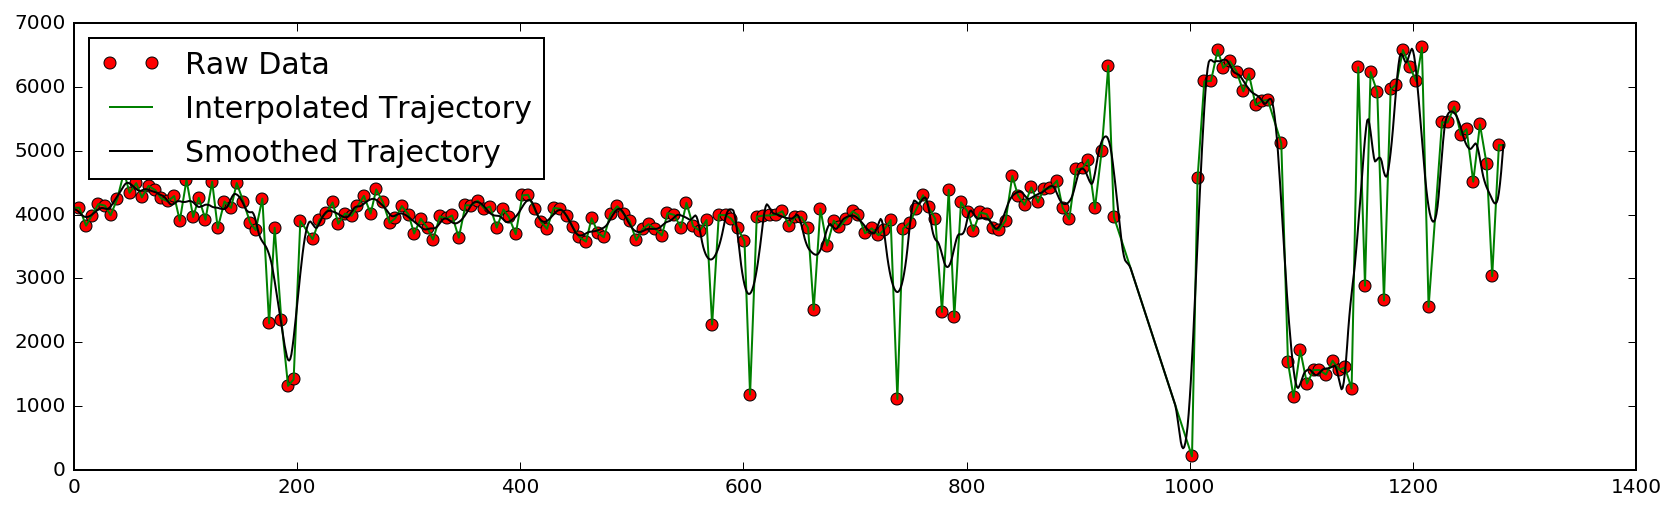

[0] Shape of feature is (1271, 17, 6)



[1] Opening [data/nancho4_2!!!.txt] with [21090] lines.
    Name:[nancho4_2!!!] #child:[17] endSec:[3910] lenData:[21090]


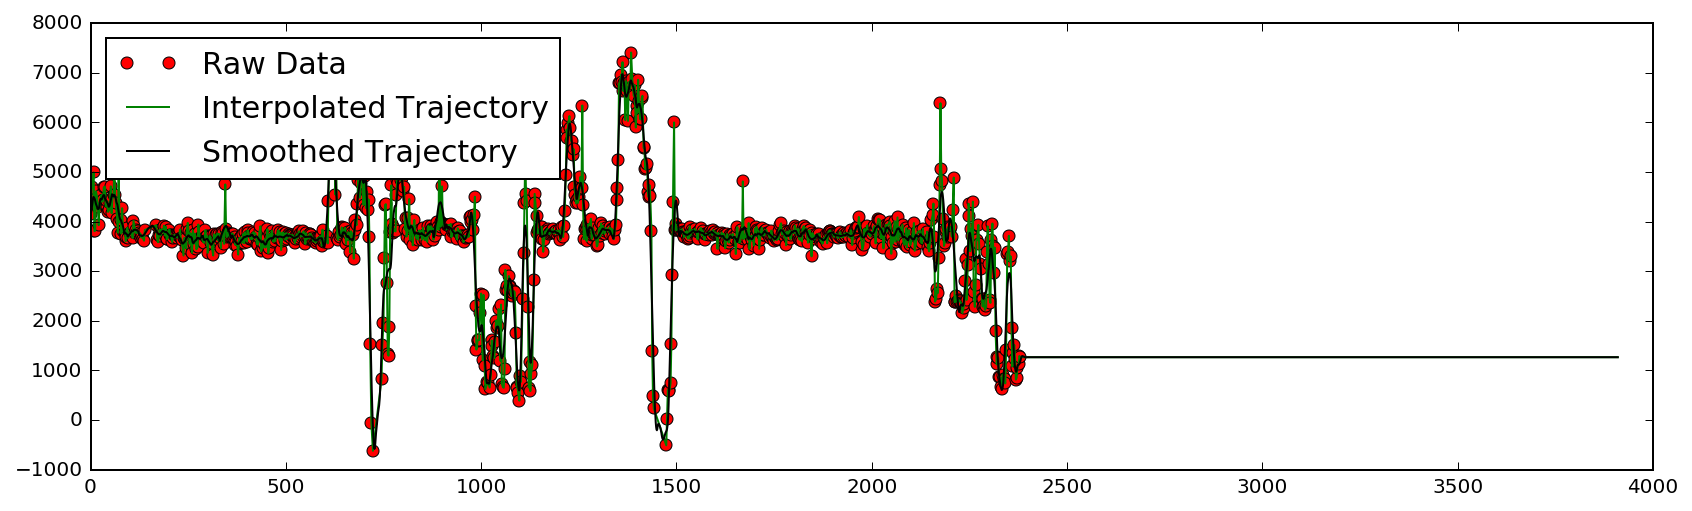

[1] Shape of feature is (3900, 17, 6)



[2] Opening [data/nancho5_1!!!.txt] with [4413] lines.
    Name:[nancho5_1!!!] #child:[17] endSec:[2166] lenData:[4413]


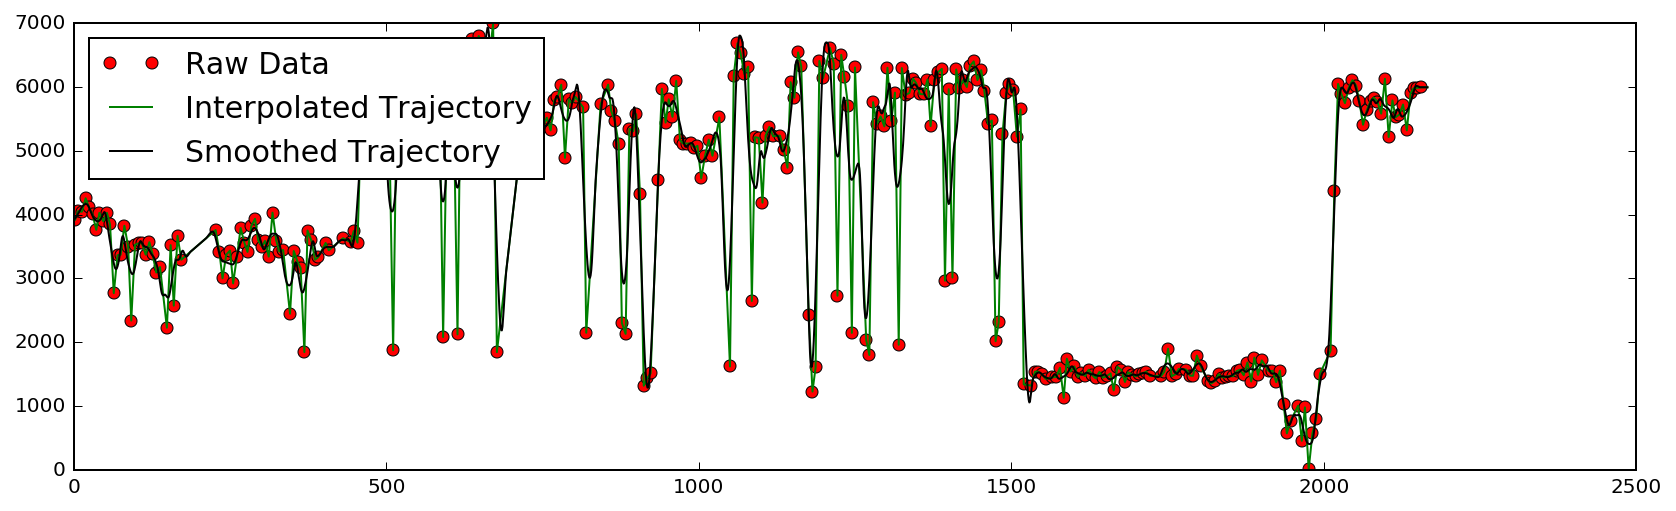

[2] Shape of feature is (2156, 17, 6)



[3] Opening [data/maehwa6_2!!!.txt] with [3490] lines.
    Name:[maehwa6_2!!!] #child:[13] endSec:[2152] lenData:[3490]


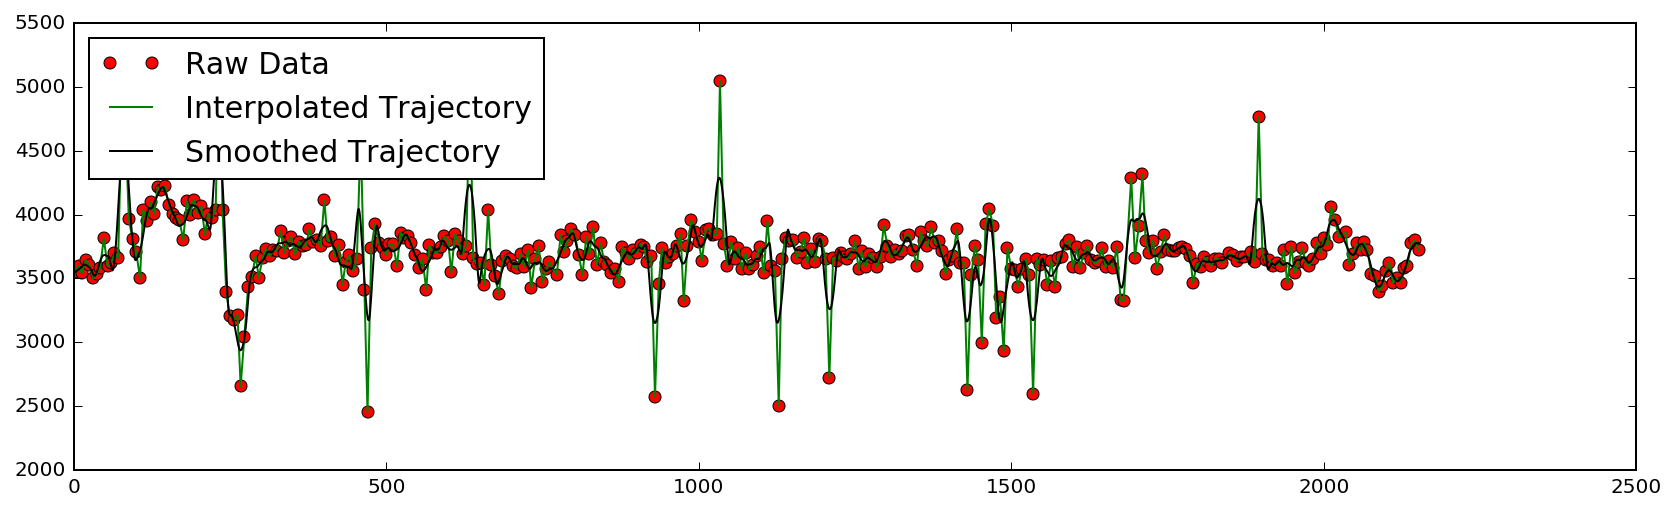

[3] Shape of feature is (2142, 13, 6)



[4] Opening [data/nancho4_1!!!.txt] with [3805] lines.
    Name:[nancho4_1!!!] #child:[16] endSec:[2506] lenData:[3805]


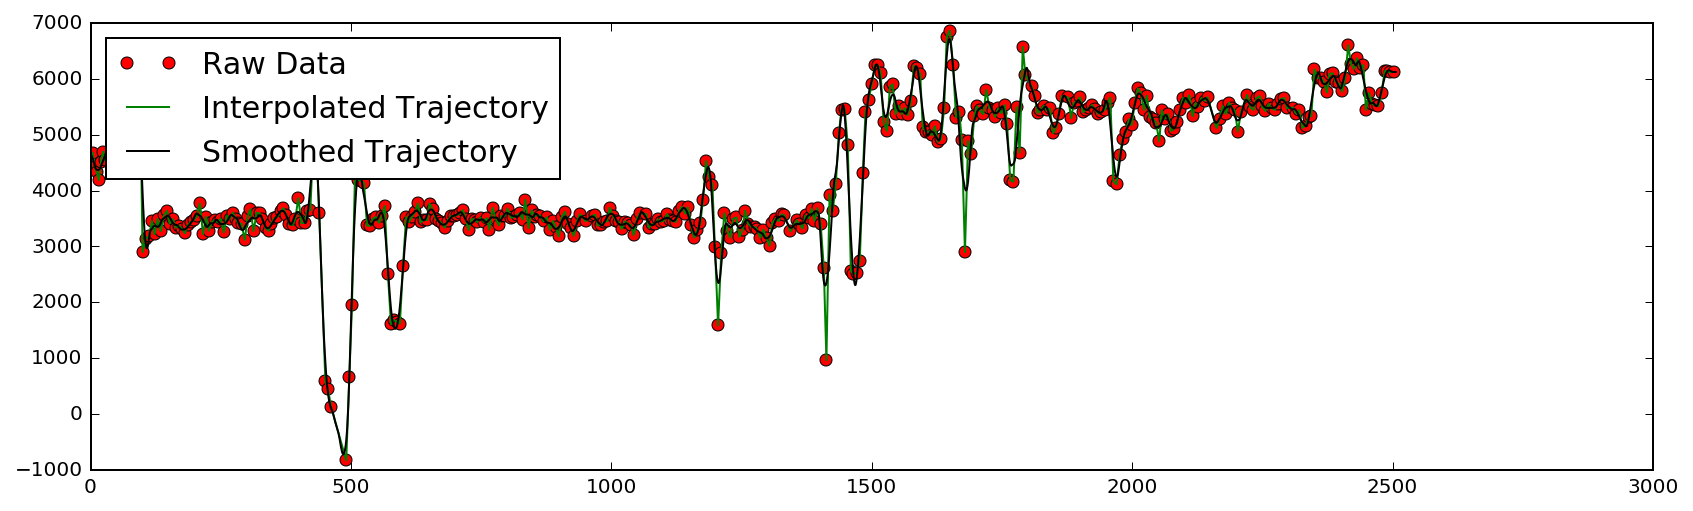

[4] Shape of feature is (2496, 16, 6)



[5] Opening [data/nancho5_3!!!.txt] with [4525] lines.
    Name:[nancho5_3!!!] #child:[16] endSec:[1738] lenData:[4525]


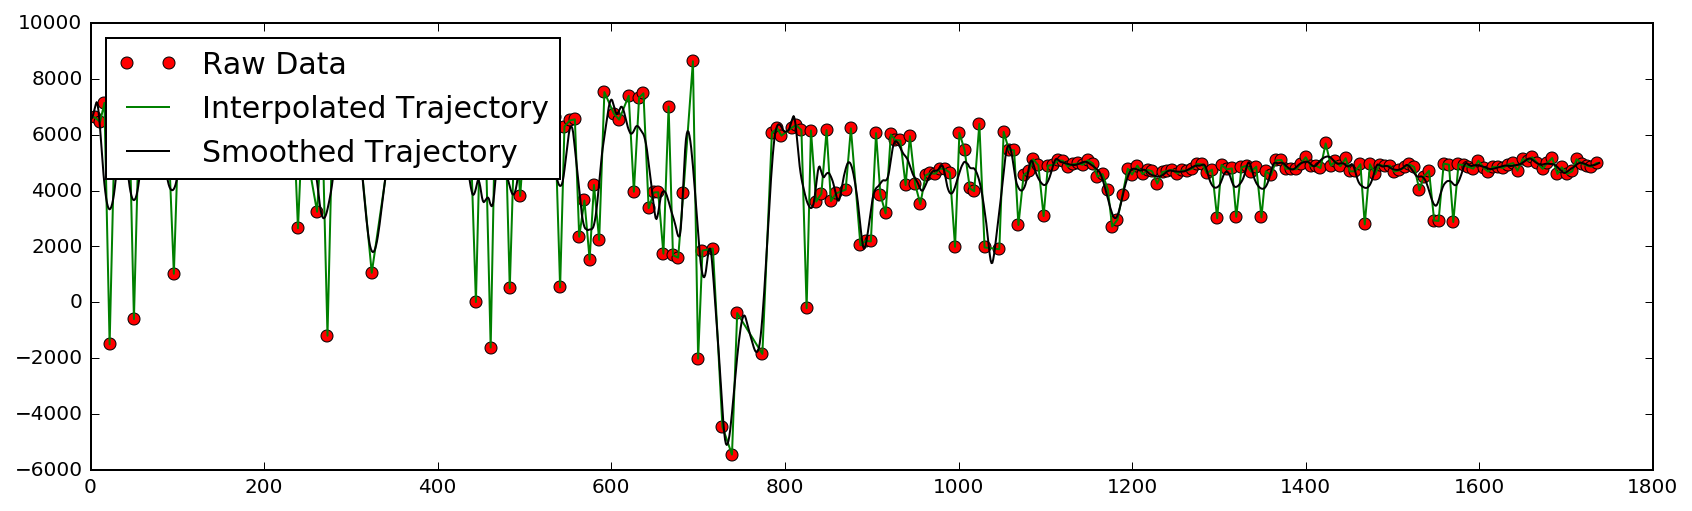

[5] Shape of feature is (1728, 16, 6)



[6] Opening [data/maehwa6_1!!!.txt] with [6336] lines.
    Name:[maehwa6_1!!!] #child:[15] endSec:[2876] lenData:[6336]


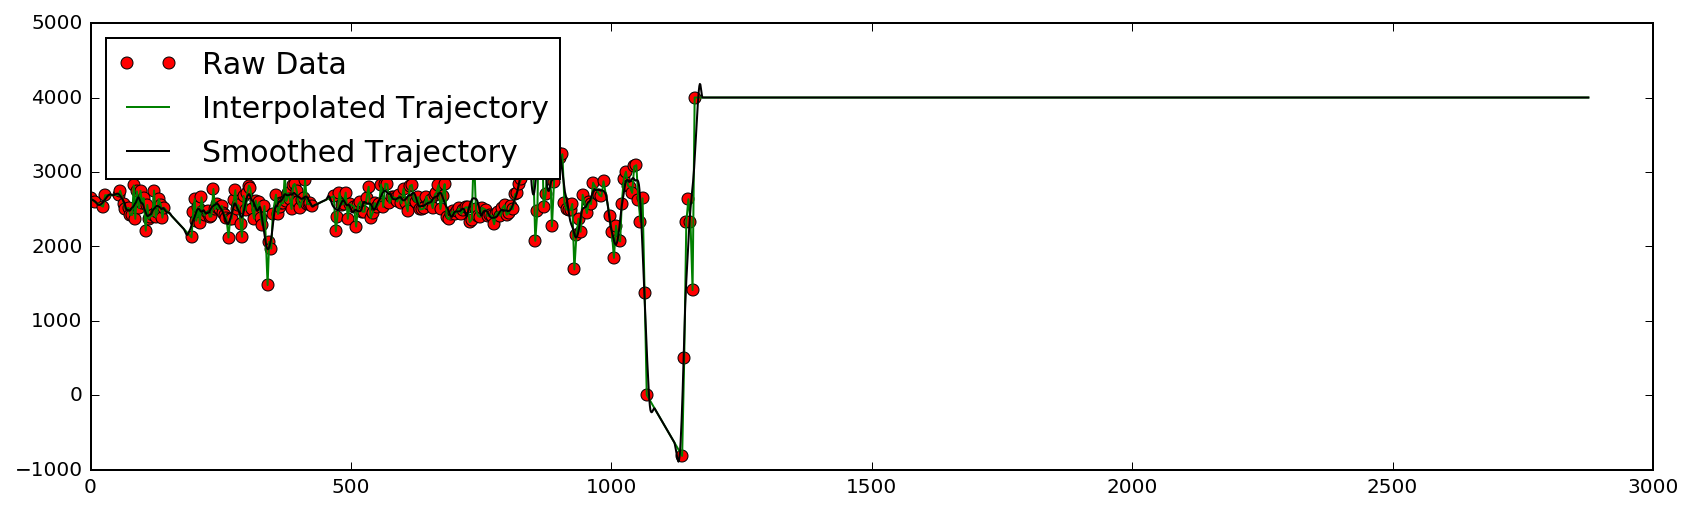

[6] Shape of feature is (2866, 15, 6)



[7] Opening [data/maehwa6_3!!!.txt] with [5685] lines.
    Name:[maehwa6_3!!!] #child:[15] endSec:[2949] lenData:[5685]


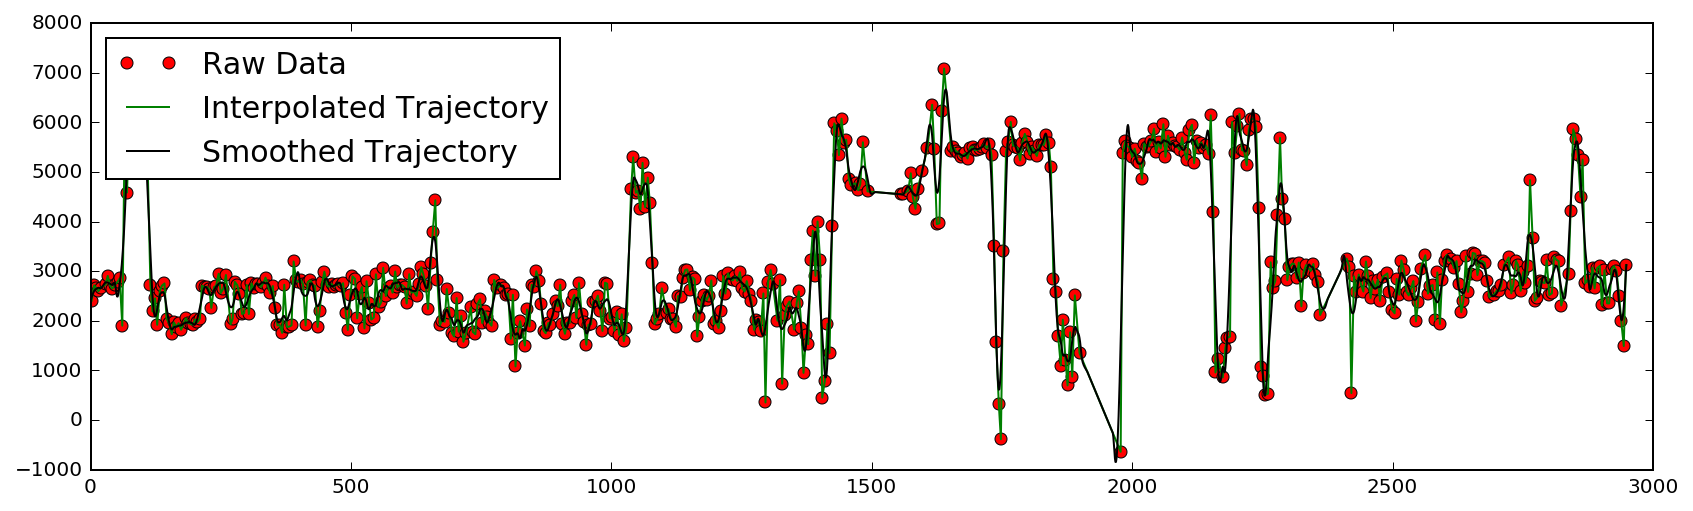

[7] Shape of feature is (2939, 15, 6)



[8] Opening [data/nancho4_3!!!.txt] with [6560] lines.
    Name:[nancho4_3!!!] #child:[19] endSec:[2491] lenData:[6560]


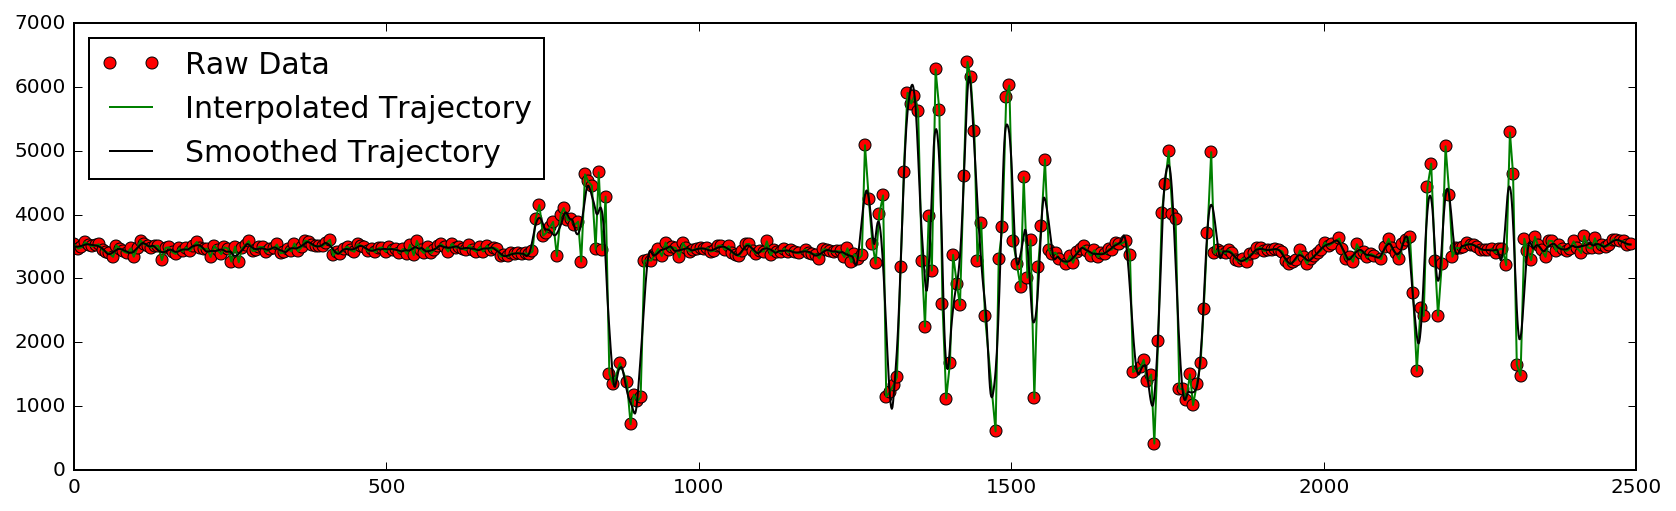

[8] Shape of feature is (2481, 19, 6)





In [6]:
# First assign an empty list with nTotalChildren size
totalFeats = [None]*nTotalChildren

# List for animating
trajList = [None]*nTotalTxt
uniqueChildIdxList = [None]*nTotalTxt
titleList = [None]*nTotalTxt

for fIdx,fName in enumerate(glob.glob(dirPath+'/*.txt')): # For each file
    # Parse basic information (totalSec,ID,x,y)
    nLines = sum(1 for line in open(fName)) # Number of lines
    secList,childIdxList,posList \
        = np.zeros([nLines]),np.zeros([nLines]),np.zeros([nLines,2])
    # Re-open current txt file
    txtFile = open(fName,'r') 
    print ("[%d] Opening [%s] with [%d] lines."%(fIdx,fName,nLines))
    for lIdx,eachLine in enumerate(txtFile): # For each line in a single file
        tokens = eachLine.split(',') # ex:['[2000-07-09 00:27:12]POS','0x6057','2458','5709','291\r\n']
        # First, extract hour, minute, and second
        h,m,s = int(tokens[0][12:14]),int(tokens[0][15:17]),int(tokens[0][18:20])
        totalSec = 3600*h+60*m+s # Total seconds
        # Second, extract childId and location
        chlidId,x,y = fName[5:].split('_')[0]+tokens[1][2:],int(tokens[3]),int(tokens[4]) # ID,x,y
        chlidIdx = id2idx[chlidId] # Get corresponding child index in numbers
        # Third, accumulate time, child index, and location
        secList[lIdx],childIdxList[lIdx],posList[lIdx,:] = int(totalSec),(chlidIdx),np.array([x,y])
        # Exception handling ex: (23:59 => 00:01)
        if (lIdx>0) & (secList[lIdx]<secList[0]): secList[lIdx] += 24*3600
    # Set starting time to be zero
    secList -= np.min(secList) 
    
    # Make trajectories 
    uniqueChildList = np.unique(childIdxList) # Get unique chlid indices
    nChild = np.unique(childIdxList).shape[0] # Number of unique children
    secDur = (int)(secList[-1]) # Total seconds
    nData  = (int)(secList.shape[0]) # Number of data
    print "    Name:[%s] #child:[%d] endSec:[%d] lenData:[%d]" \
        %(fName[5:-4],nChild,secDur,nData)
    # Sparsely fill in the trajectory
    traj = np.zeros(shape=[secDur+1,nChild,2]) # [T x N x 2]
    for idx in range(nData):
        cIdx = np.where(uniqueChildList==childIdxList[idx])[0][0] # Children index
        traj[(int)(secList[idx]),cIdx,:] = posList[idx,:]
    # Fill-in the traejctory using interpolation
    traj_intp = np.zeros(shape=[secDur+1,nChild,2]) # [T x N x 2]
    for nIDx in range(nChild):
        xTraj,yTraj = traj[:,nIDx,0],traj[:,nIDx,1] # Get trajectory
        tNz = np.where(xTraj!=0)[0] # Find nonzero indices
        xNz,yNz = xTraj[tNz],yTraj[tNz] # Get corresponding nonzero trajectory
        mu_xNz,mu_yNz = np.mean(xNz),np.mean(yNz)
        tIntp = np.linspace(0,secDur,secDur+1,dtype=np.int32)
        # Do interpolation
        xIntp,yIntp = np.interp(tIntp,tNz,xNz-mu_xNz)+mu_xNz,np.interp(tIntp,tNz,yNz-mu_yNz)+mu_yNz
        # Low pass filter
        window_size,order = 31,2
        xLp = savitzky_golay(xIntp-mu_xNz,window_size,order)+mu_xNz
        yLp = savitzky_golay(yIntp-mu_yNz,window_size,order)+mu_yNz
        traj_intp[:,nIDx,0],traj_intp[:,nIDx,1] = xIntp,yIntp
    # Plot original, interpolated, and smoothed trajectory
    PLOT_SMOOTHED_TRAJ = True
    if PLOT_SMOOTHED_TRAJ:
        plt.figure(figsize=(14,4))
        plt.plot(tNz,xNz,'ro');plt.plot(tIntp,xIntp,'g-');plt.plot(tIntp,xLp,'k-')
        plt.legend(['Raw Data','Interpolated Trajectory','Smoothed Trajectory']
               ,loc='upper left',fontsize=15);plt.show()

    # Animate
    DO_ANIMATE = False
    if DO_ANIMATE:
        frames = make_frames(_traj=traj_intp,_uniqueChildList=uniqueChildList,_nTick=10)
        animate_frames(_frames=frames,_figsize=(8,8),_title='[%d] %s'%(fIdx,fName[5:-4]))
    trajList[fIdx] = traj_intp
    uniqueChildIdxList[fIdx] = uniqueChildList
    titleList[fIdx] = '[%d] %s'%(fIdx,fName[5:-4])
    
    # Compute features from the 'traj_intp'
    traj_trim = traj_intp[5:-5,:,:] # Remove first and last five second data
    T,Q = traj_trim.shape[0],traj_trim.shape[1]
    feats = np.zeros(shape=[(T-1),Q,6]) # Feature tensor (five dists2others + one displacement)
    for tick in range(T-1): # For all time step
        posList = traj_trim[tick,:,:].squeeze()
        cDists = cdist(posList,posList,'euclidean')
        for qIdx in range(Q): # For each person
            cDists_q = cDists[qIdx,:]
            dists2friends = np.sort(cDists_q)[1:6] # Use first five excluding zero
            displacement = np.linalg.norm(traj[tick+1,qIdx,:]-traj[tick,qIdx,:])
            feat = np.concatenate((dists2friends,displacement.reshape(1)))
            # Accumulate features
            feats[tick,qIdx,:] = feat
    print ("[%d] Shape of feature is %s"%(fIdx,feats.shape))
    
    # Make 'totalFeats' per each child
    for qIdx in range(Q): # For all children
        childIdx = (int)(uniqueChildList[qIdx])
        currTotalFeats = totalFeats[childIdx]
        currFeat = feats[:,qIdx,:].squeeze()
        if currTotalFeats is None: totalFeats[childIdx] = currFeat
        else: totalFeats[childIdx] = np.concatenate((totalFeats[childIdx],currFeat),axis=0)
    print ("\n\n")

### Animate frames


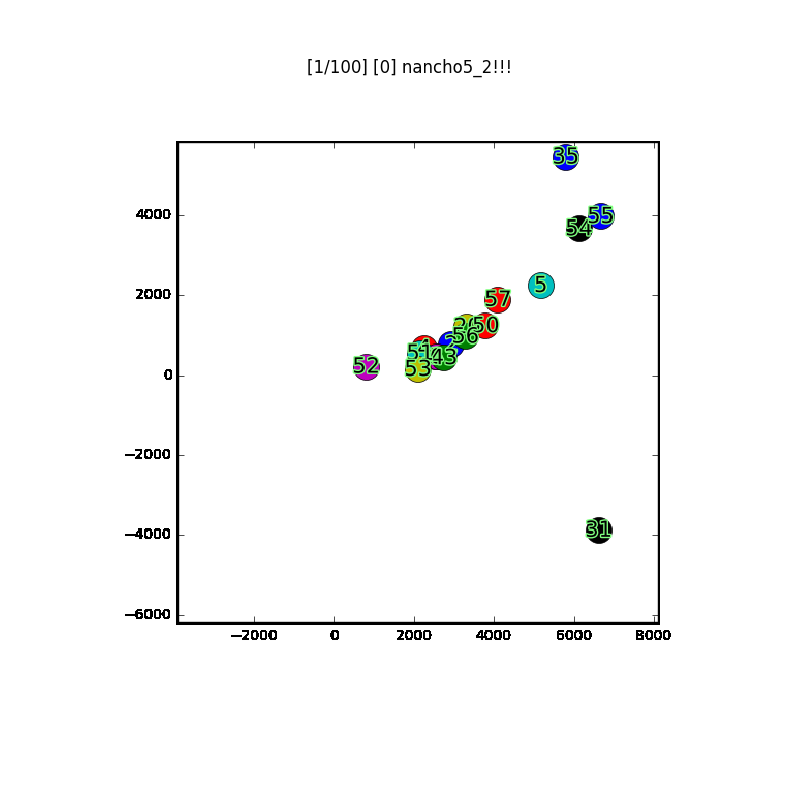
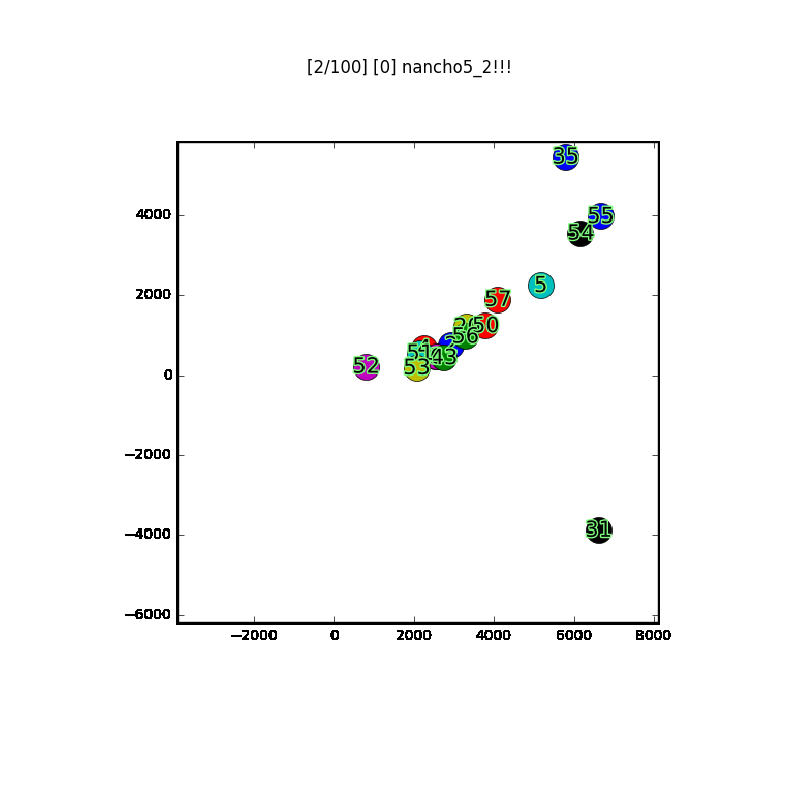
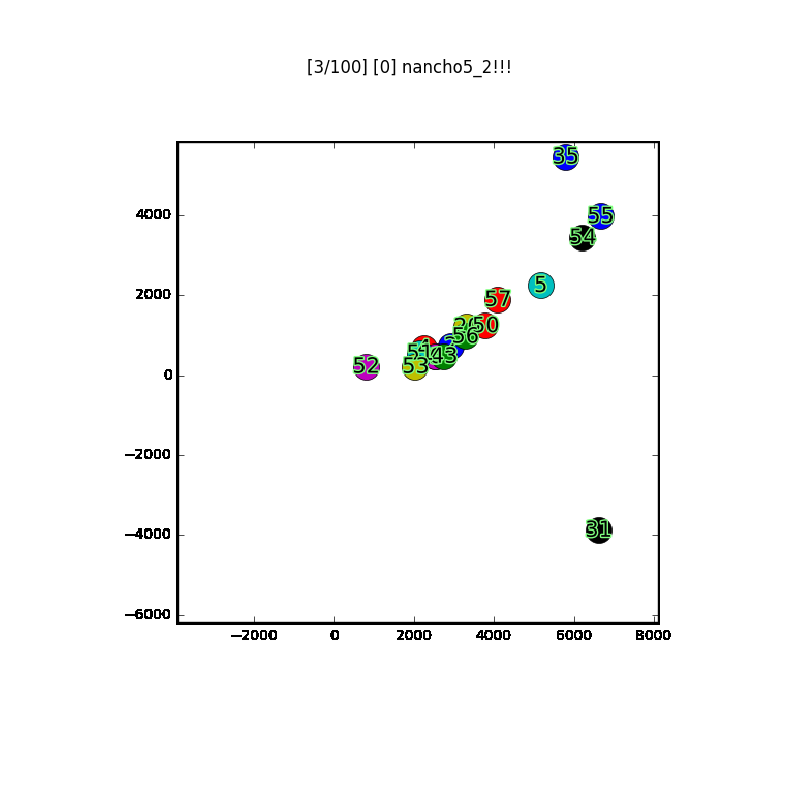
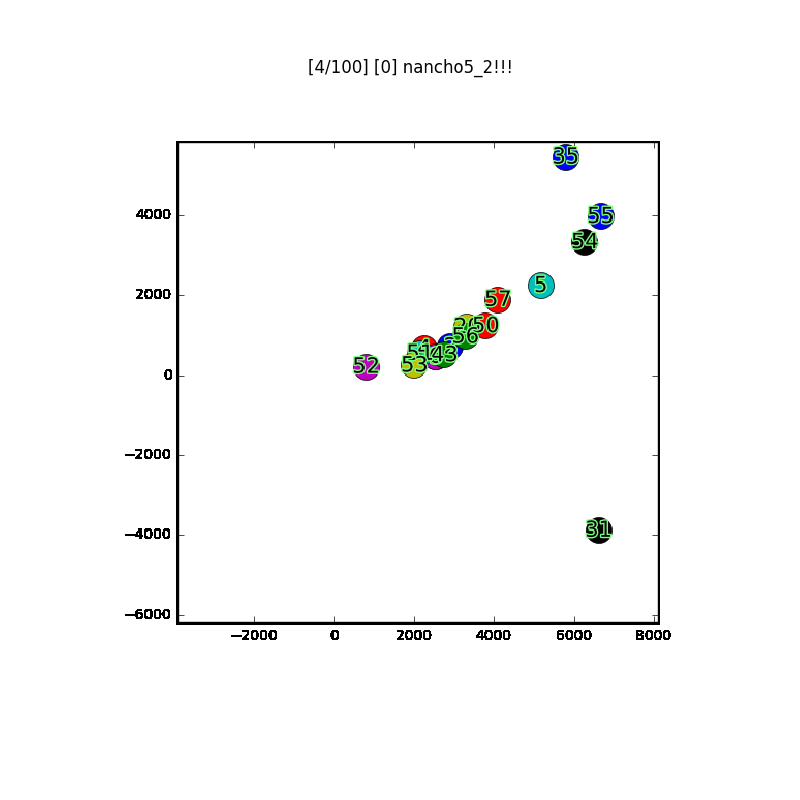
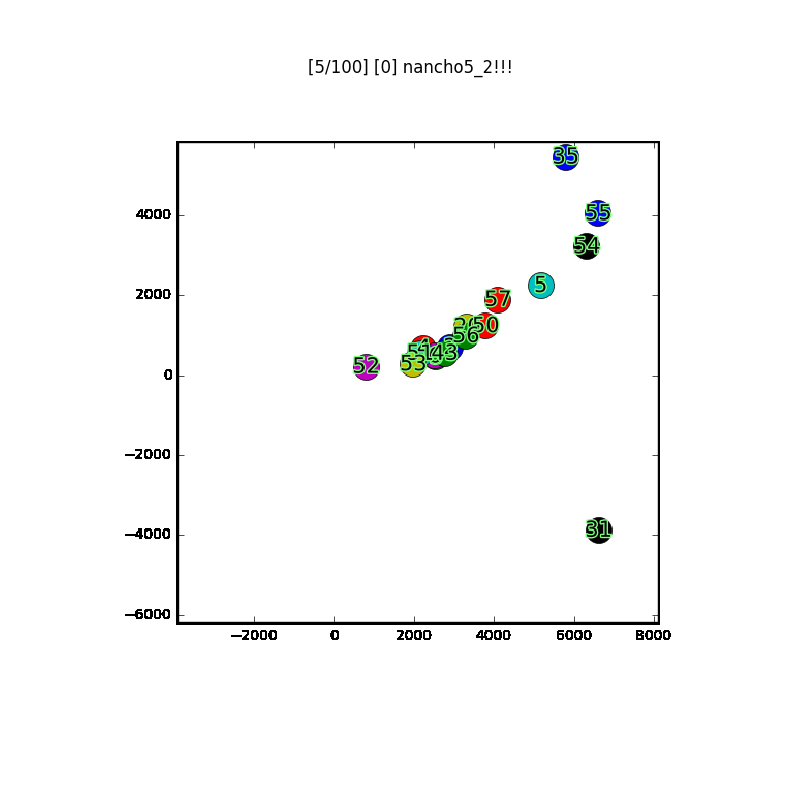
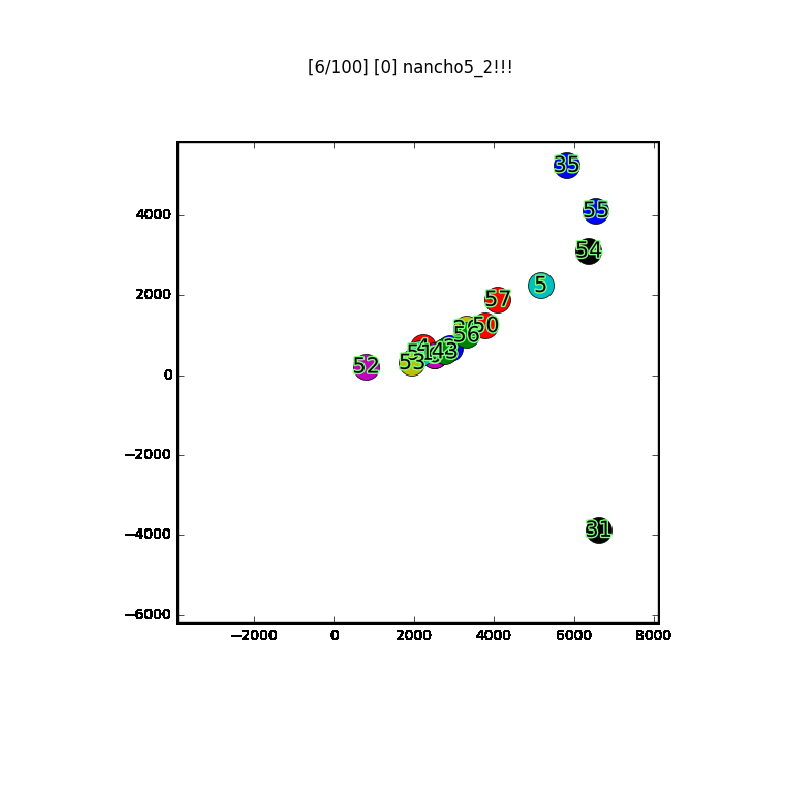
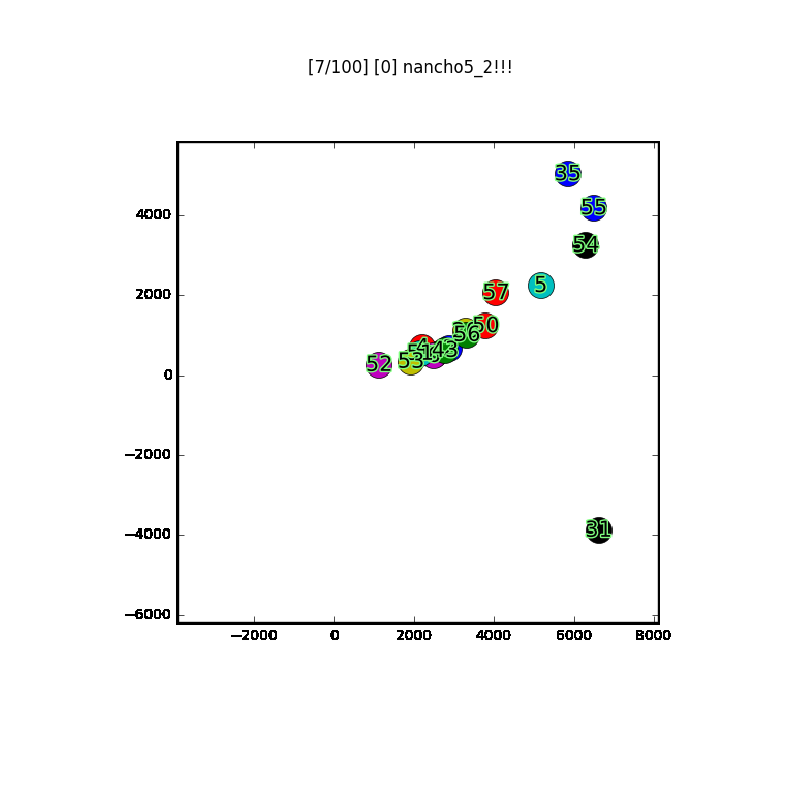
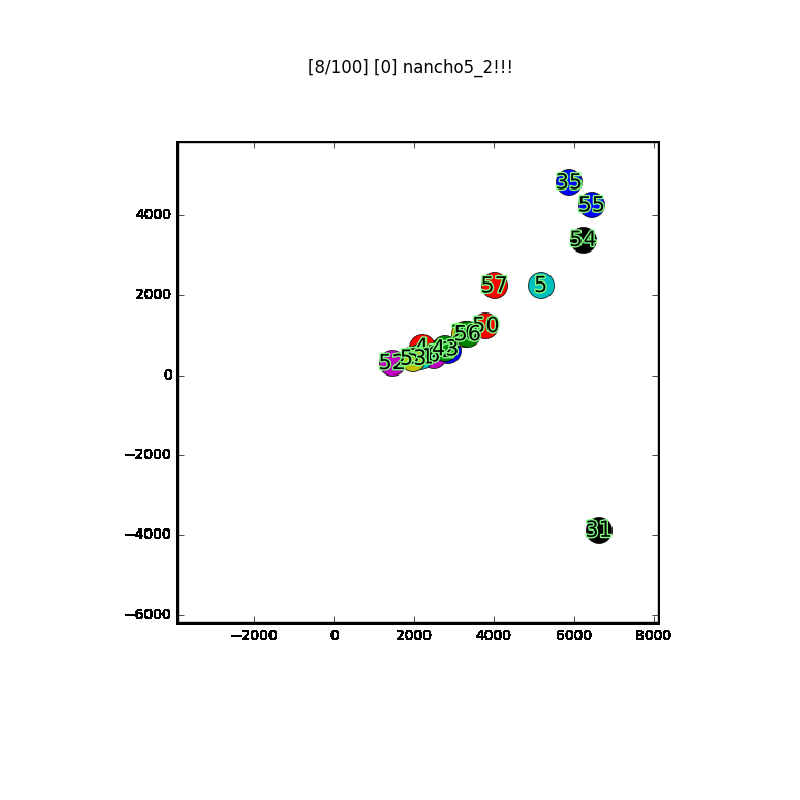
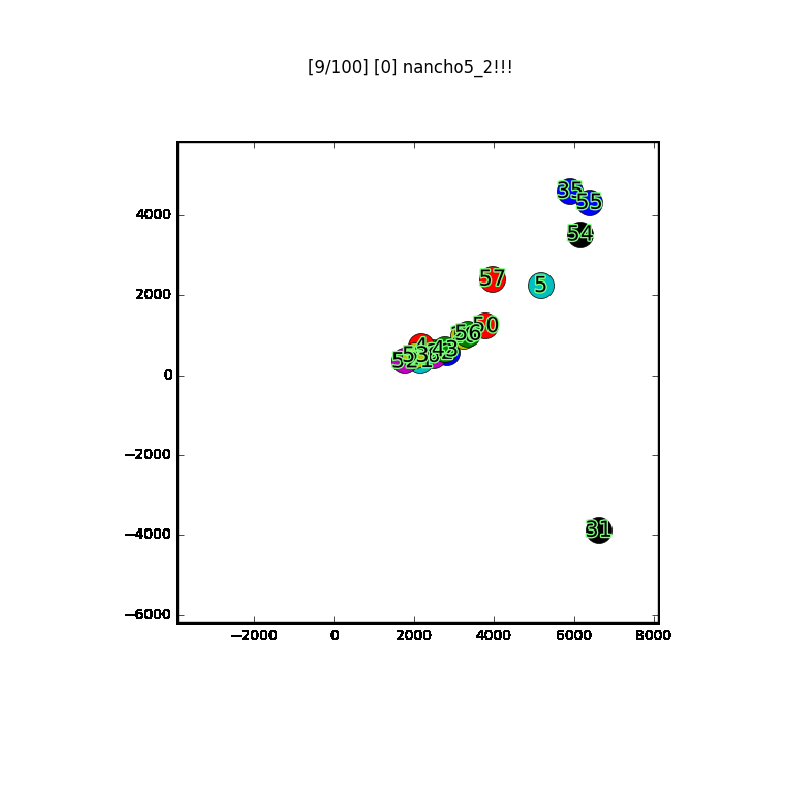
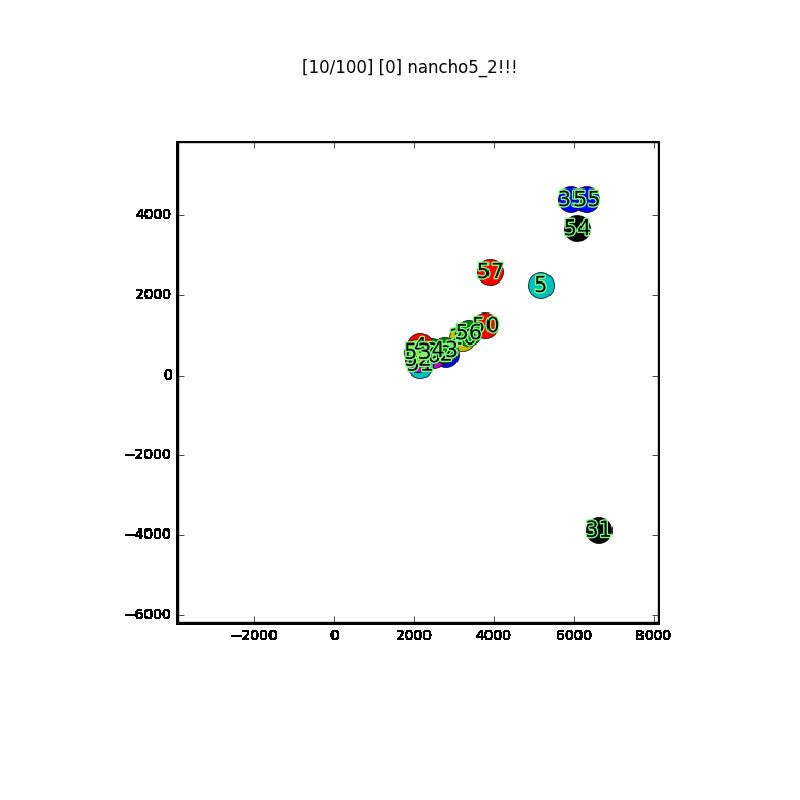
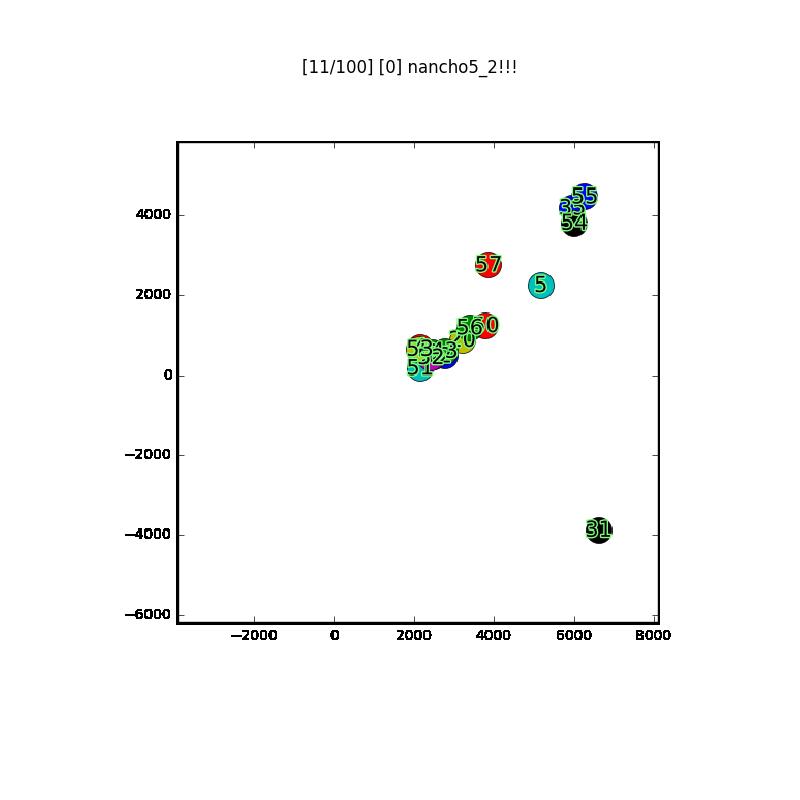
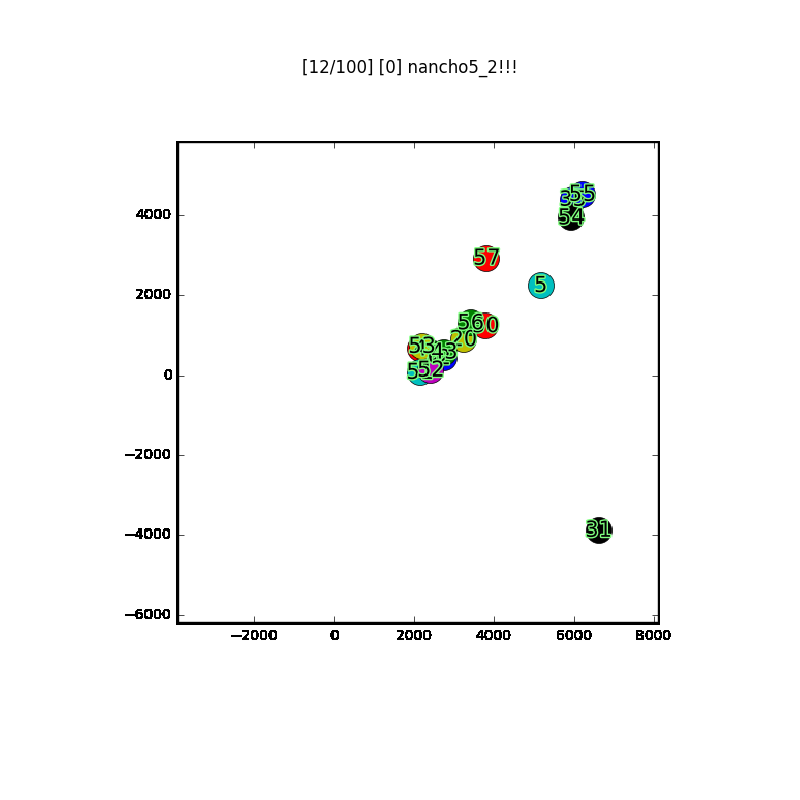
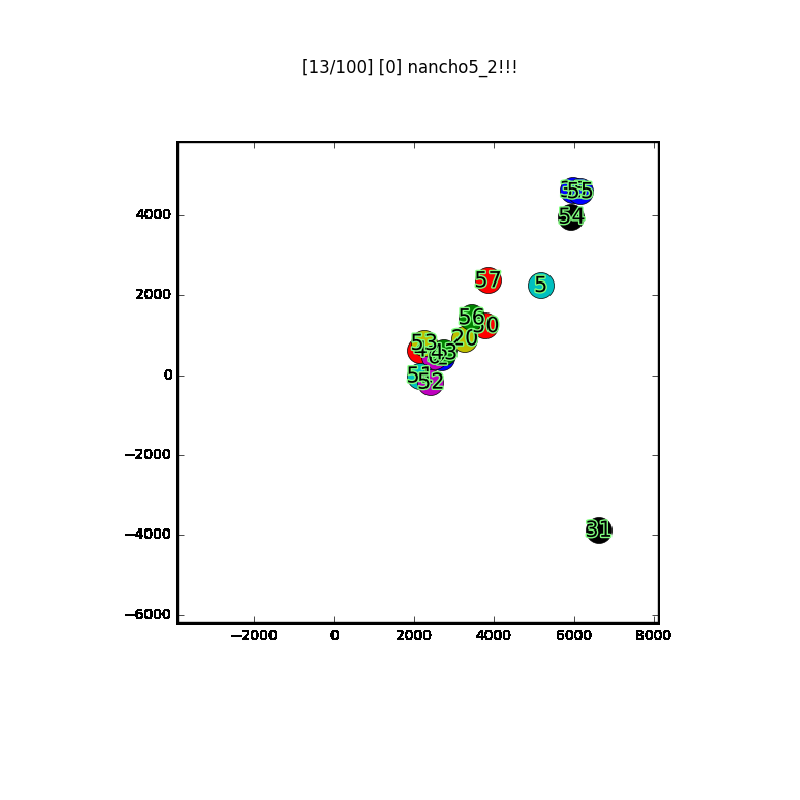
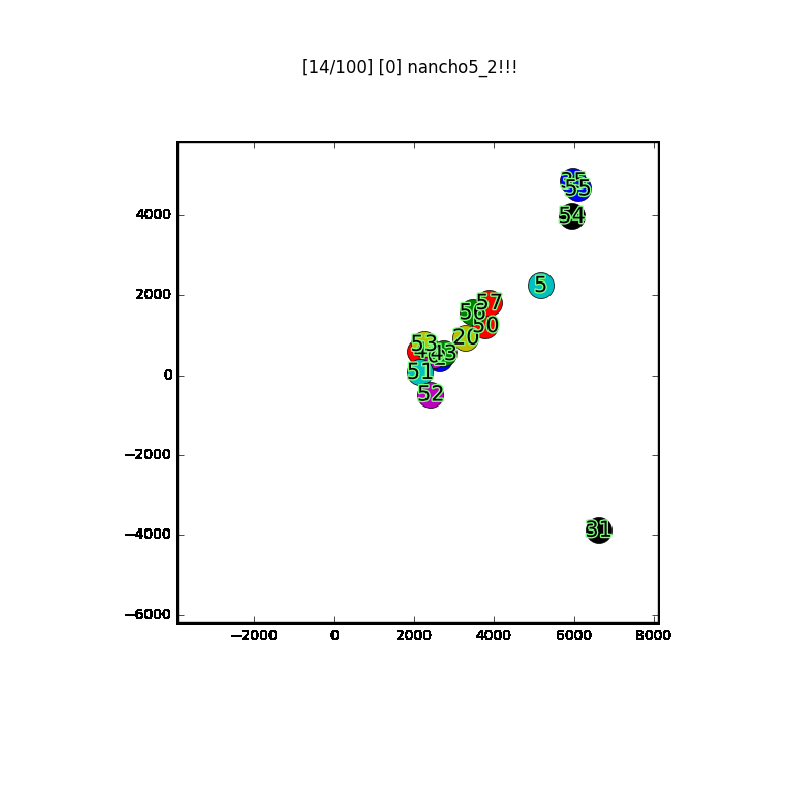
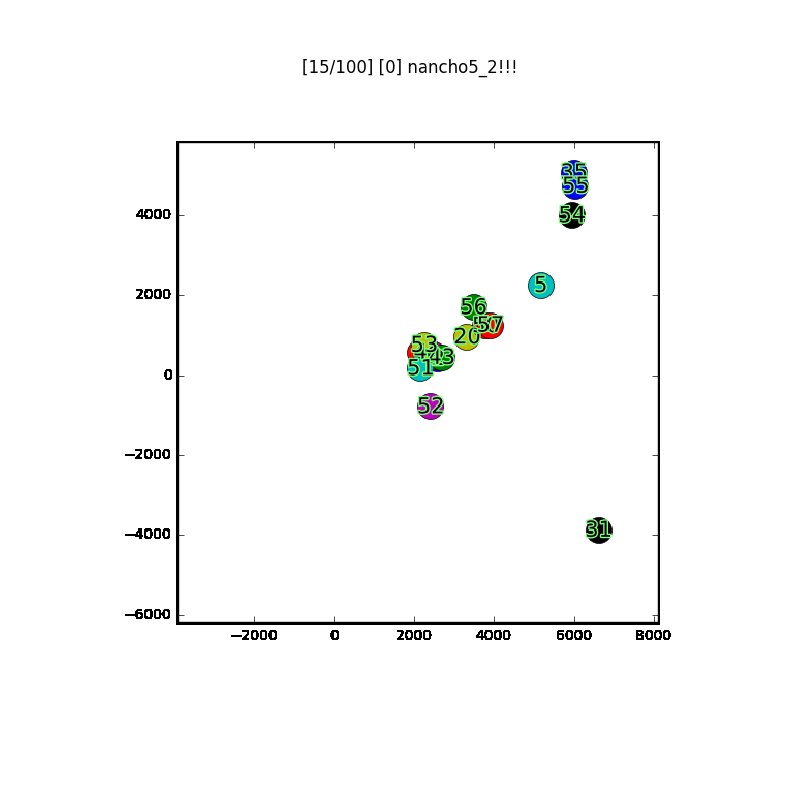
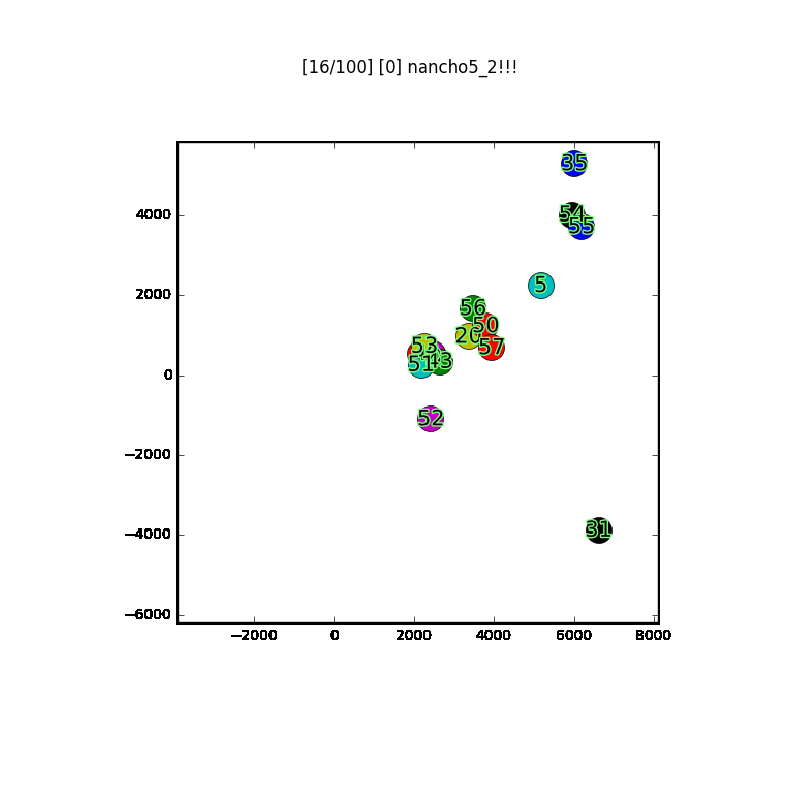
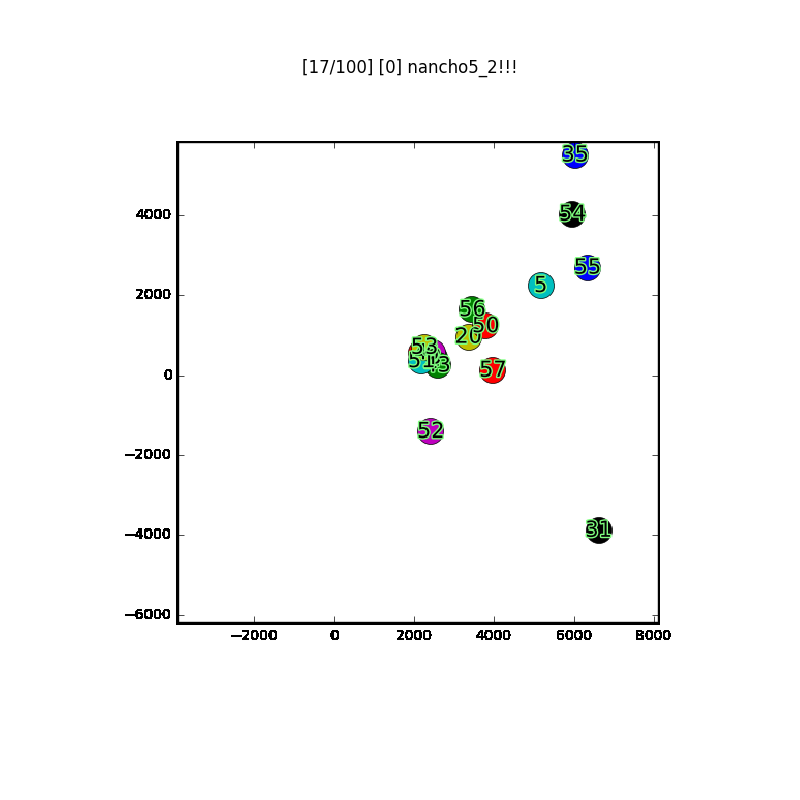
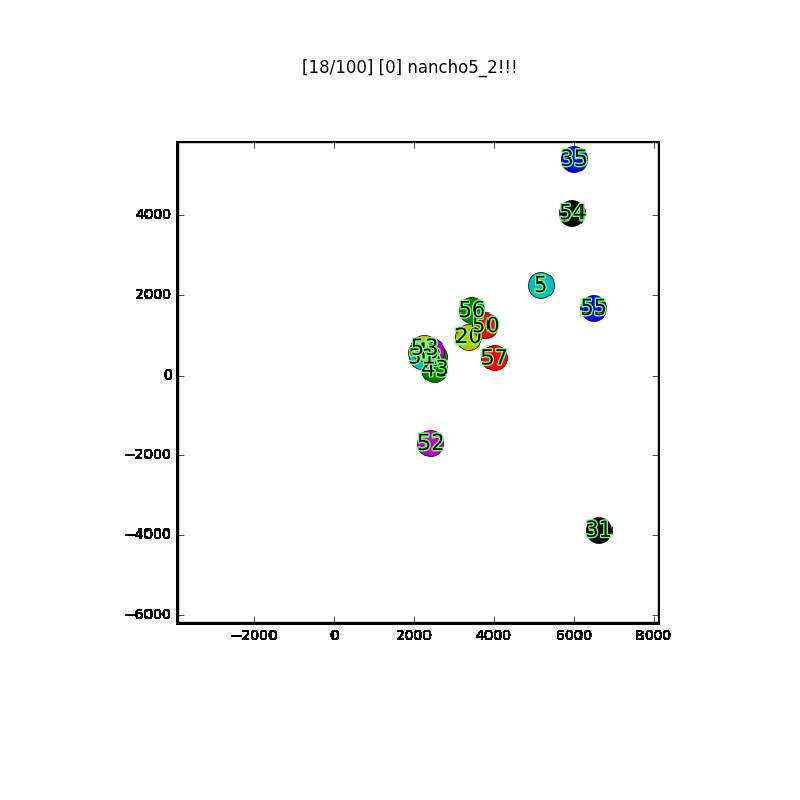
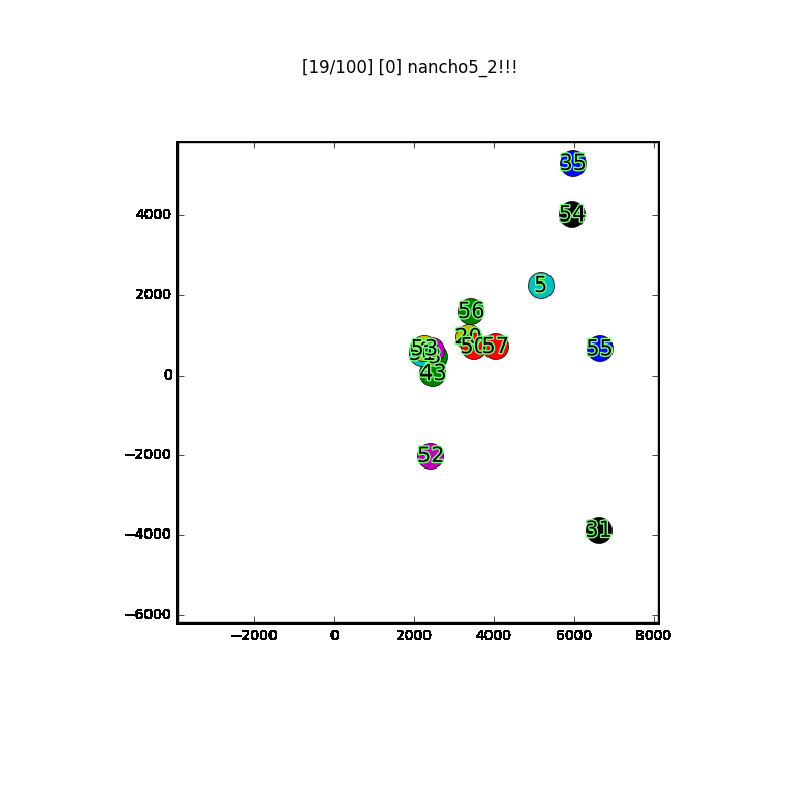
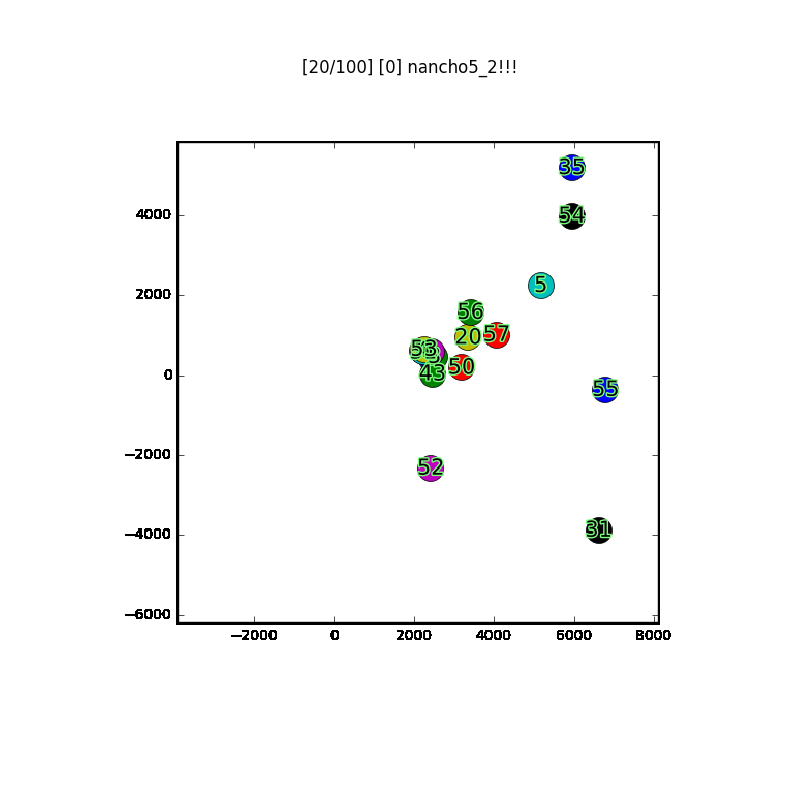
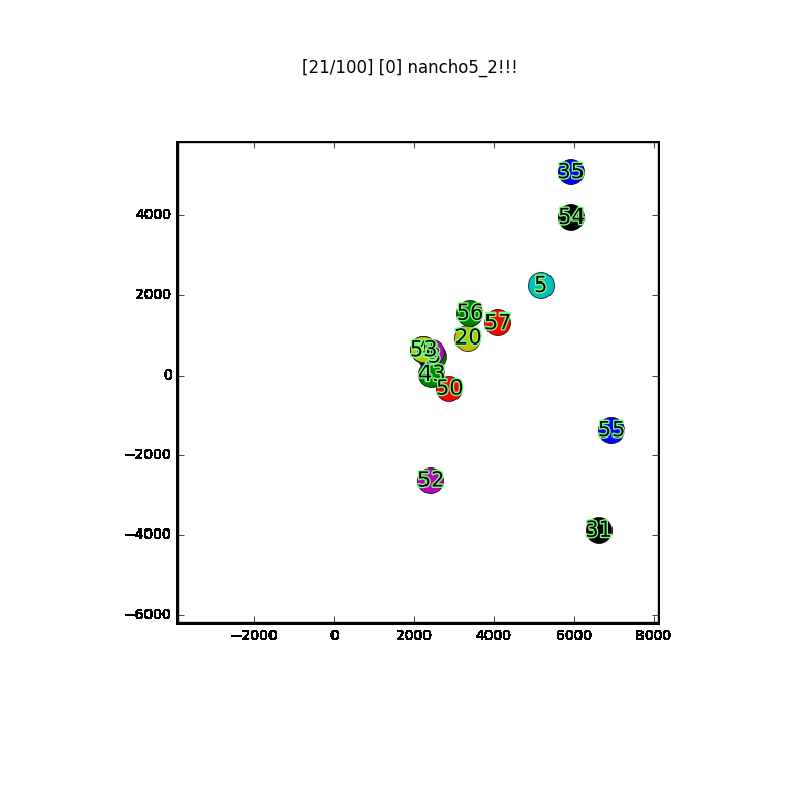
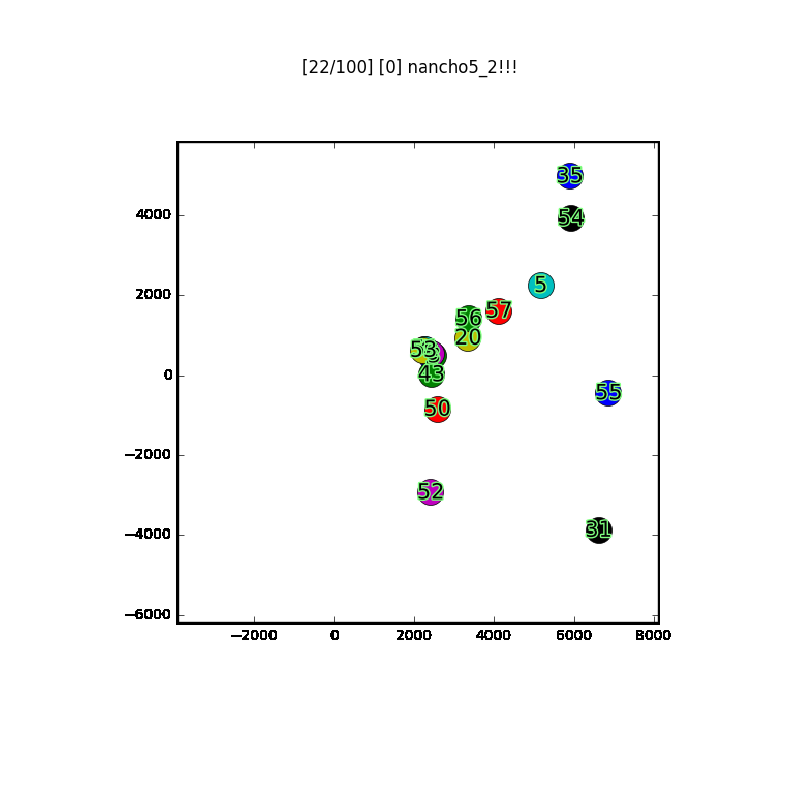
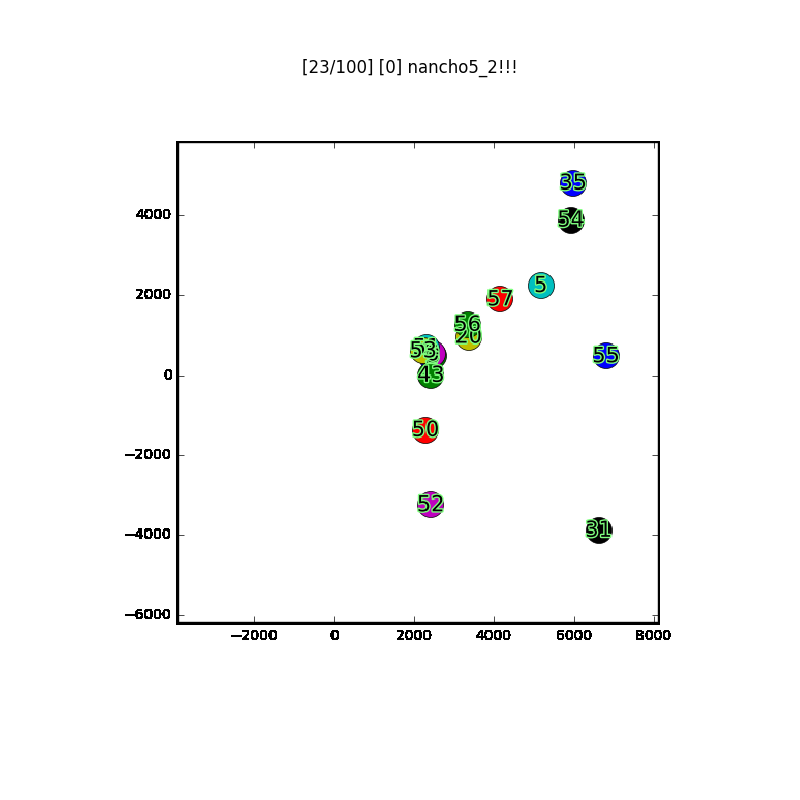
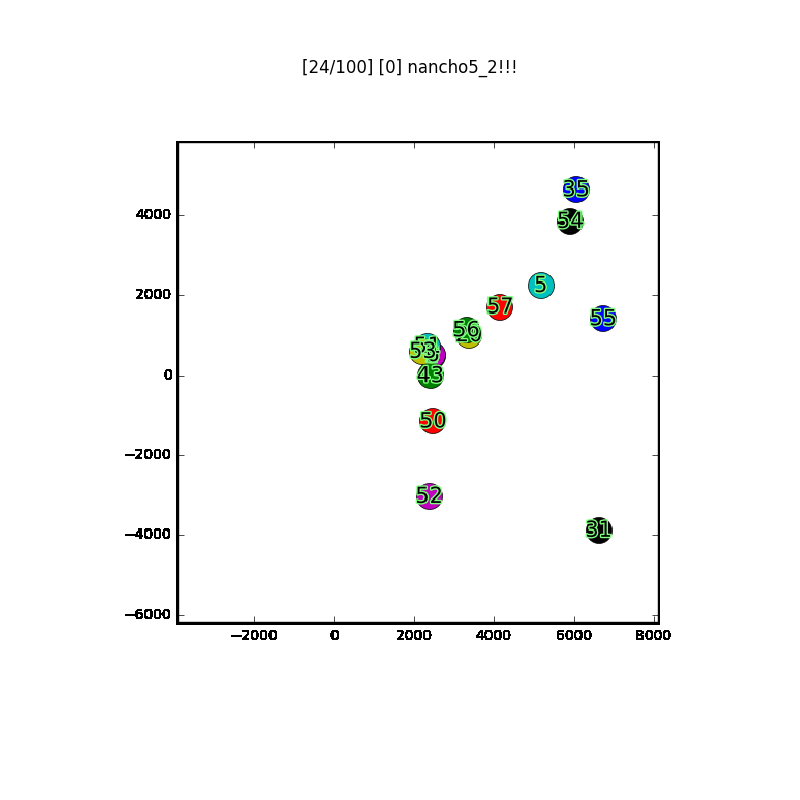
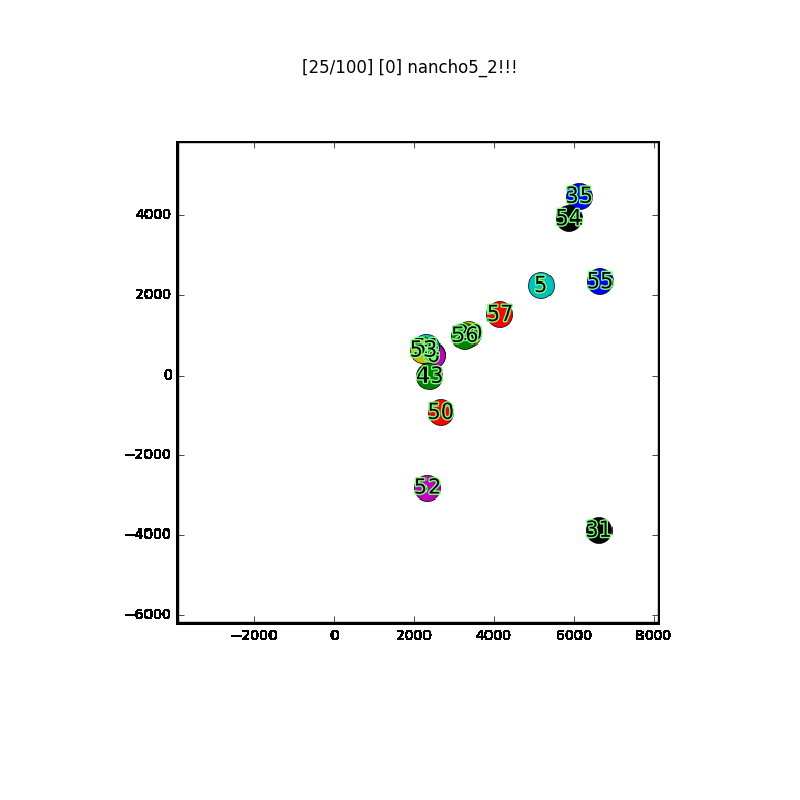
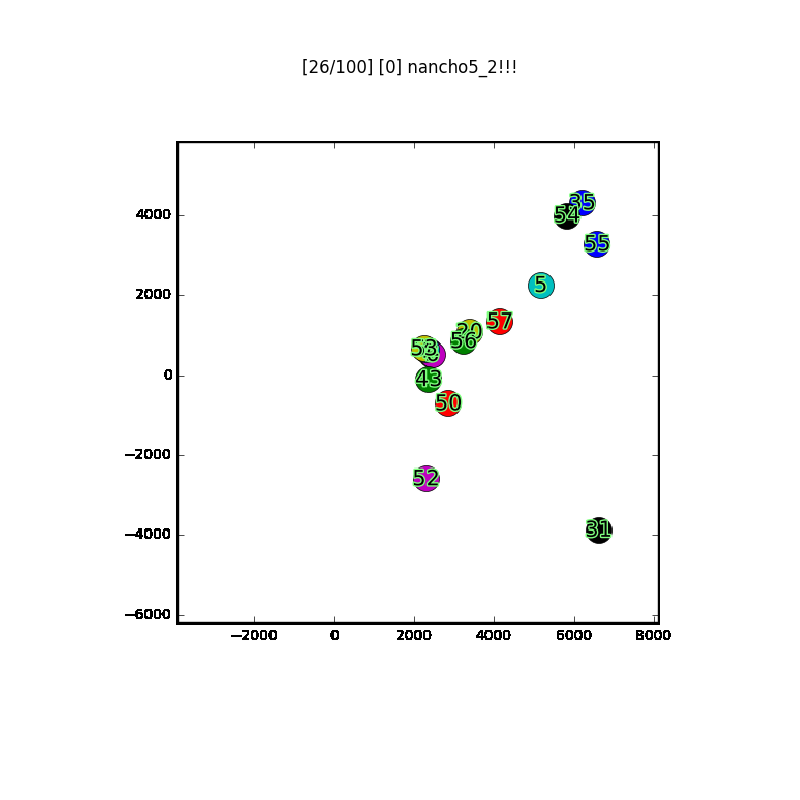
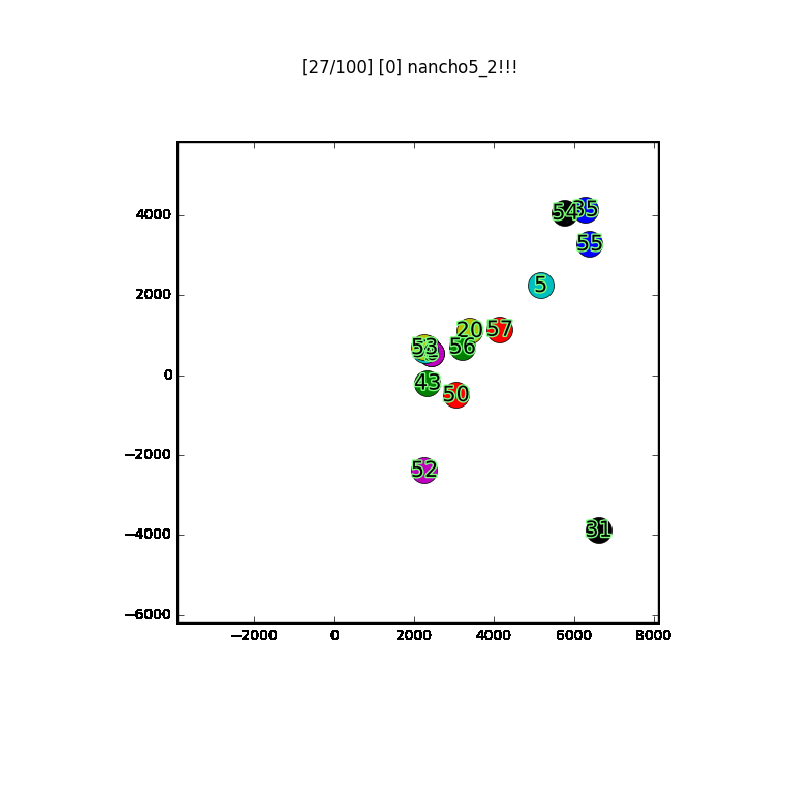
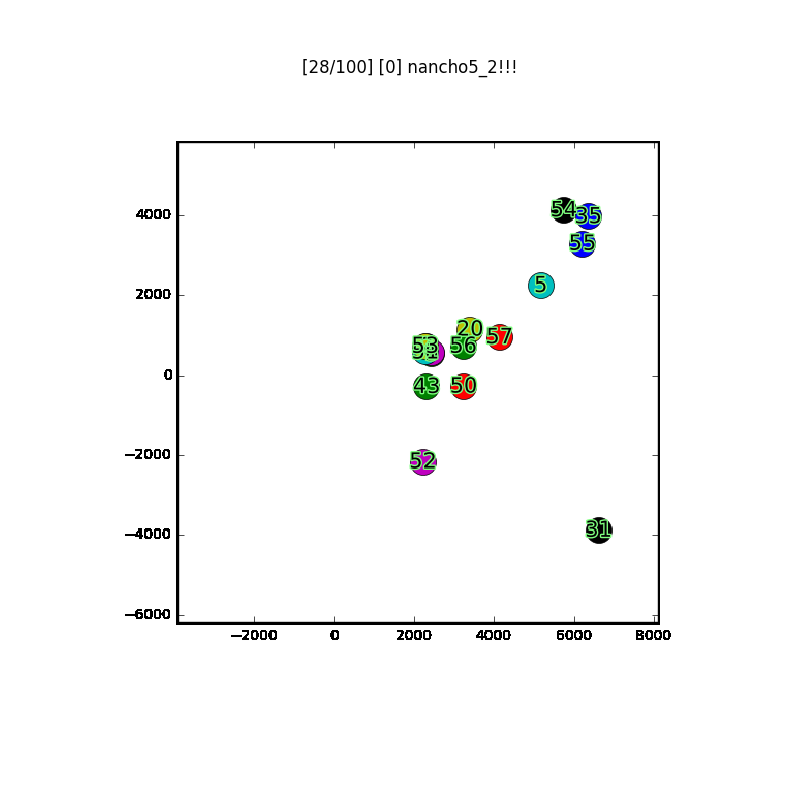
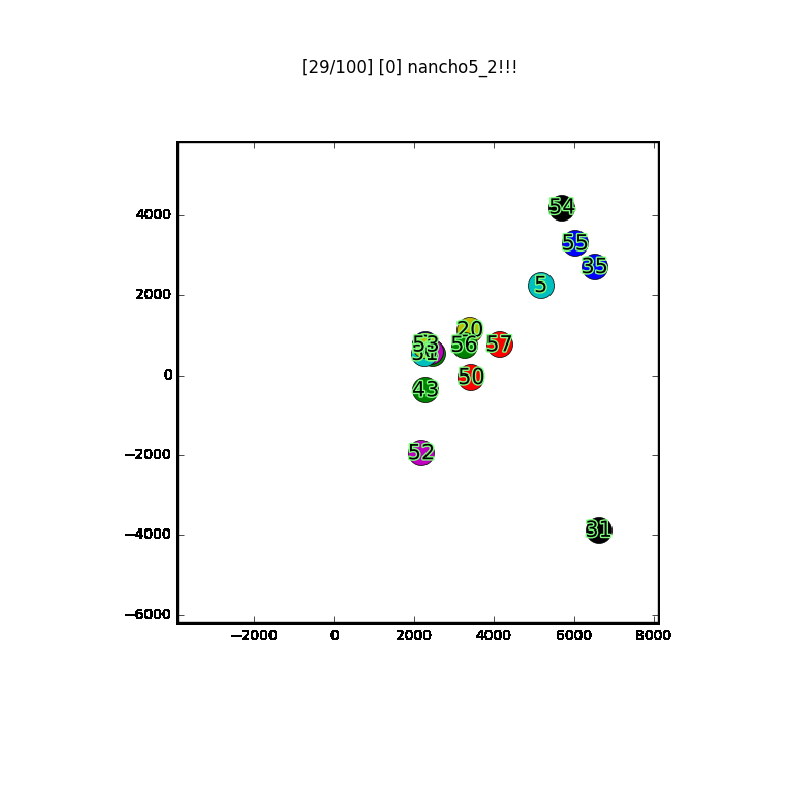
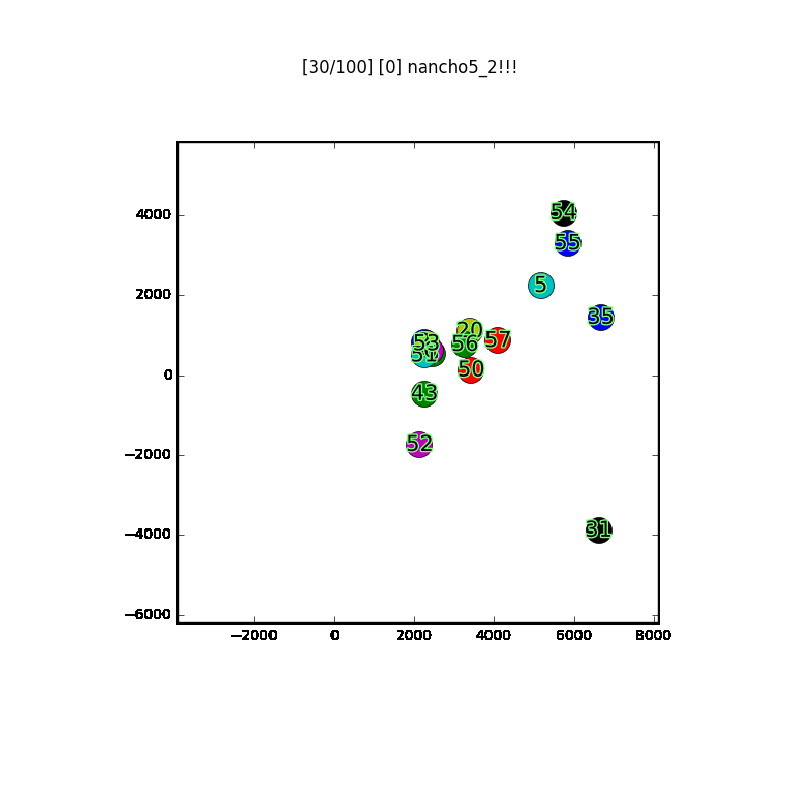
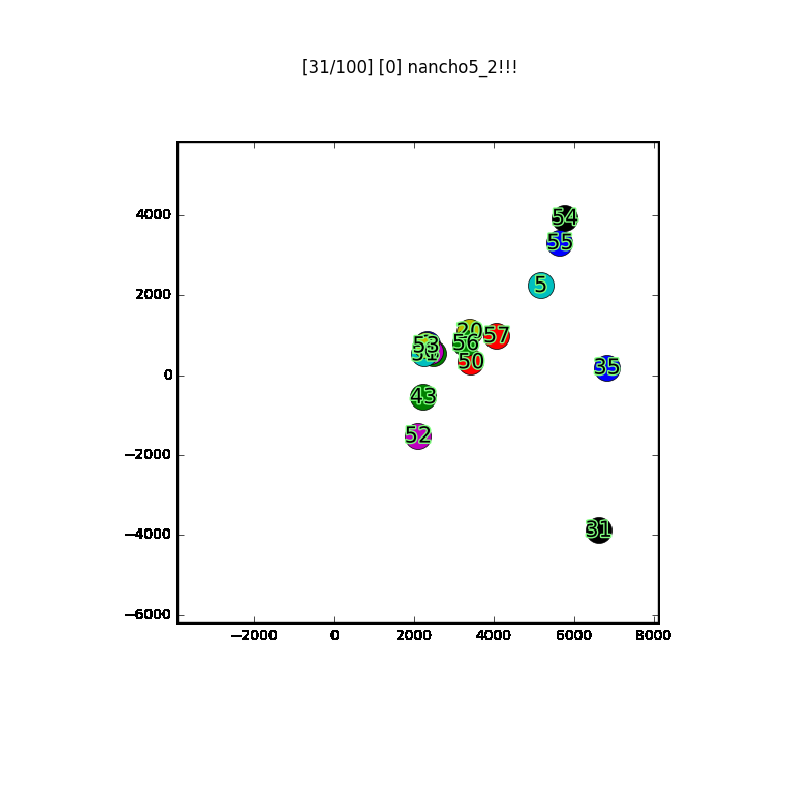
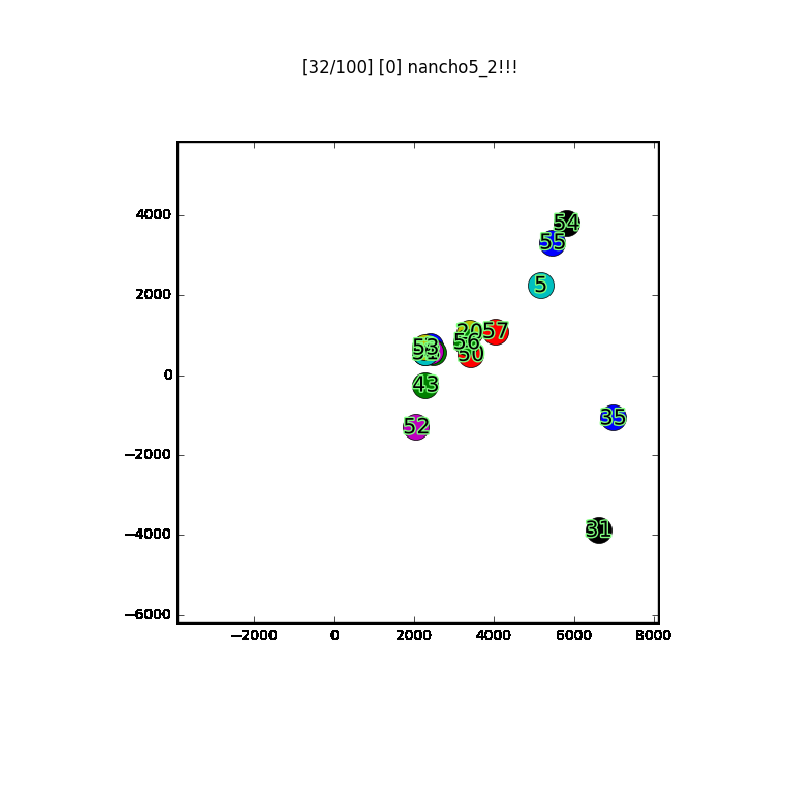
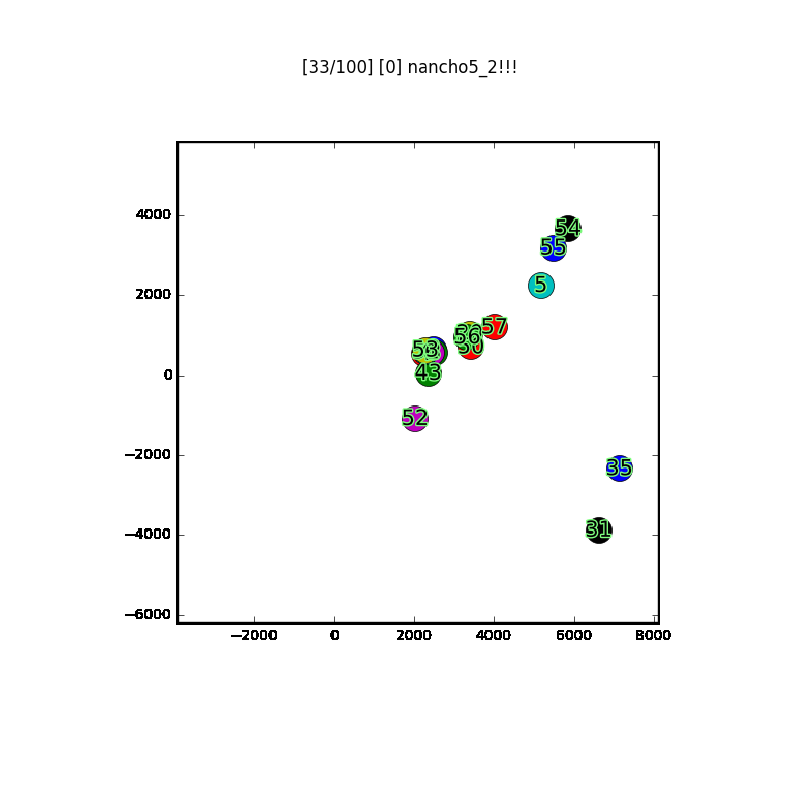
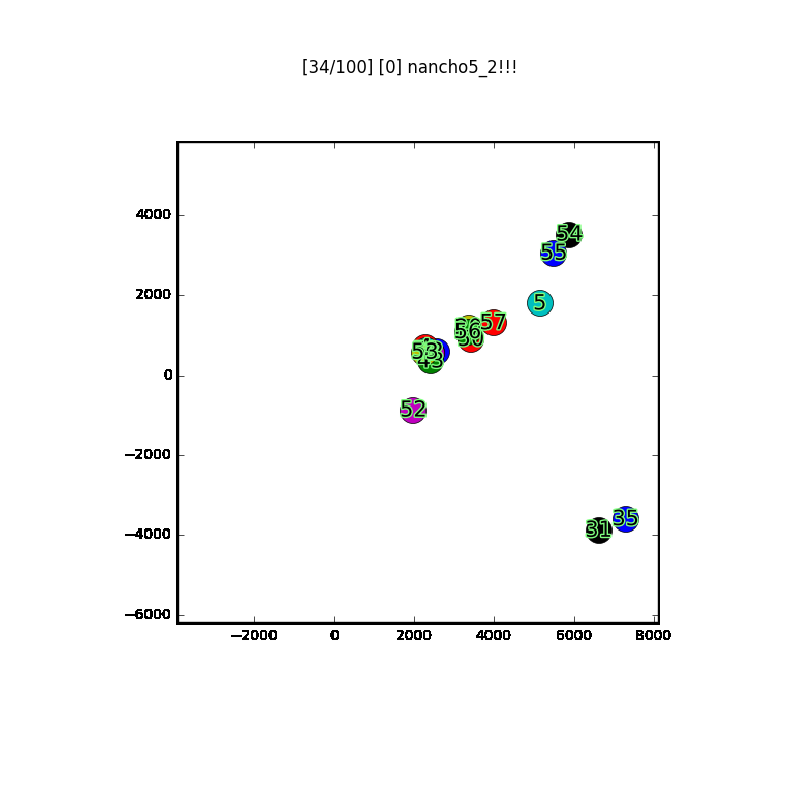
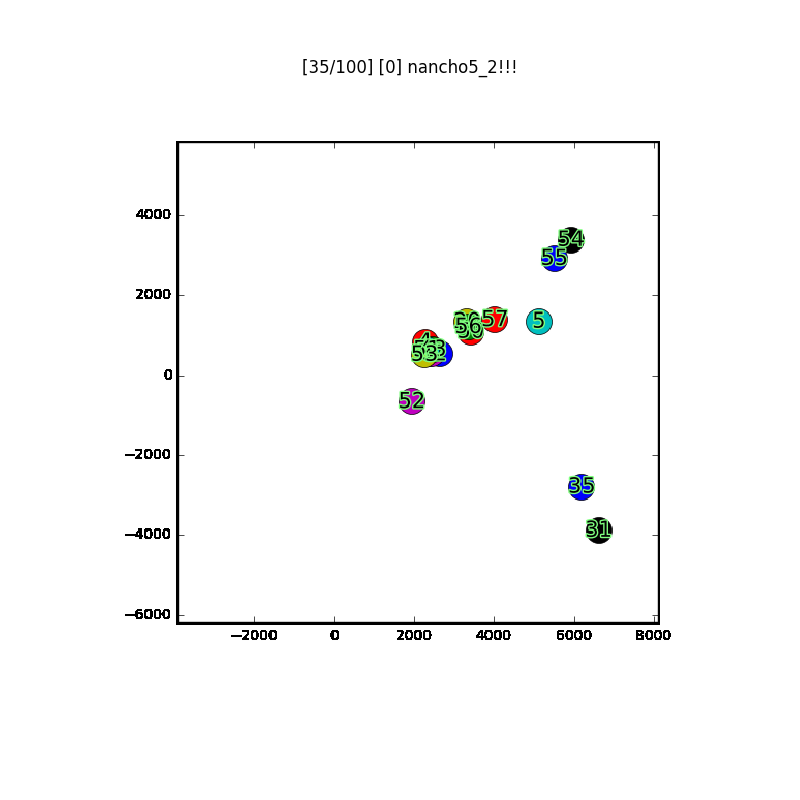
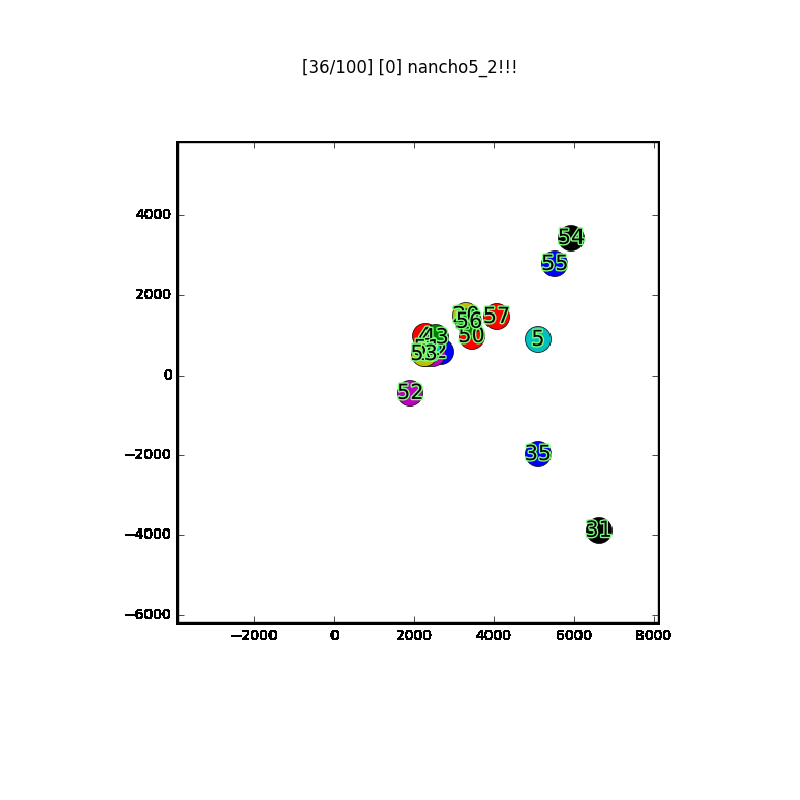
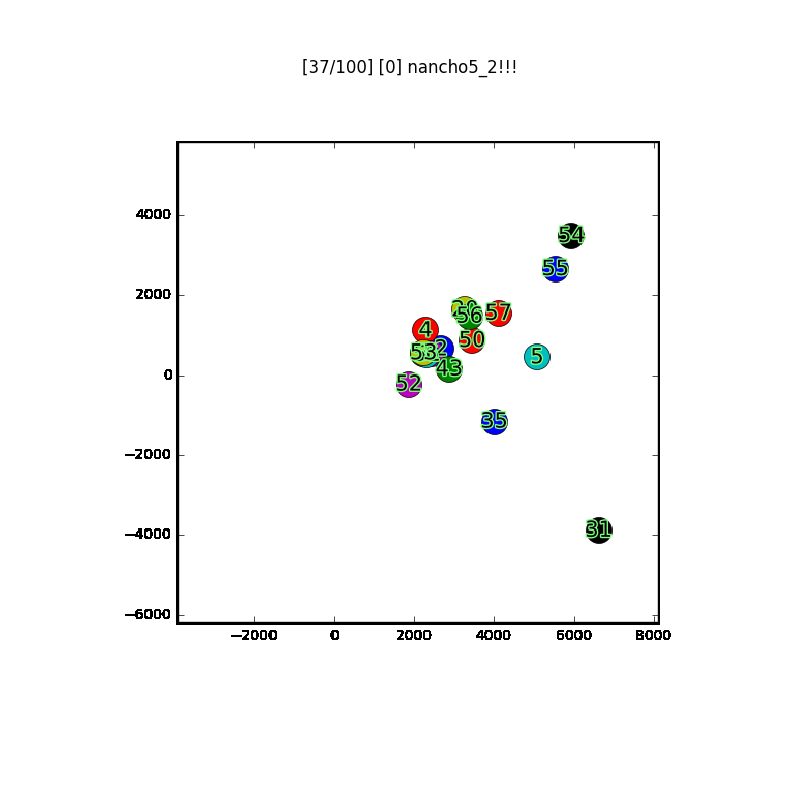
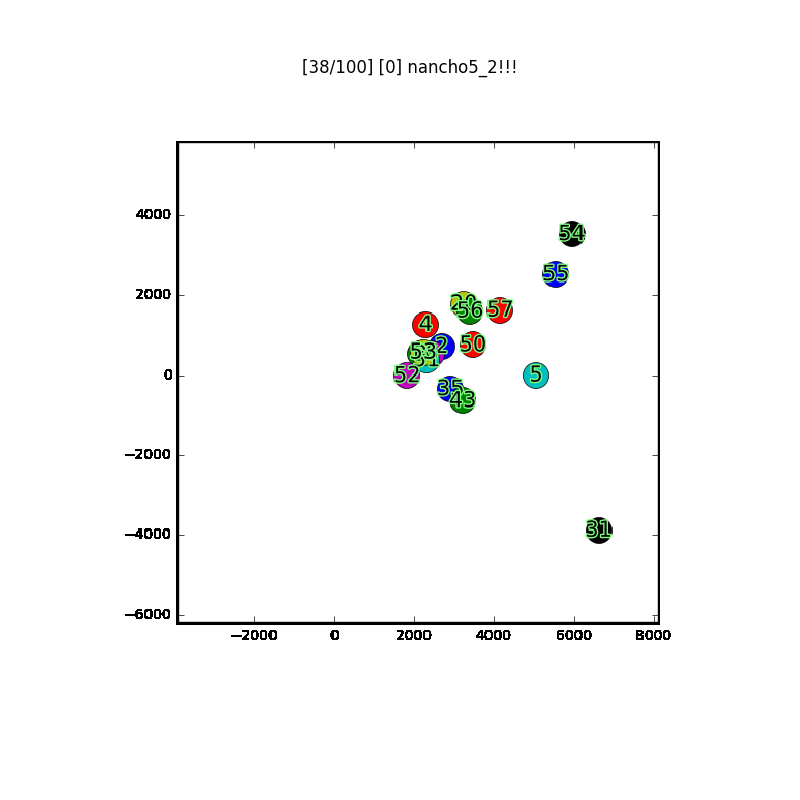
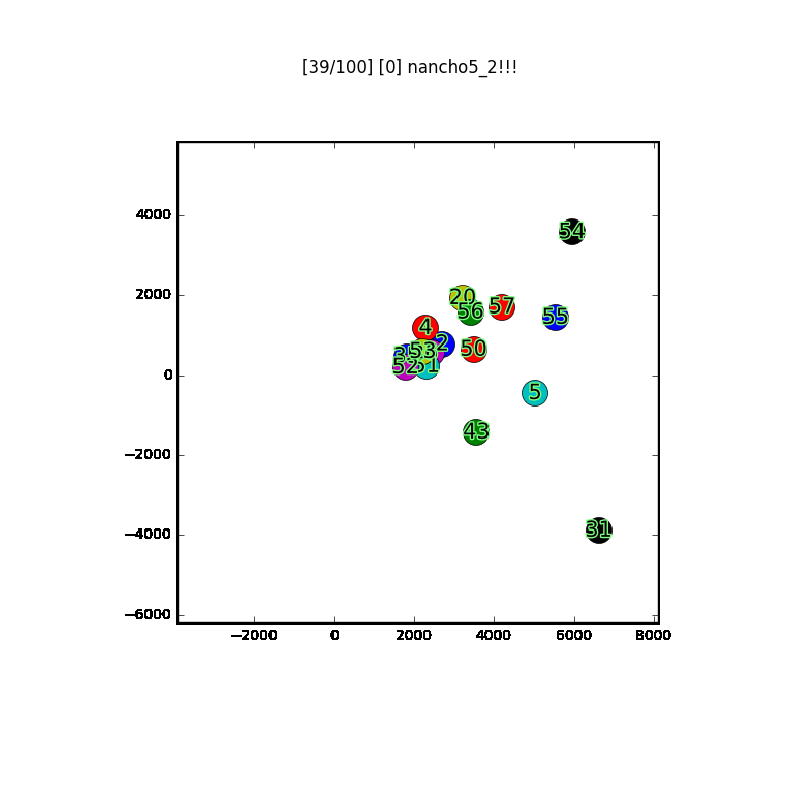
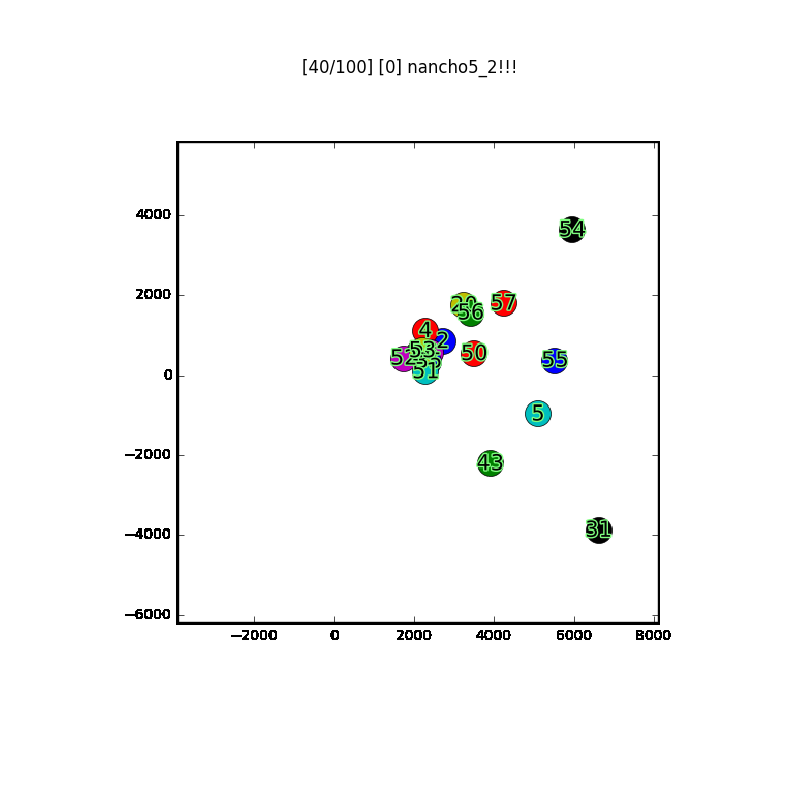
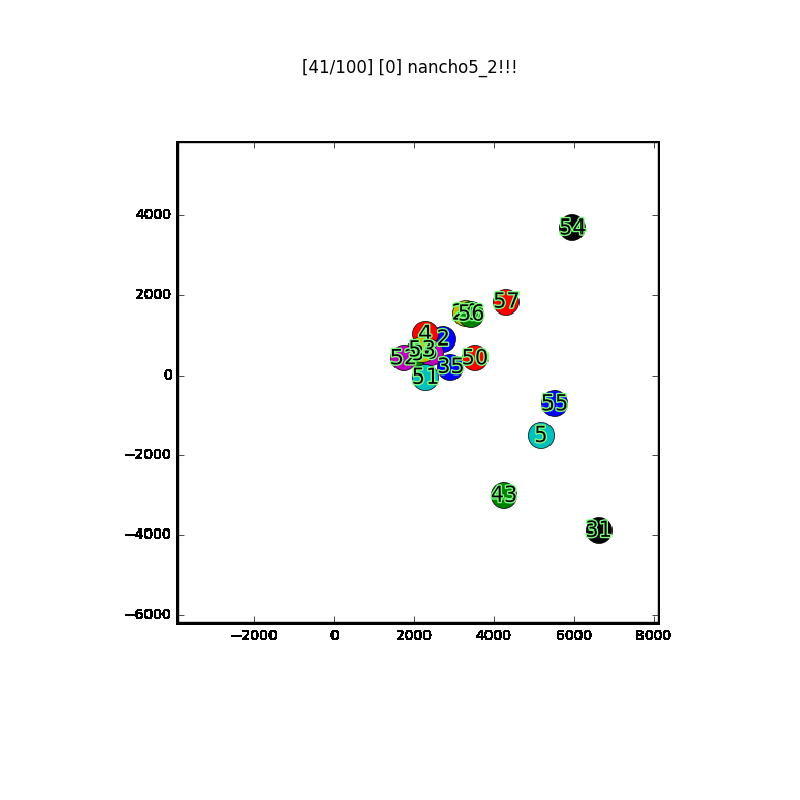
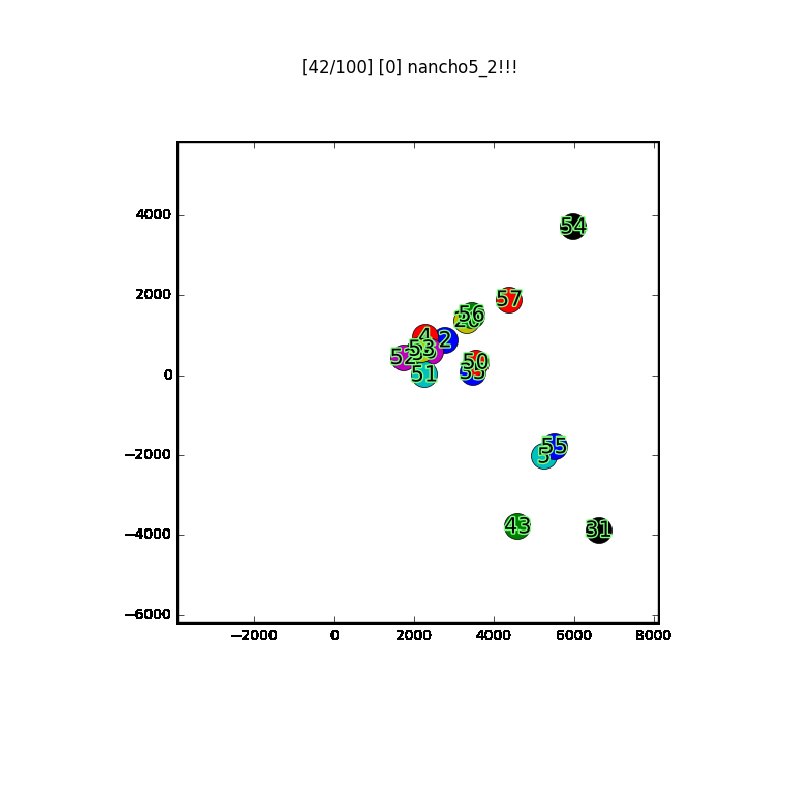
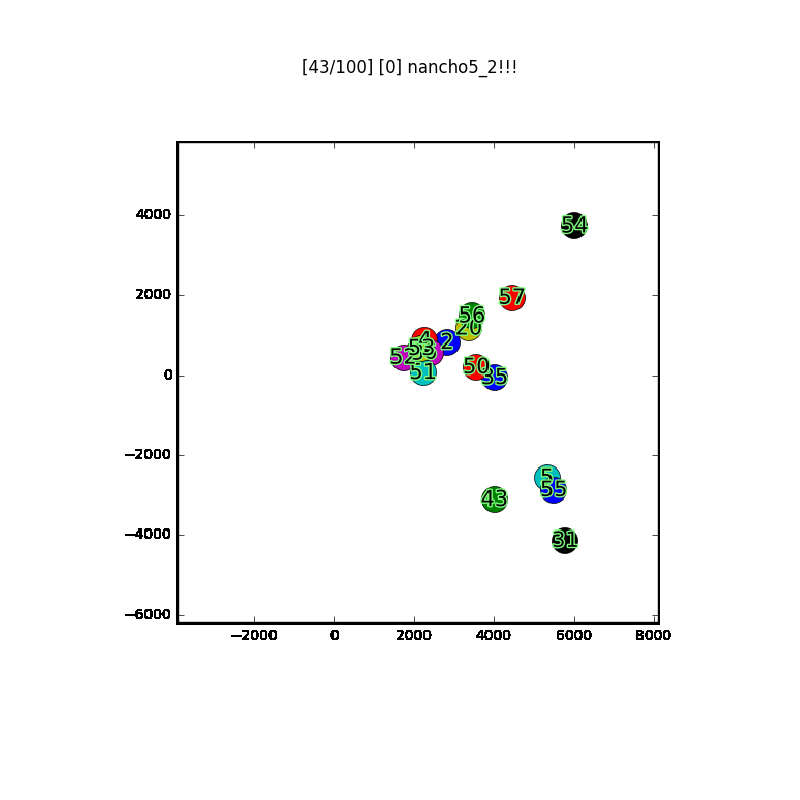
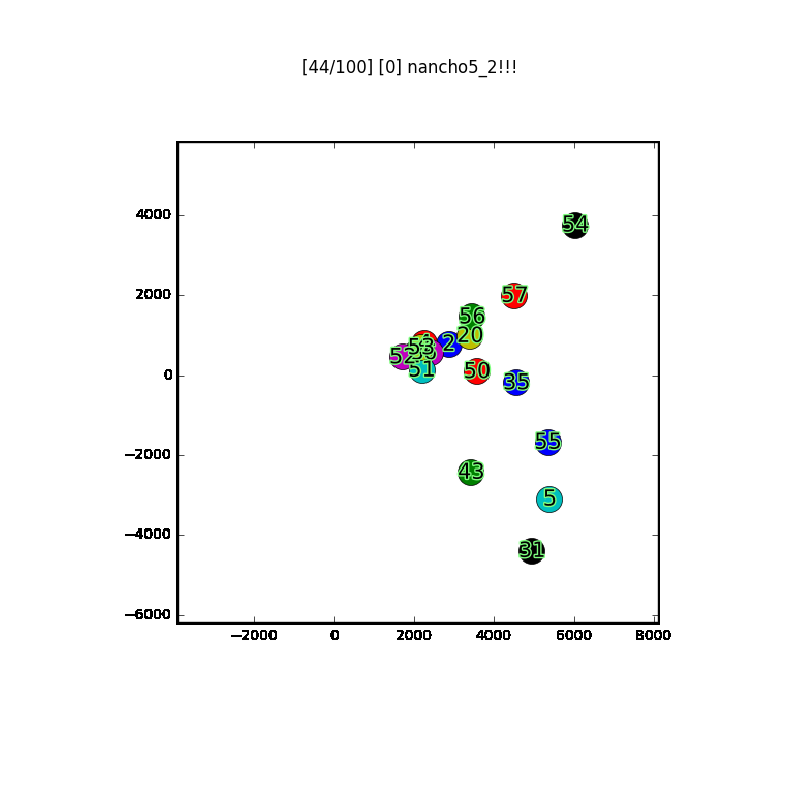
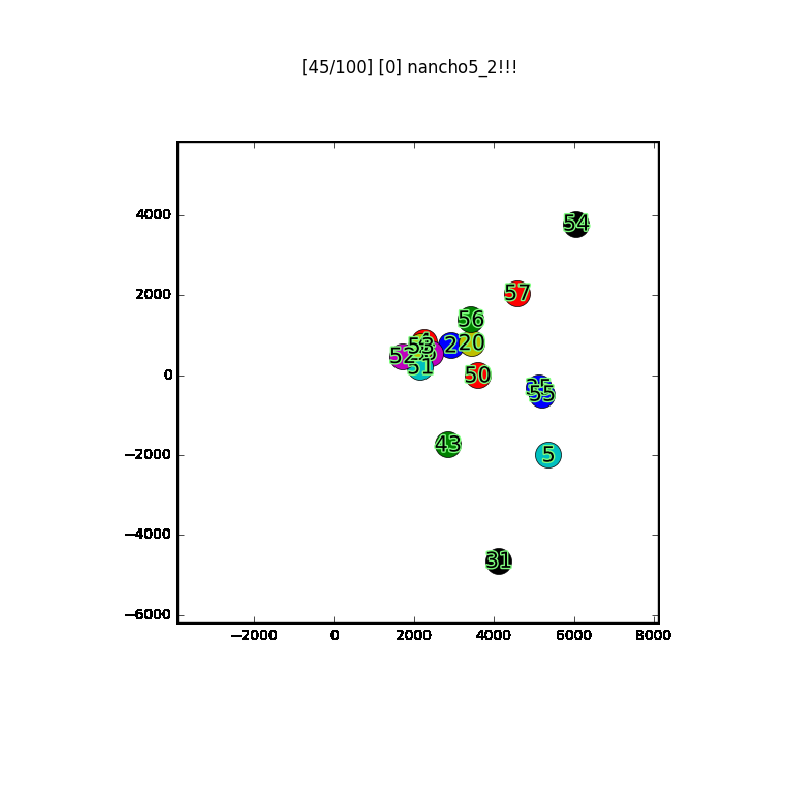
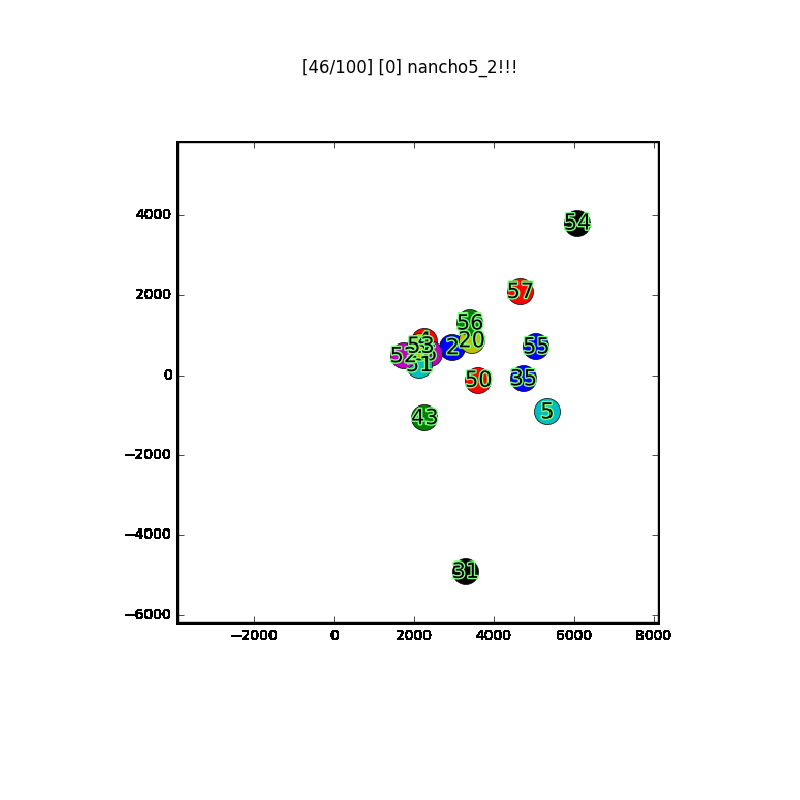
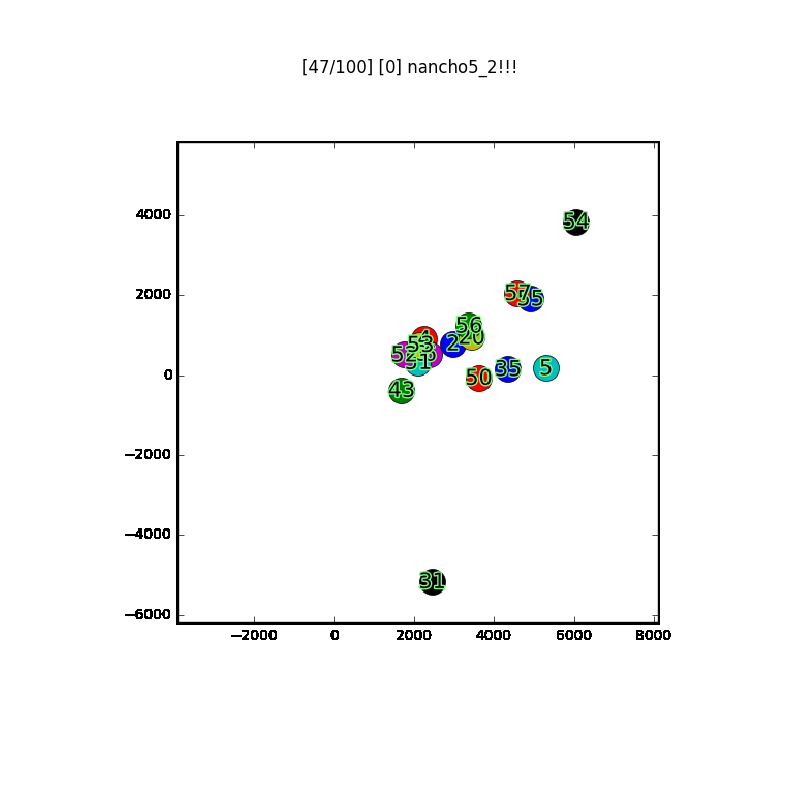
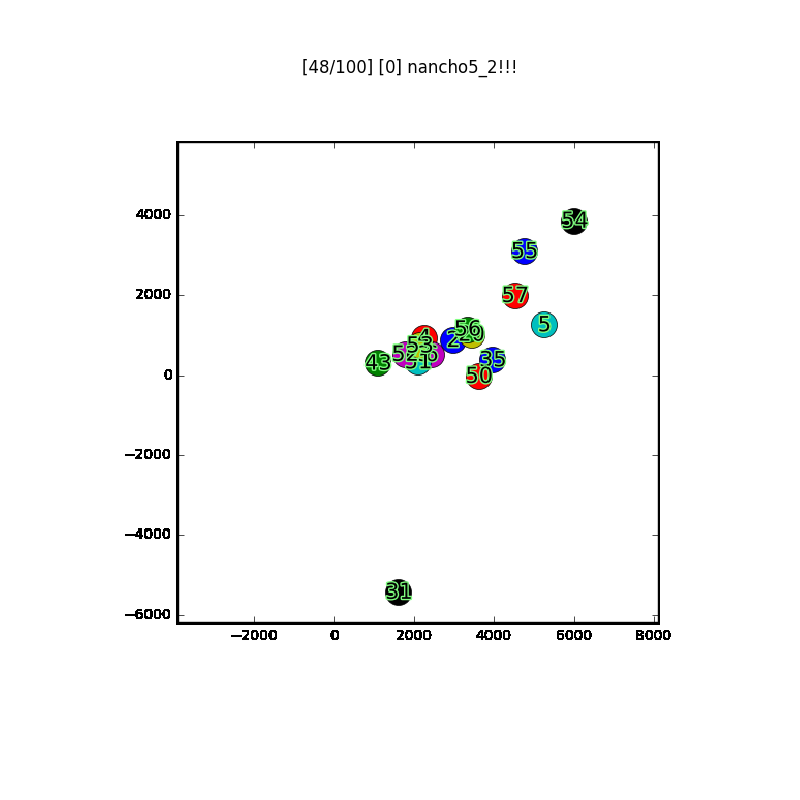
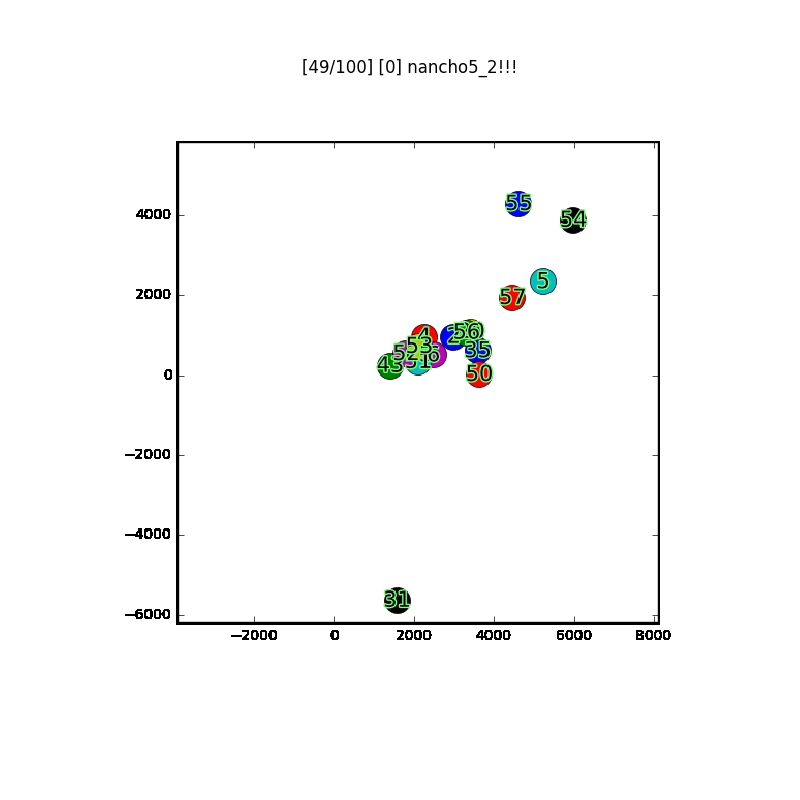
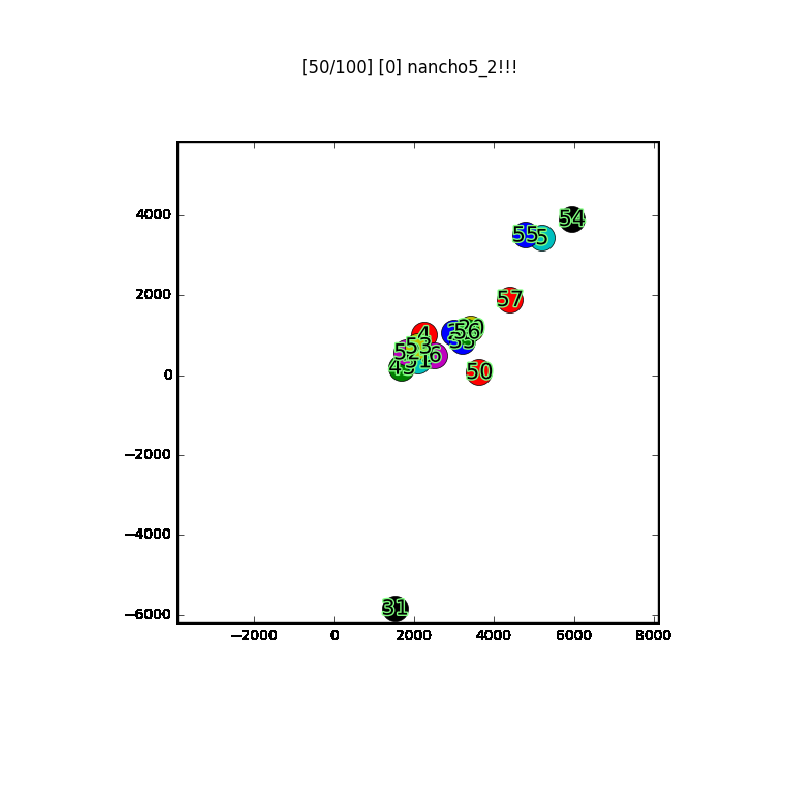
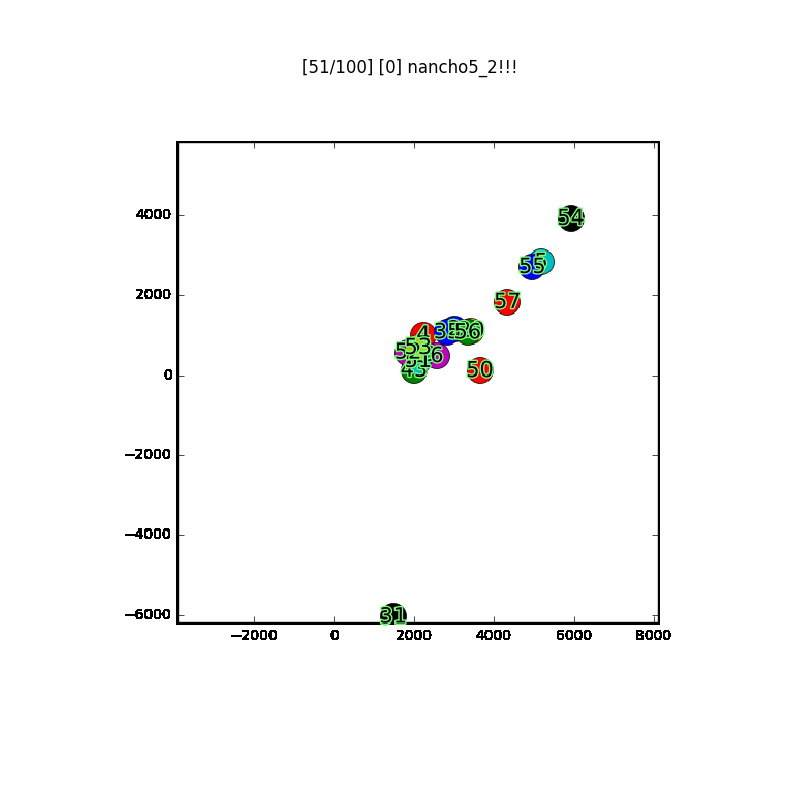
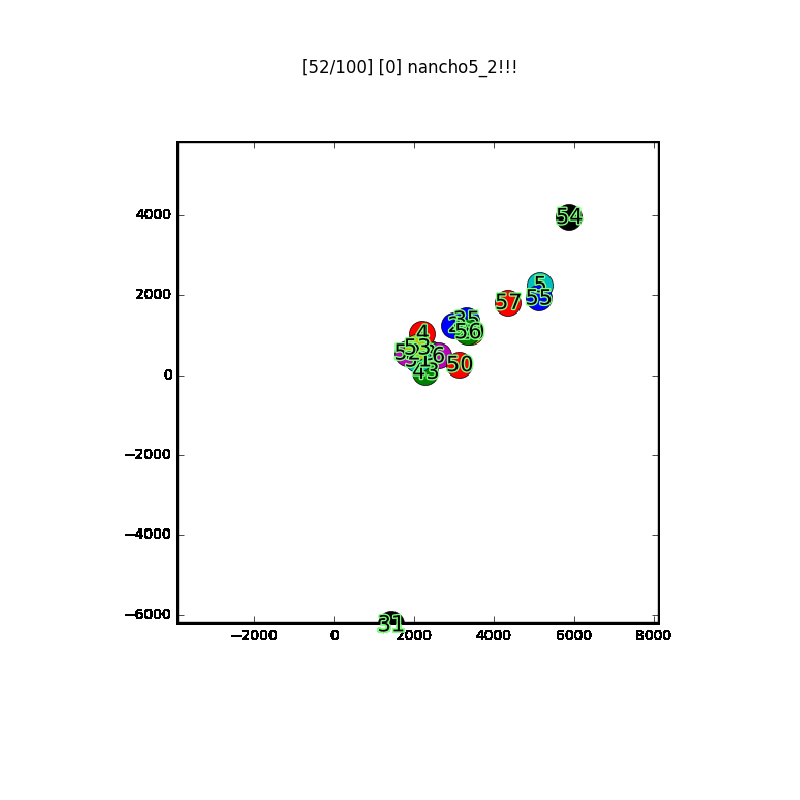
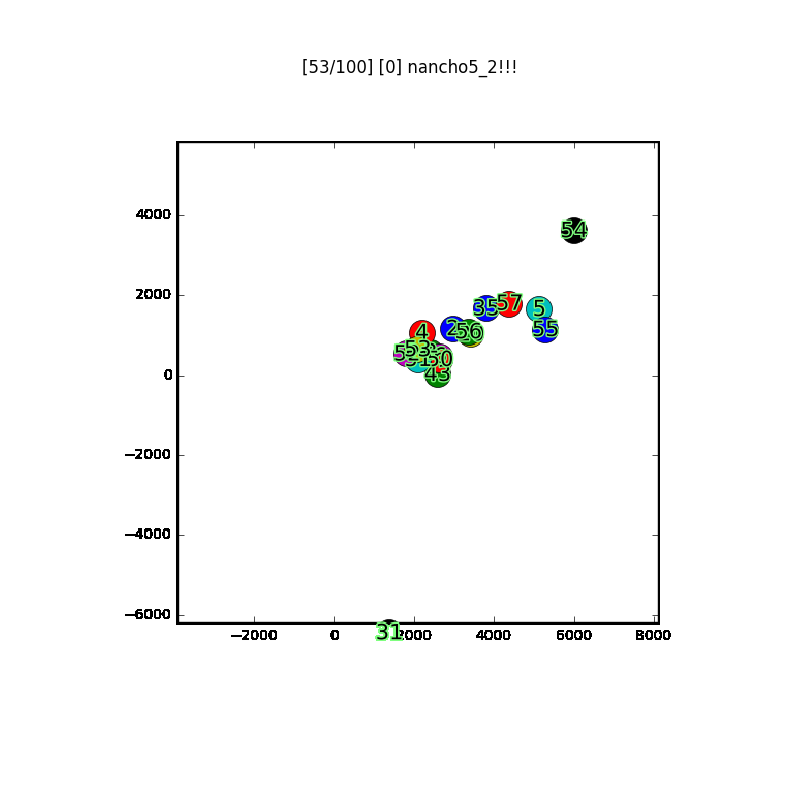
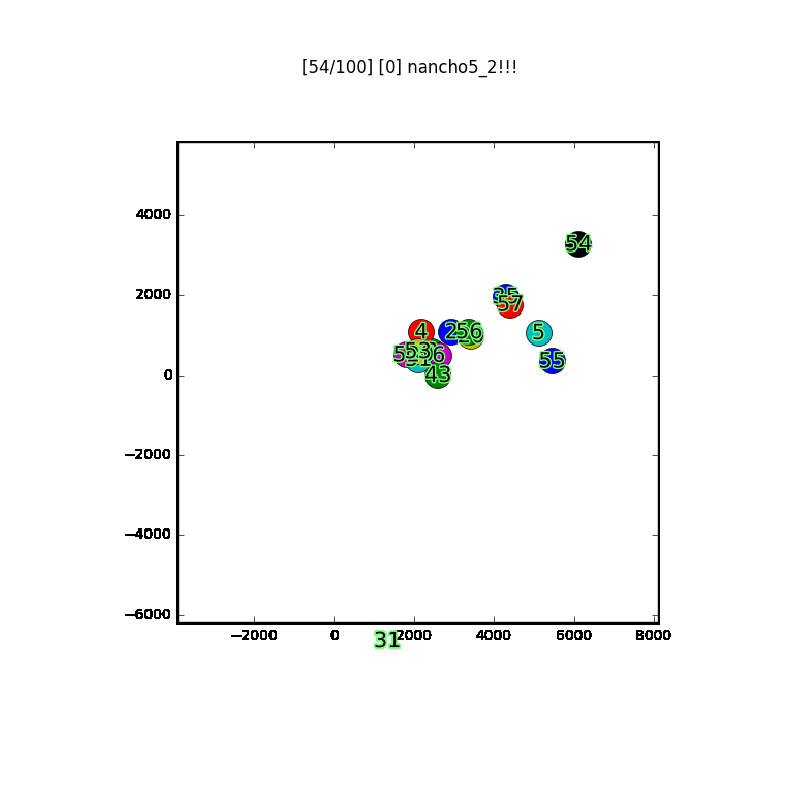
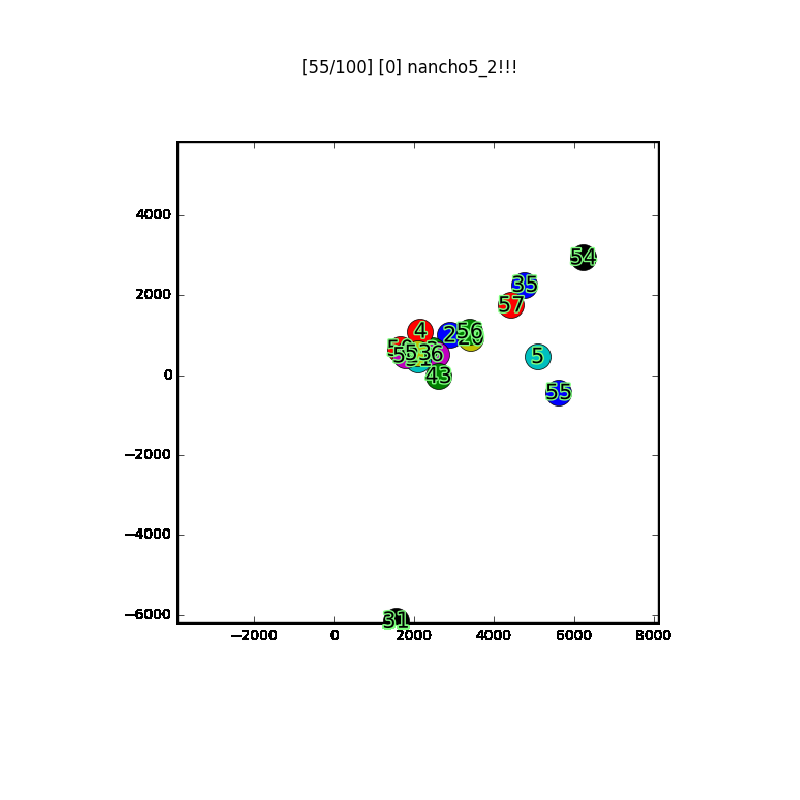
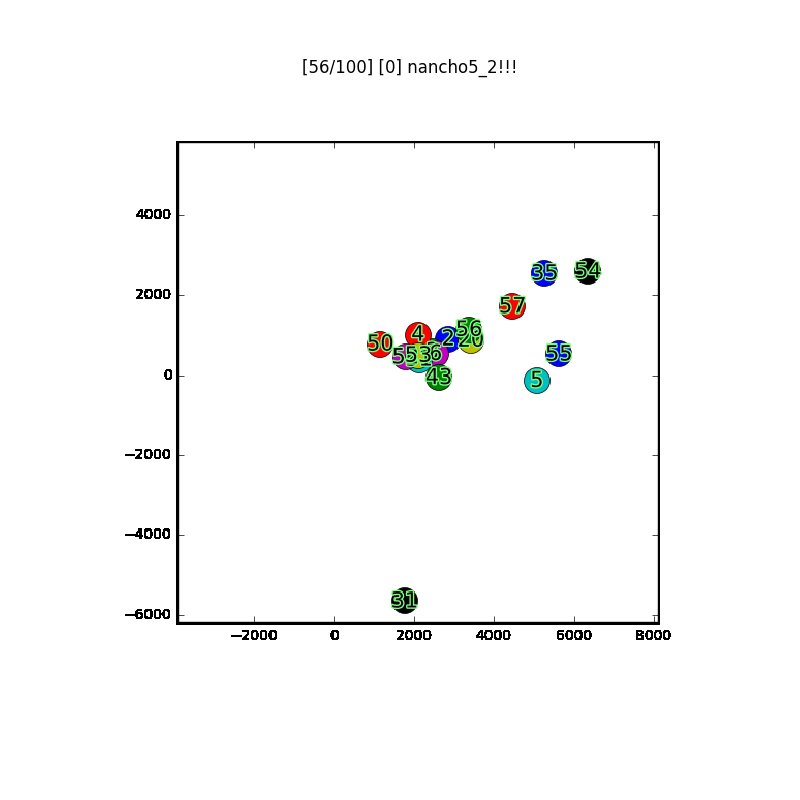
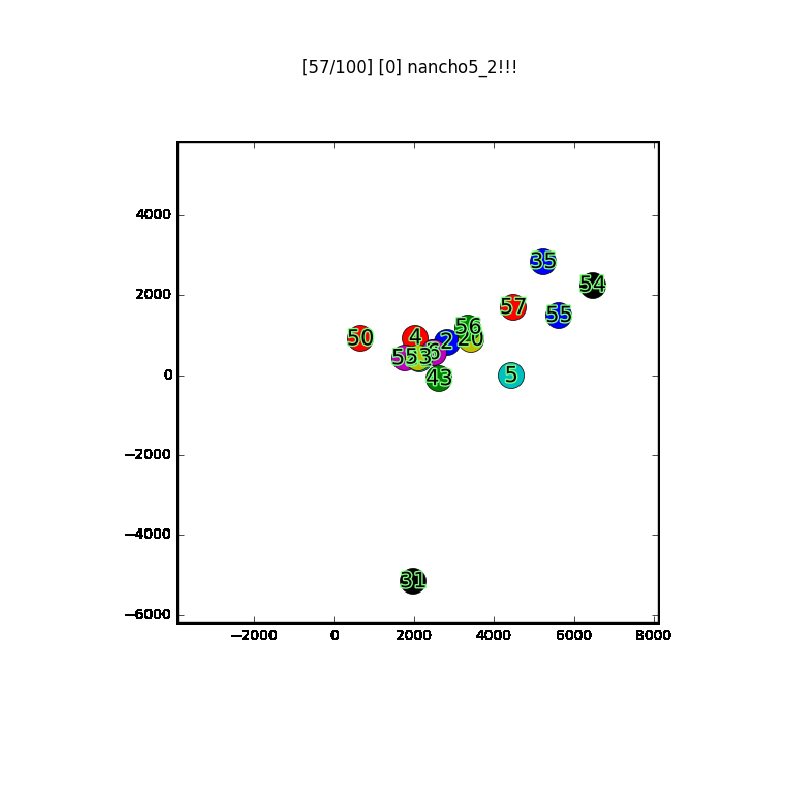
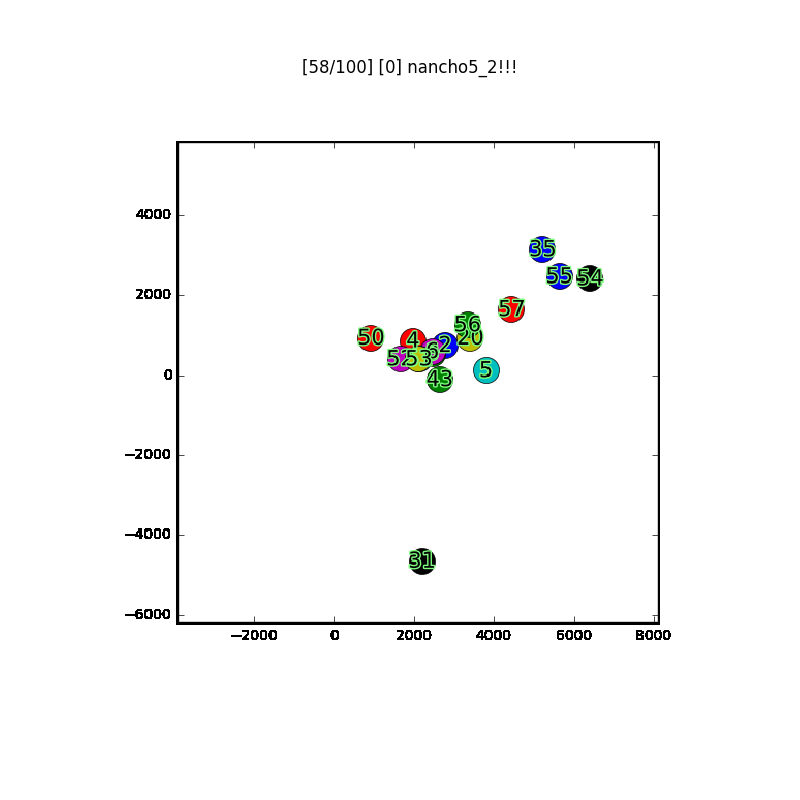
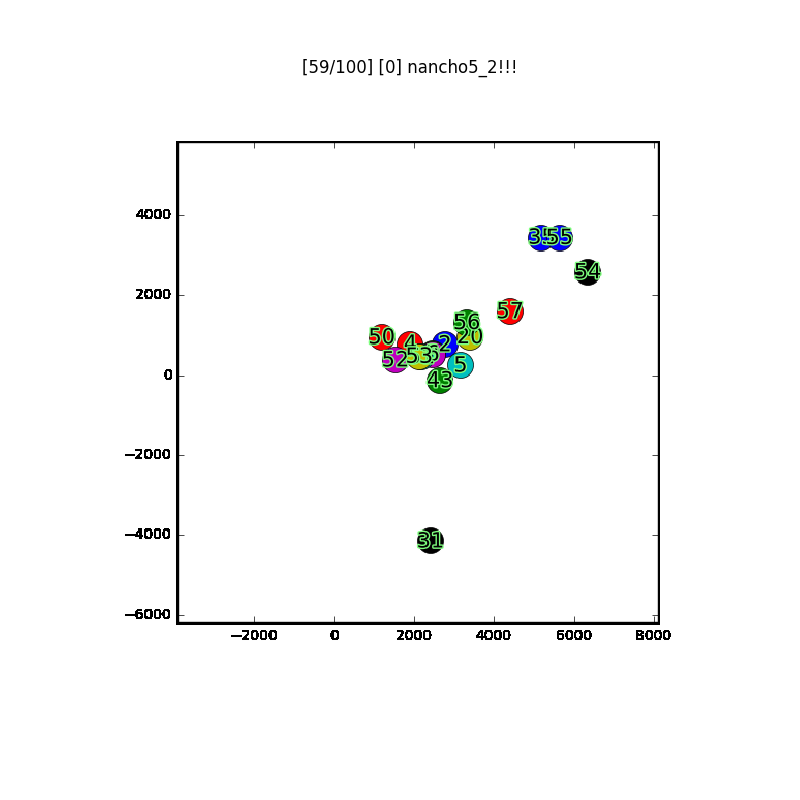
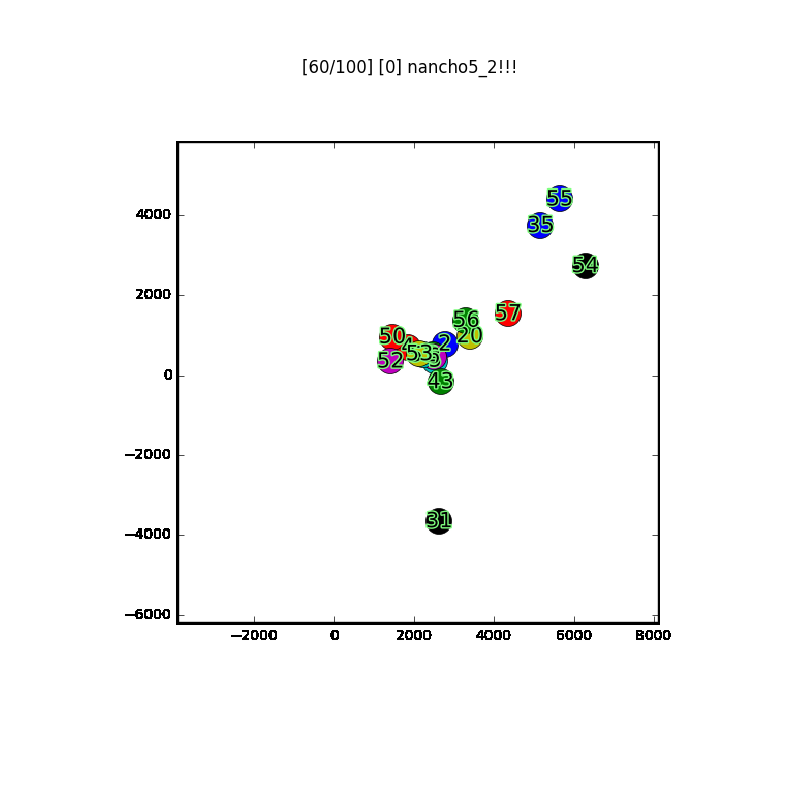
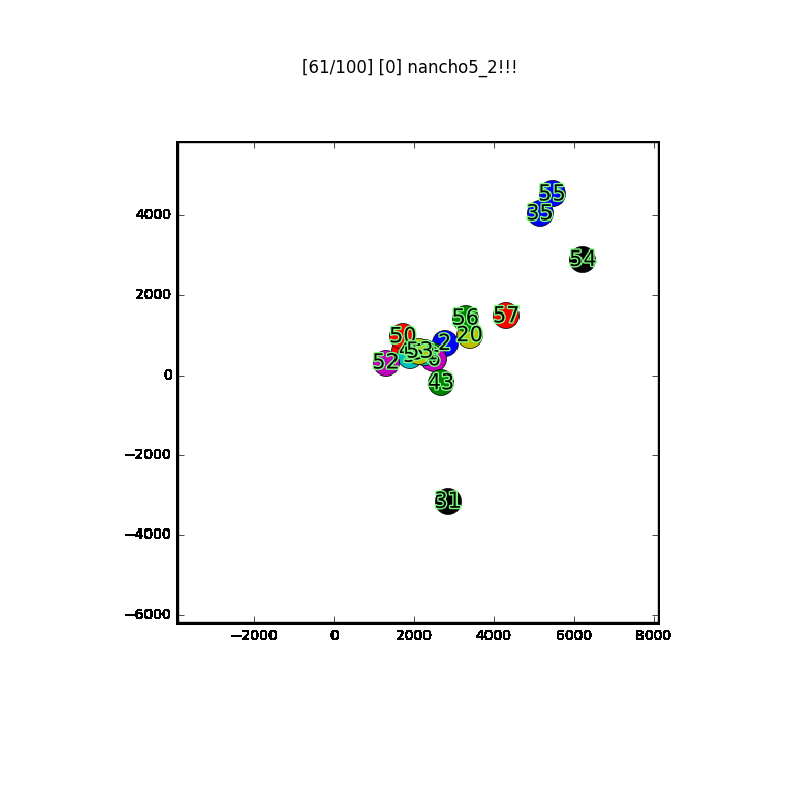
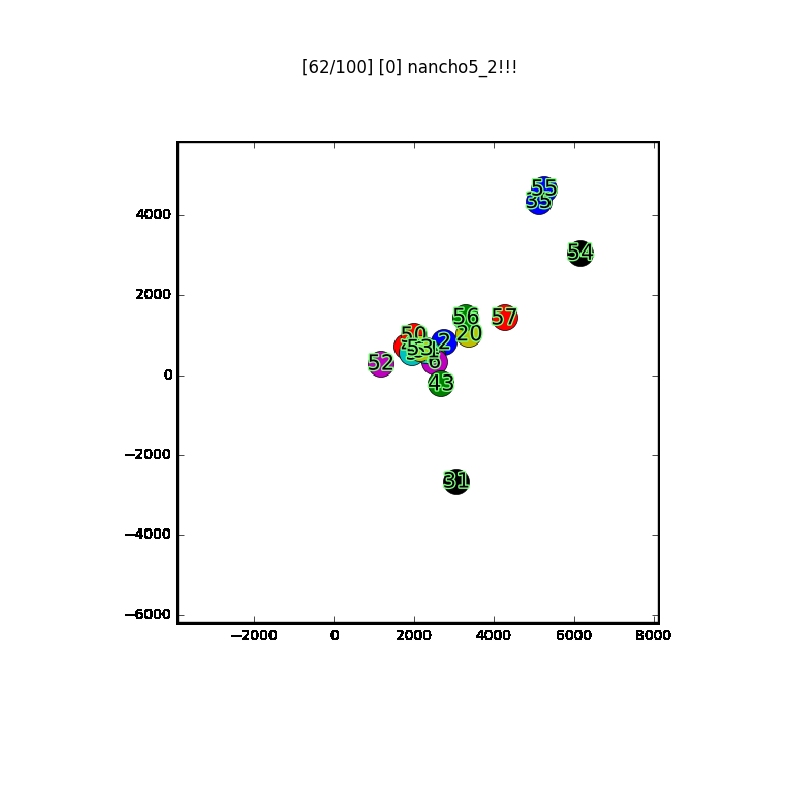
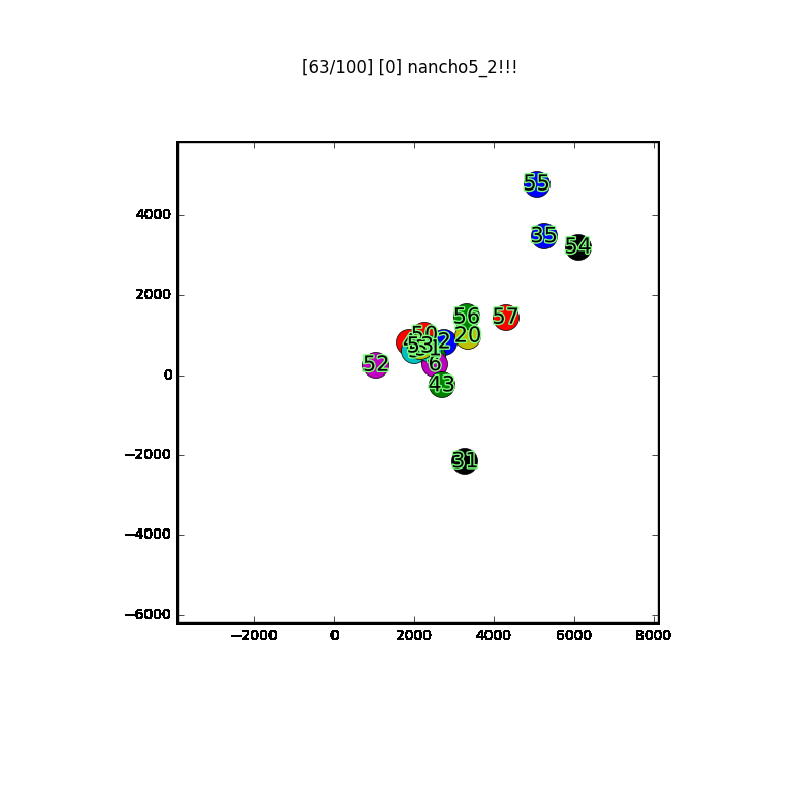
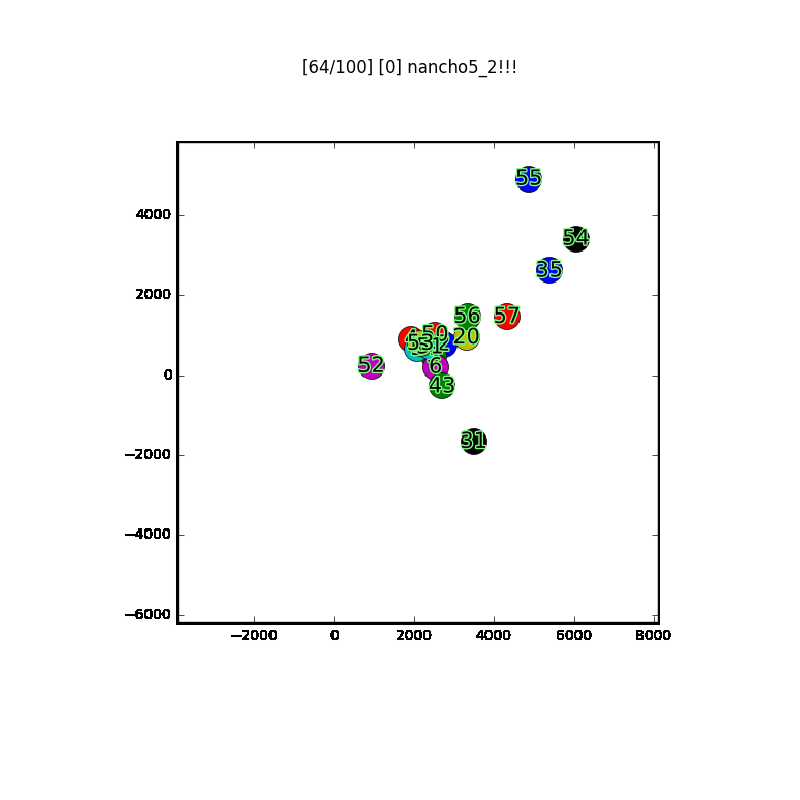
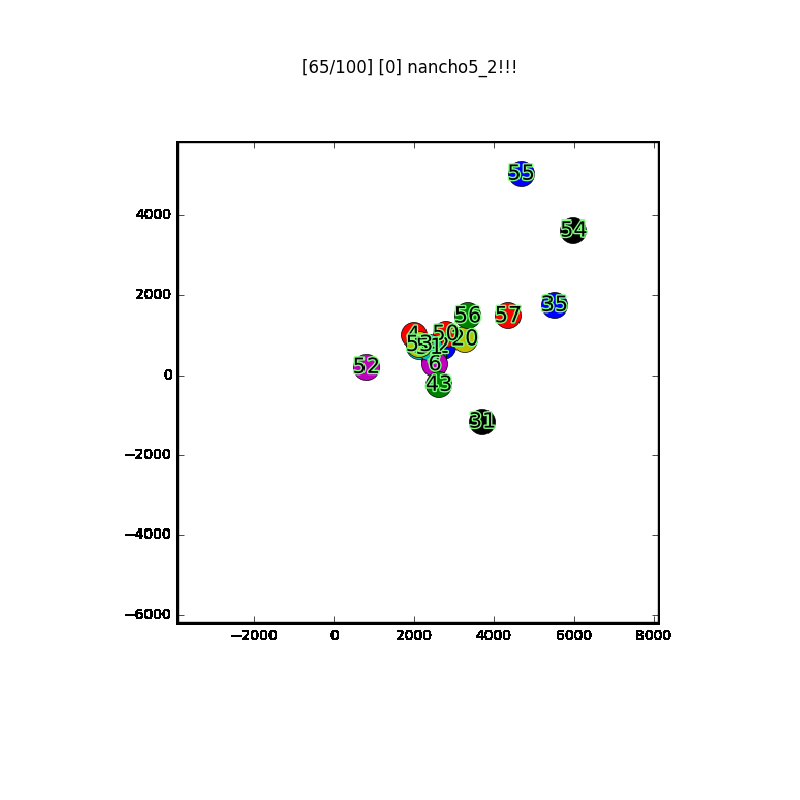
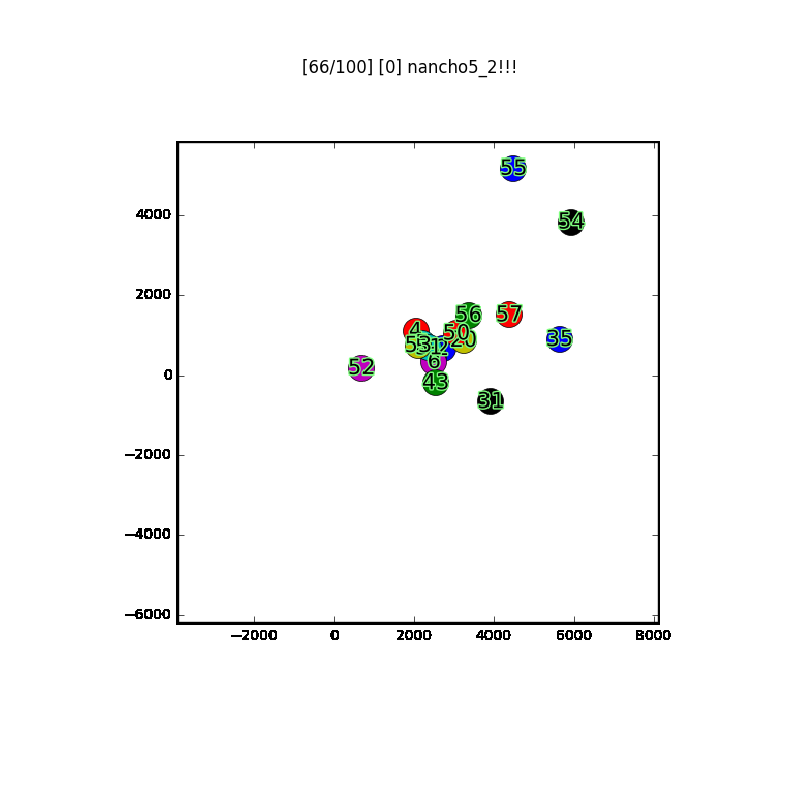
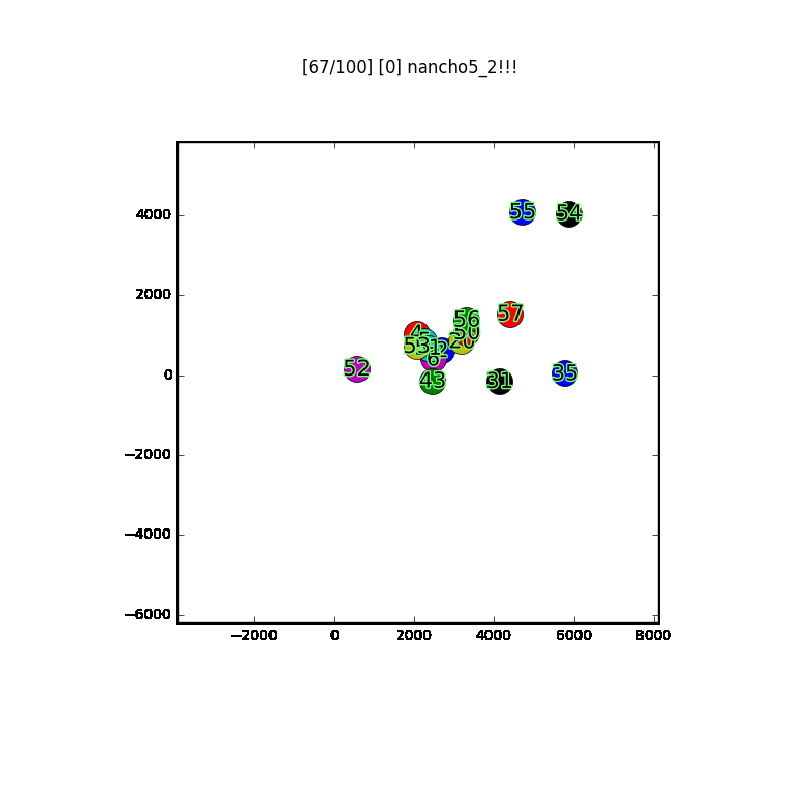
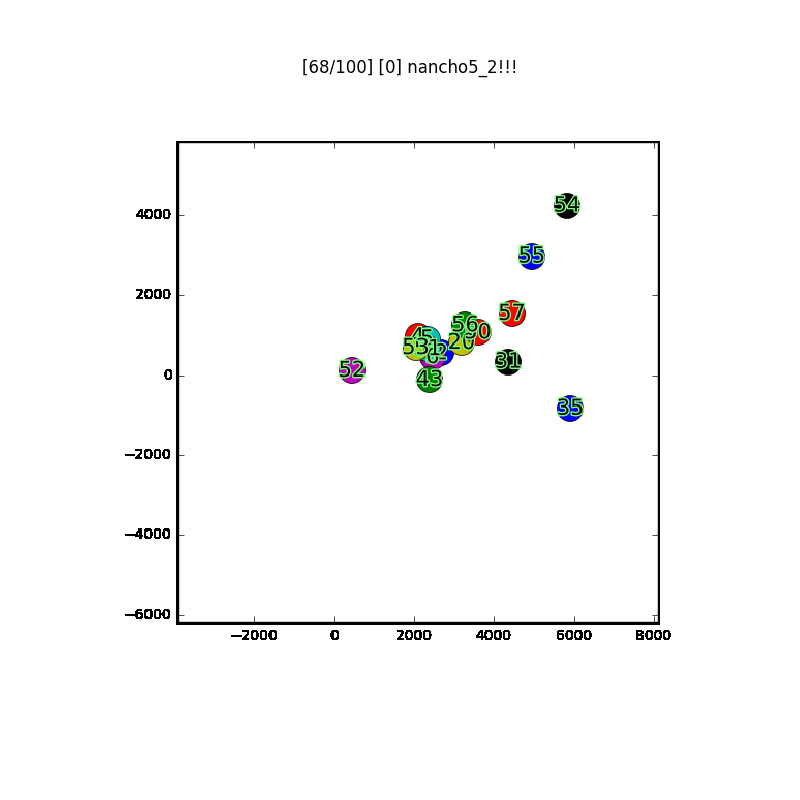
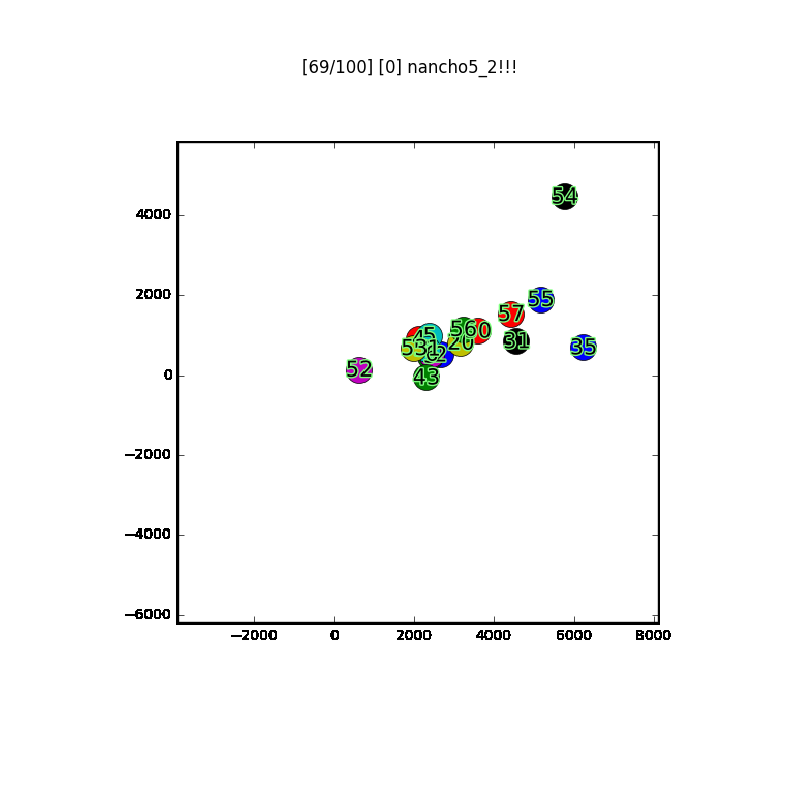
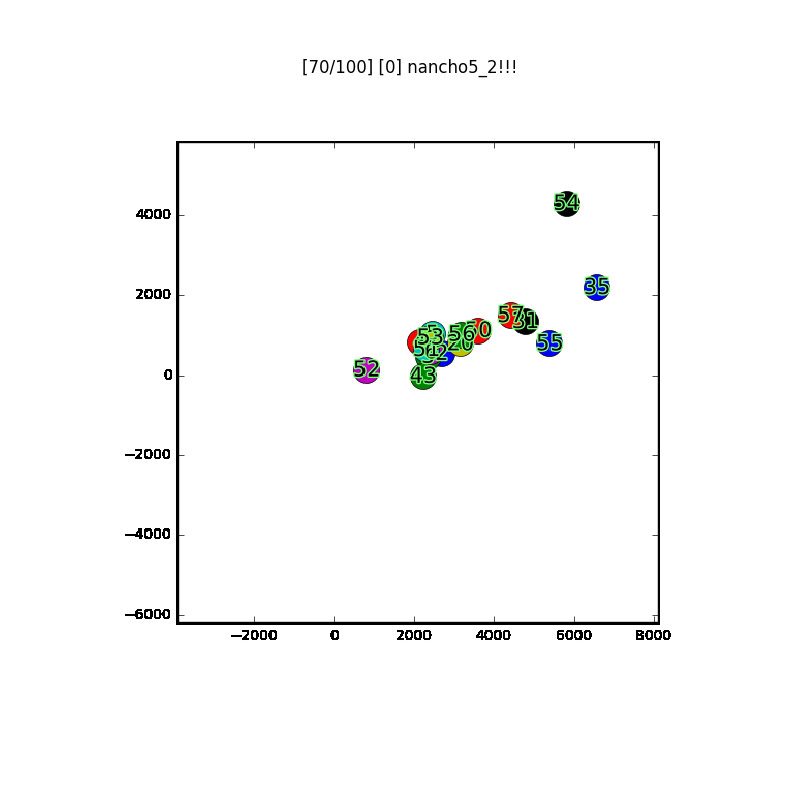
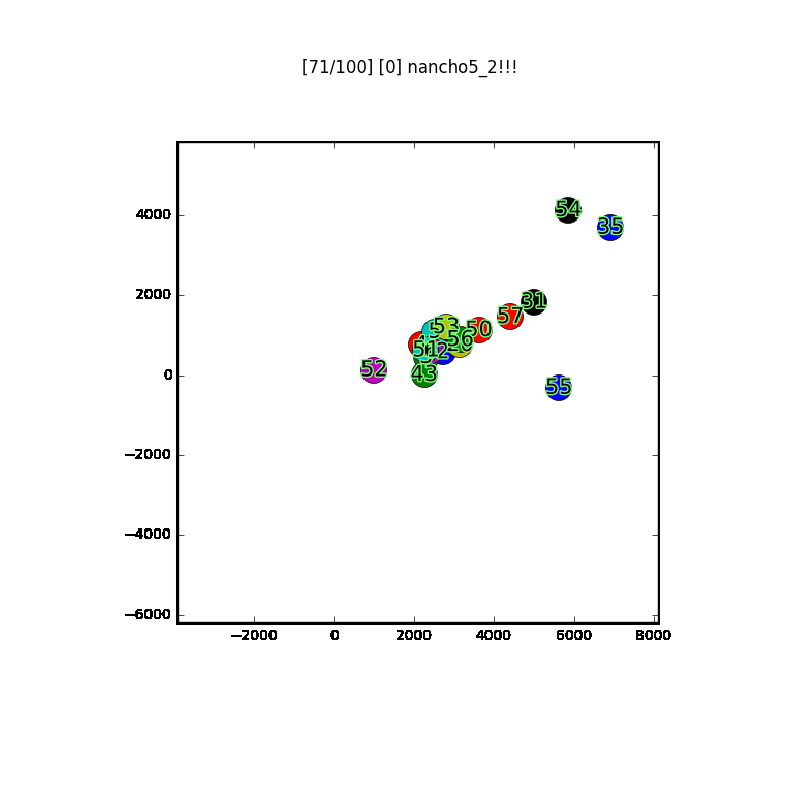
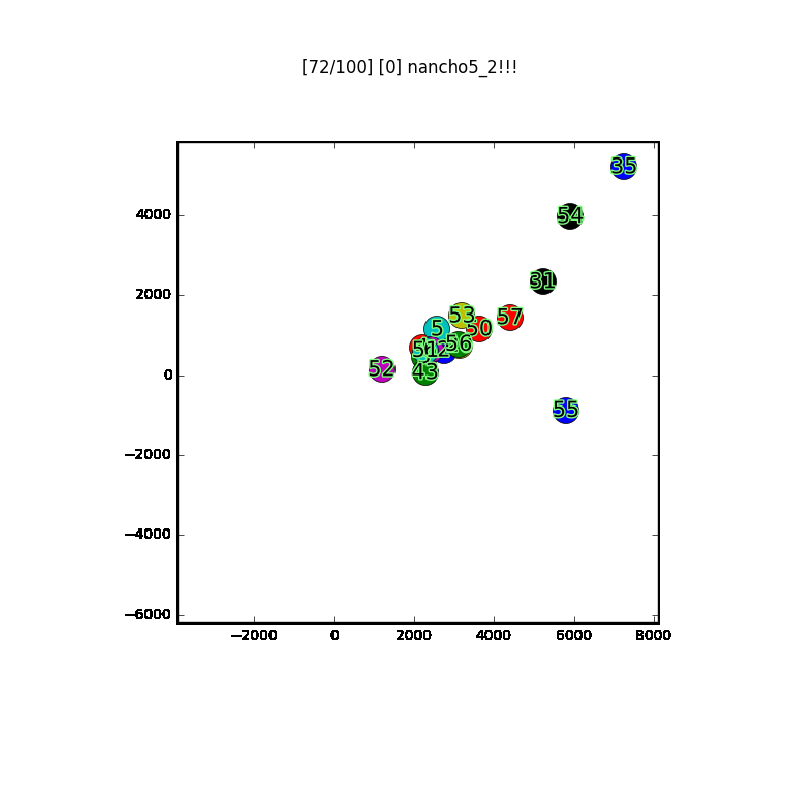
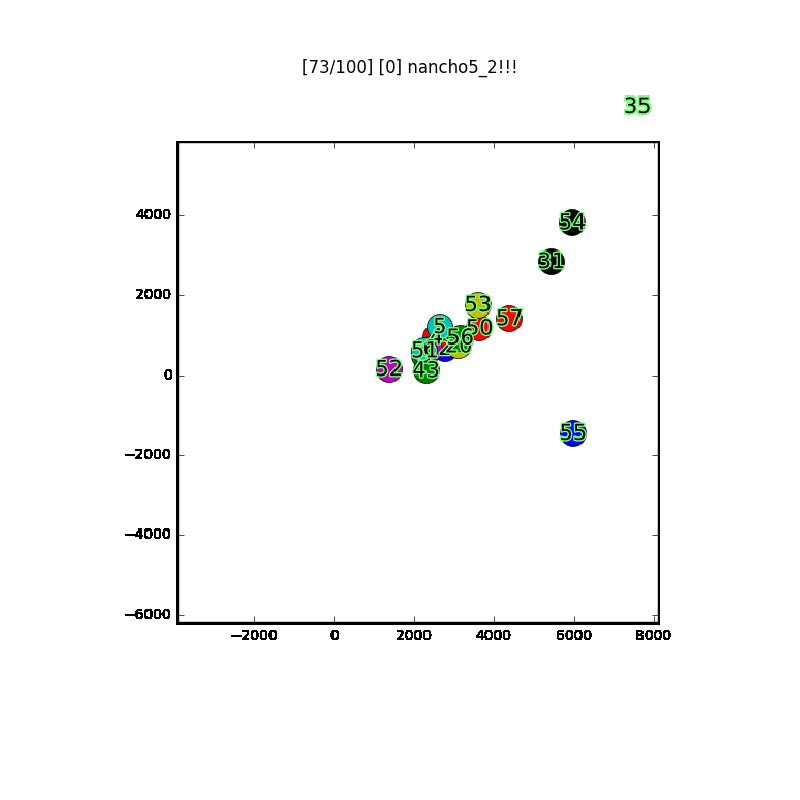
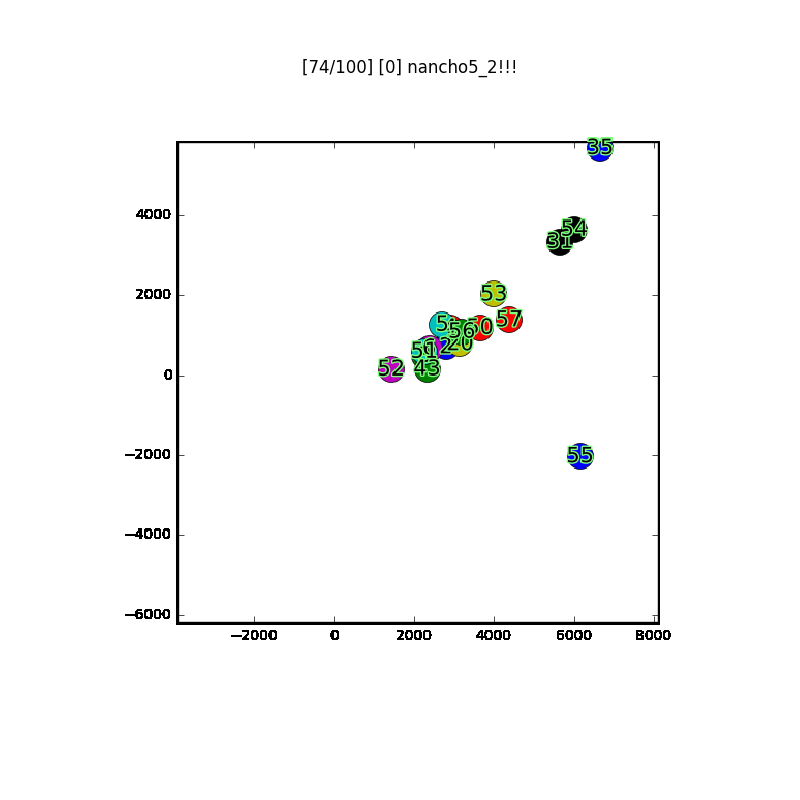
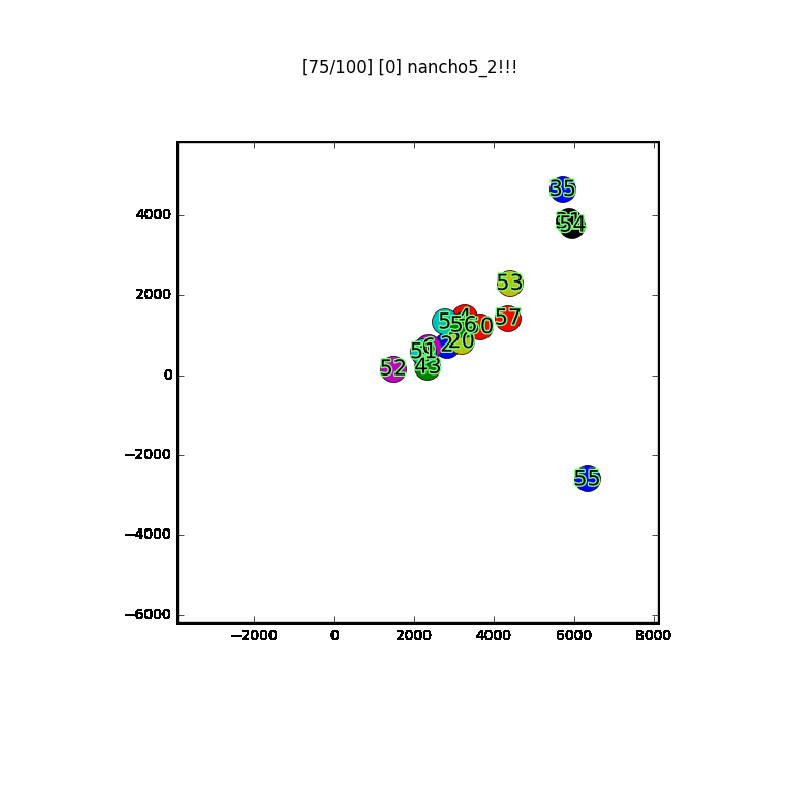
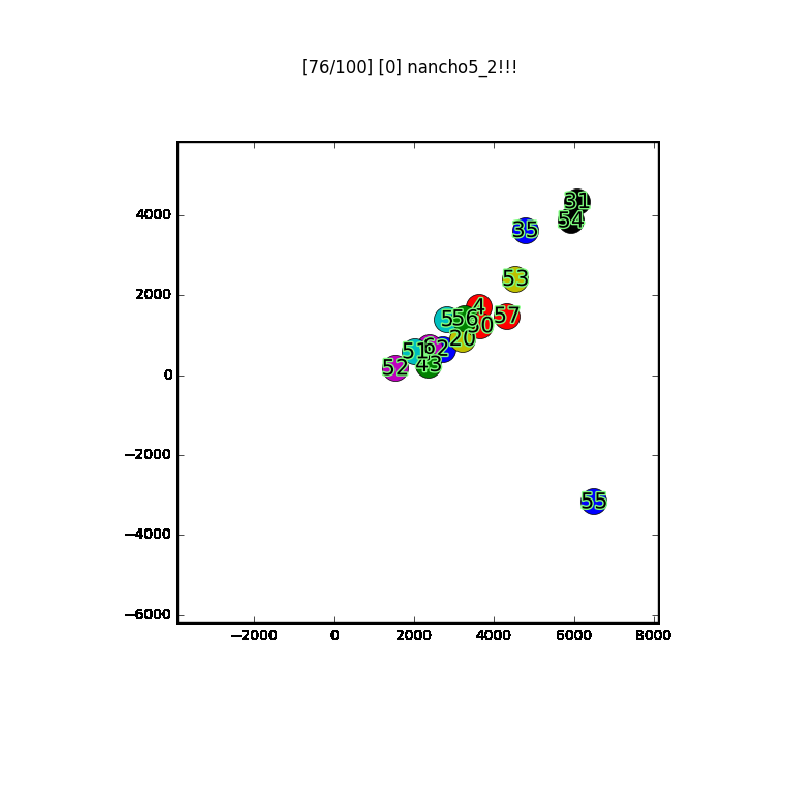
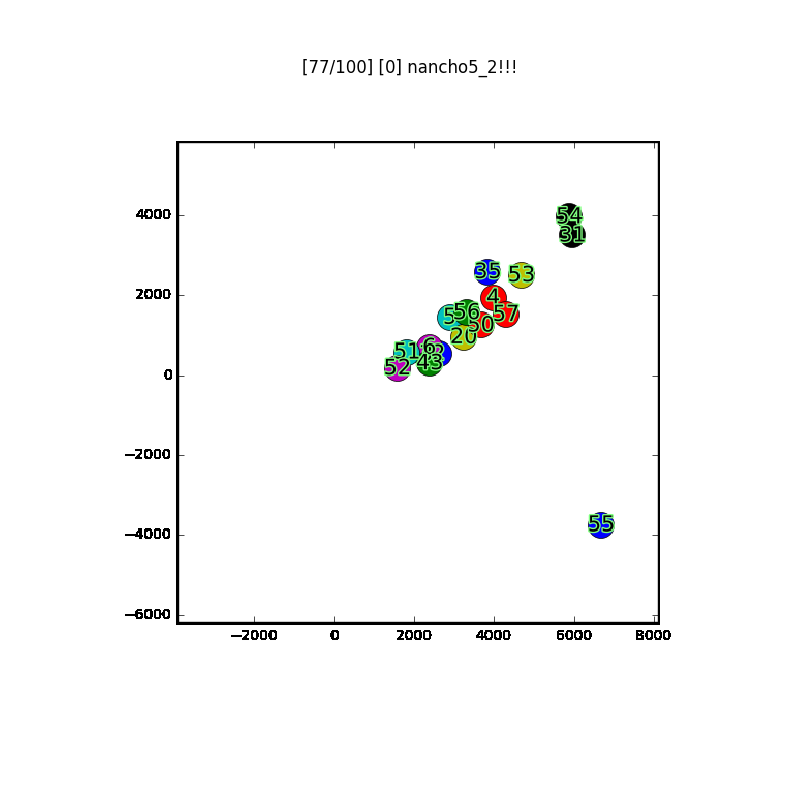
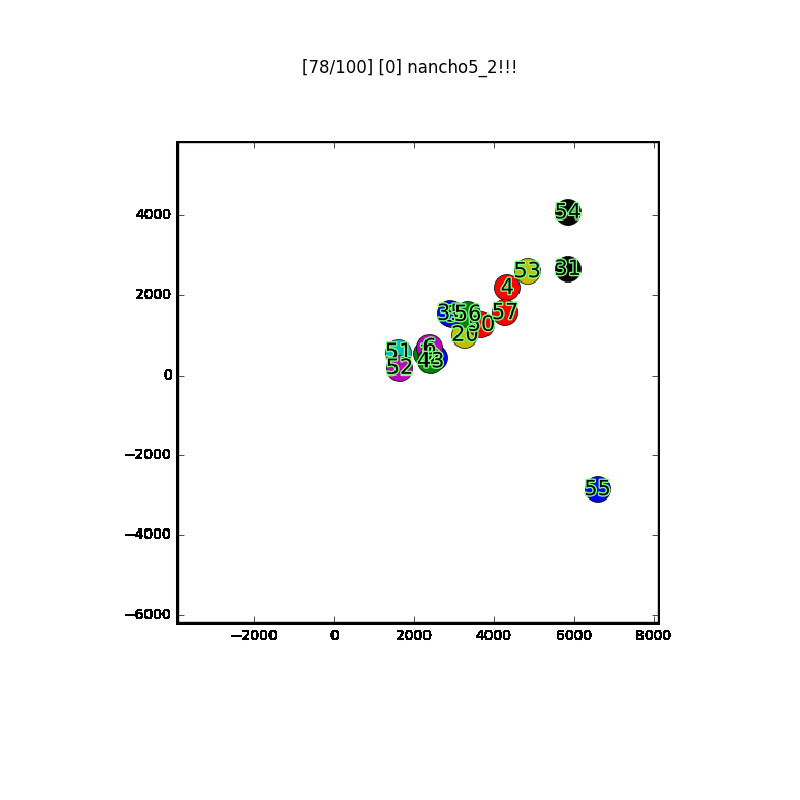
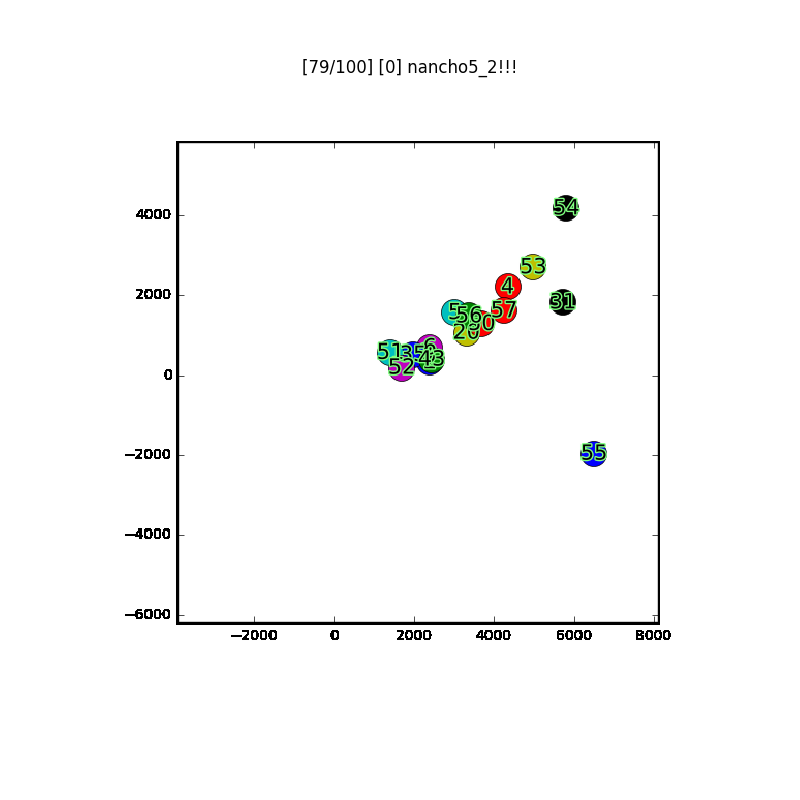
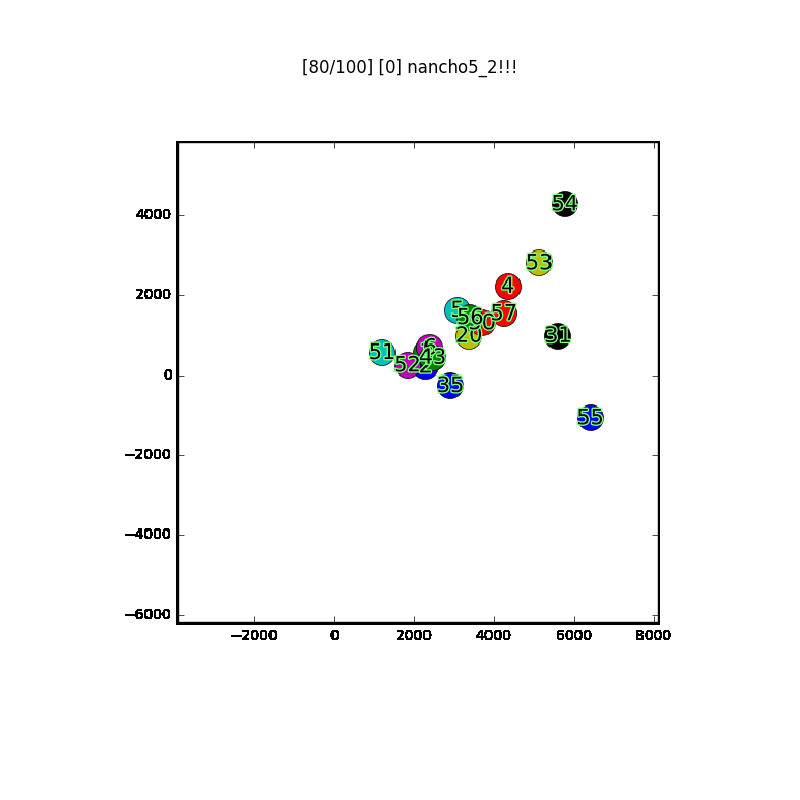
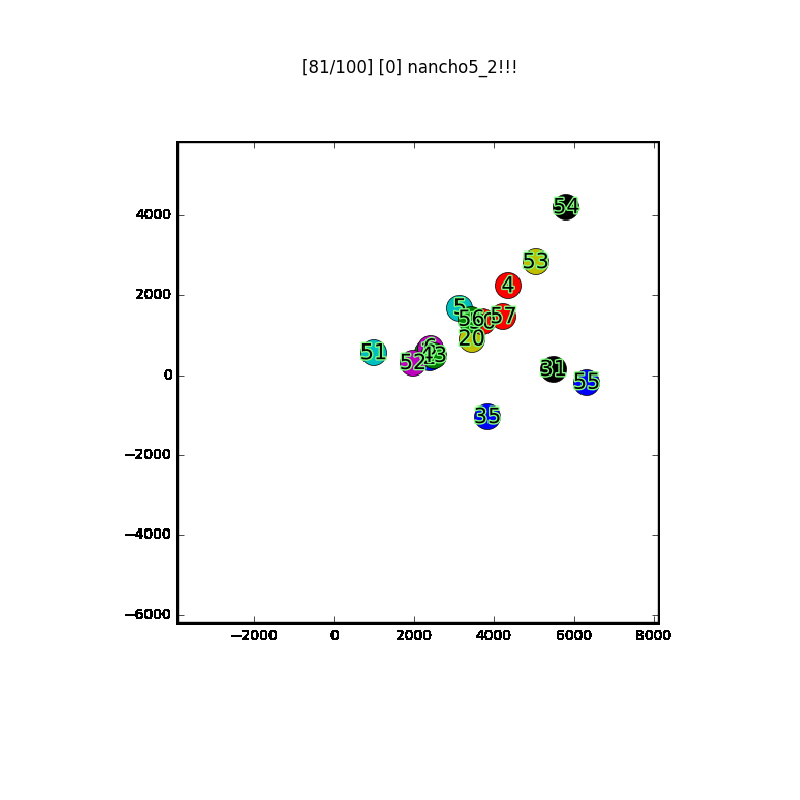
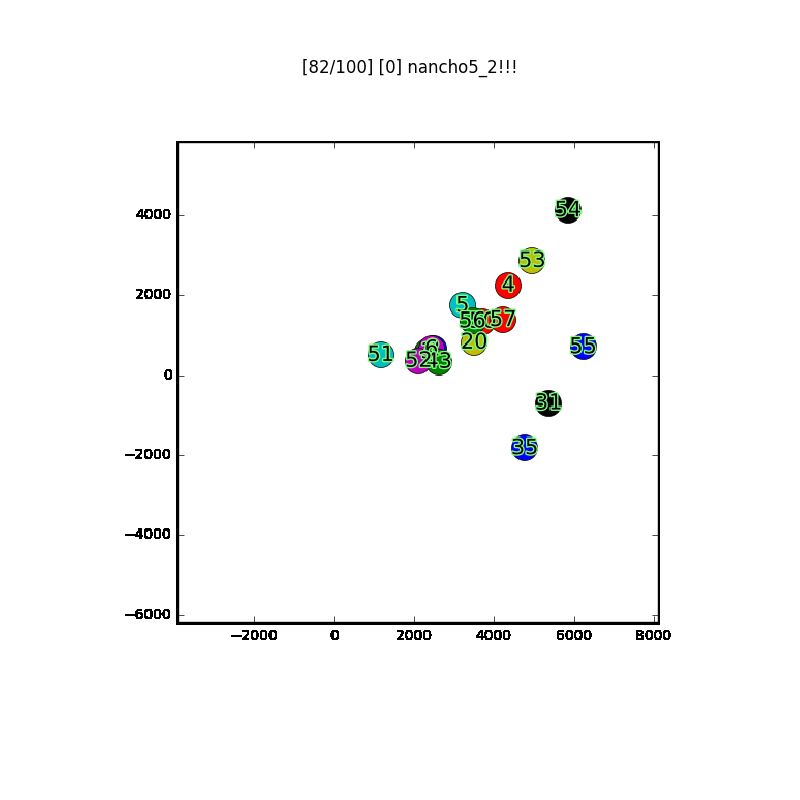
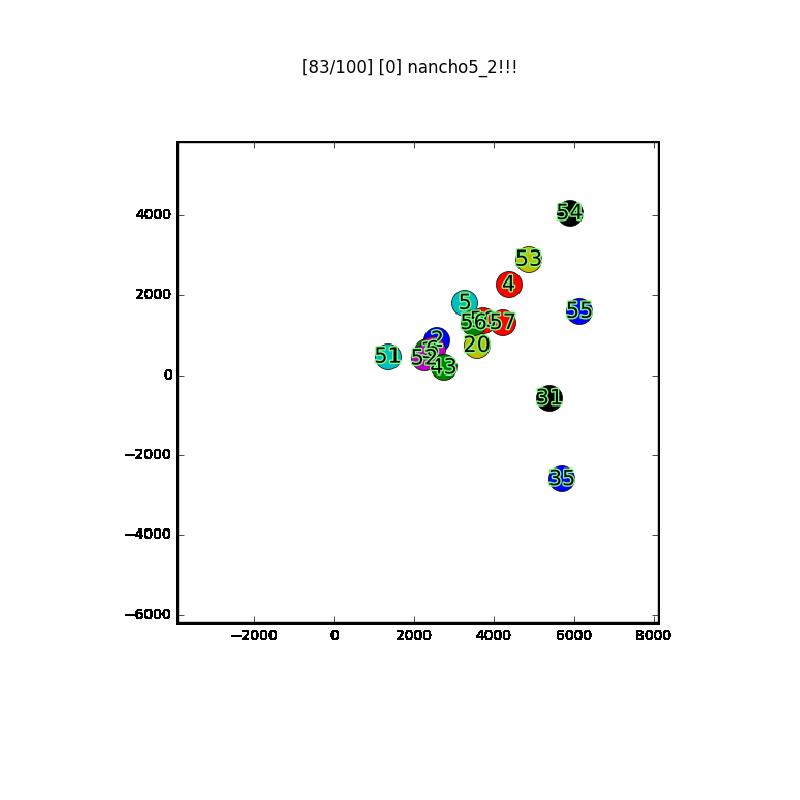
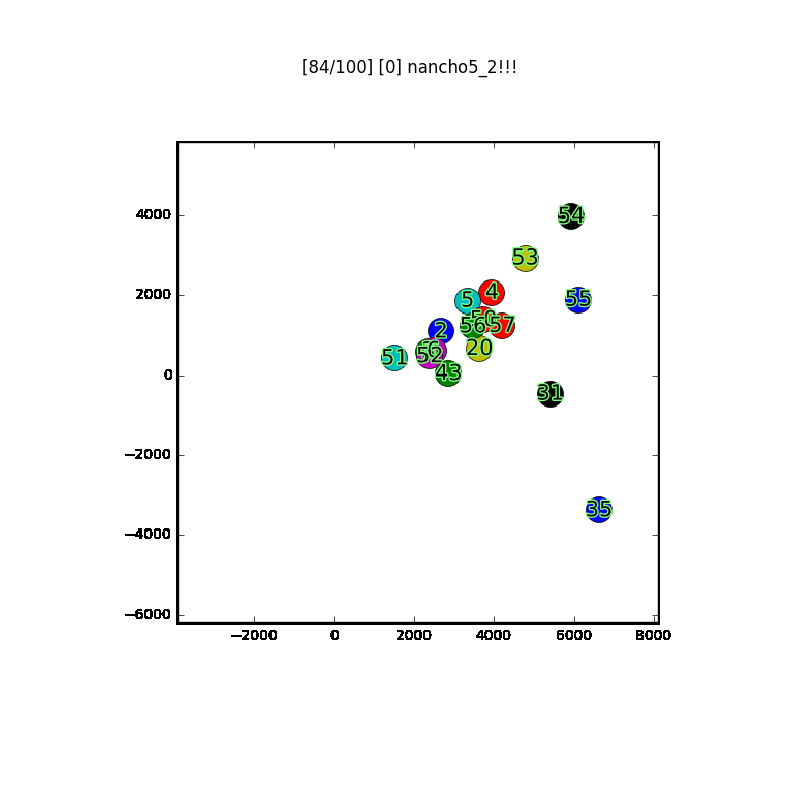
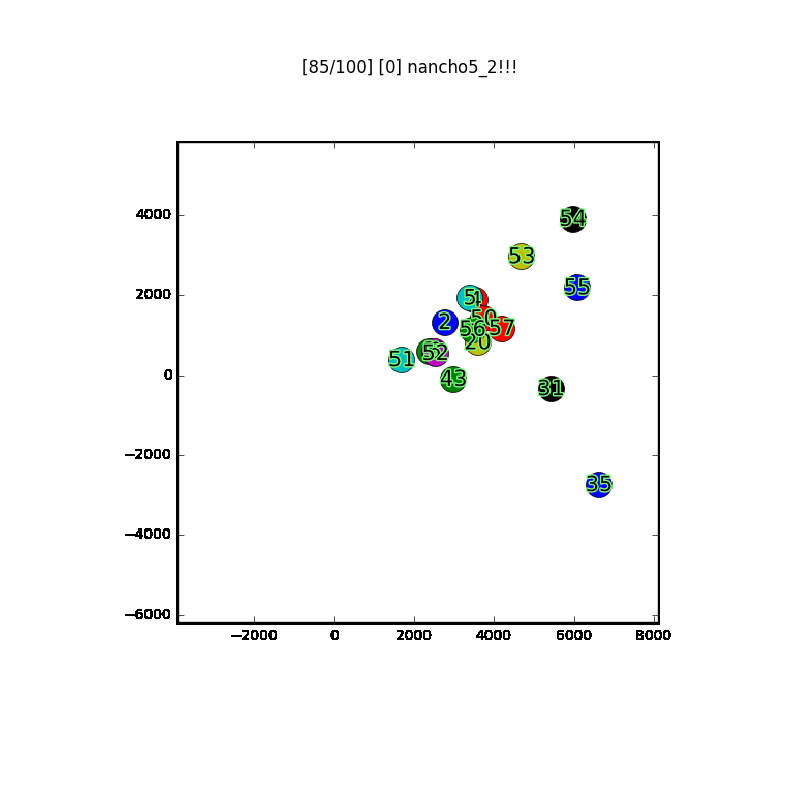
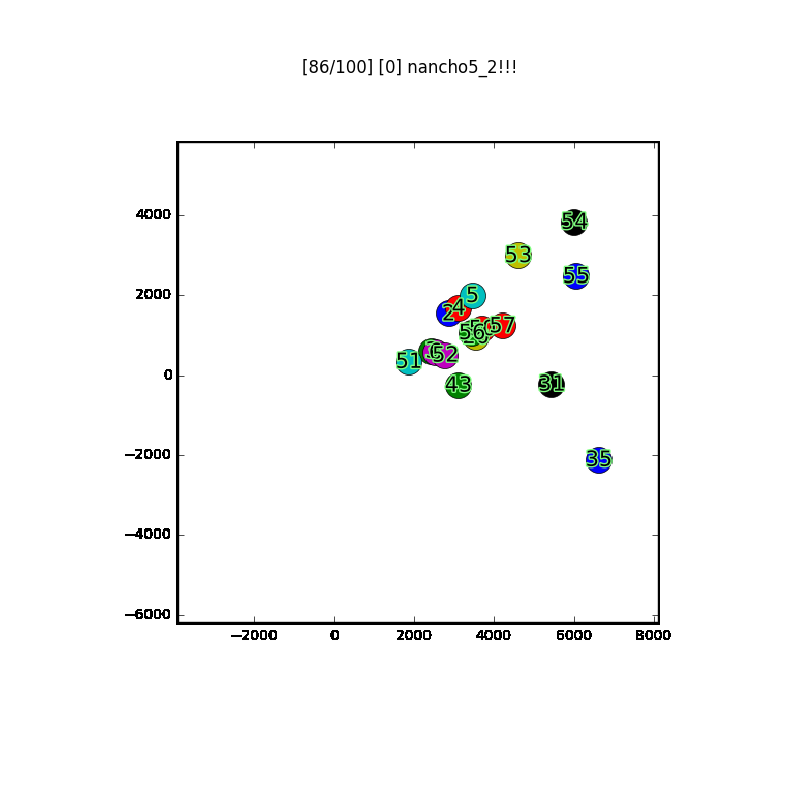
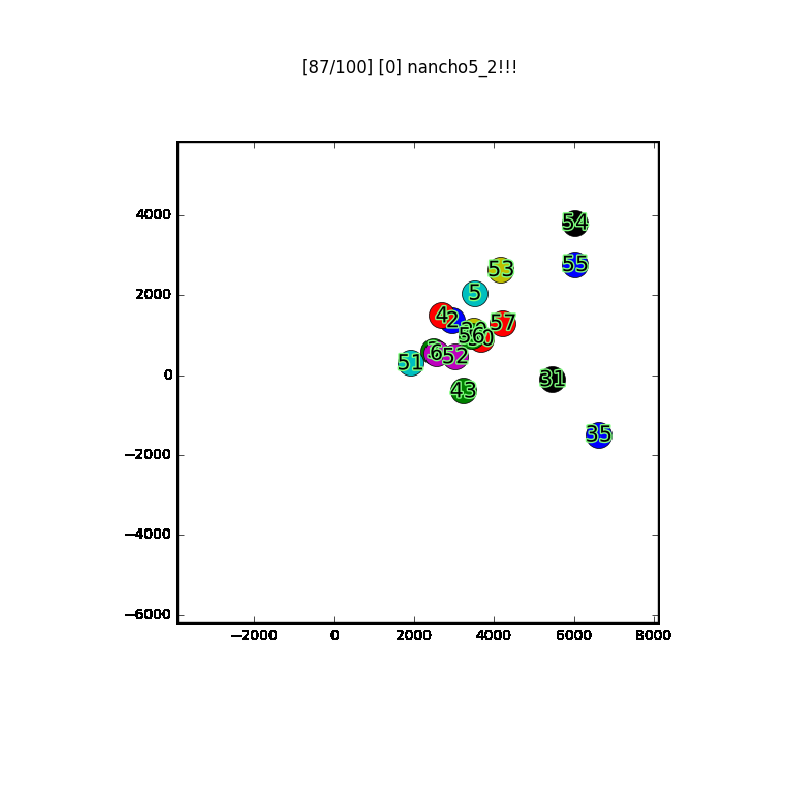
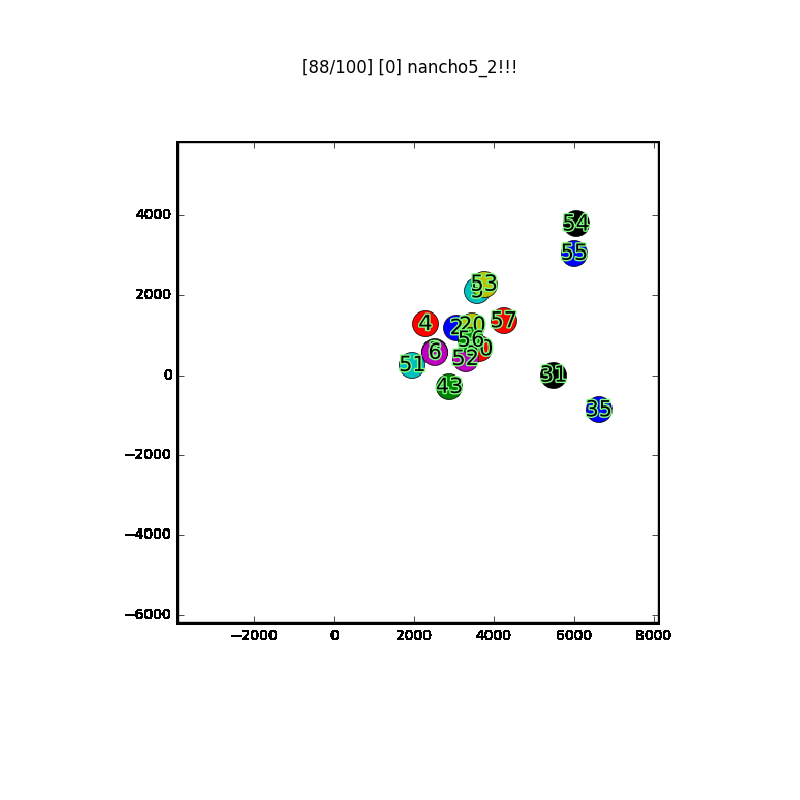
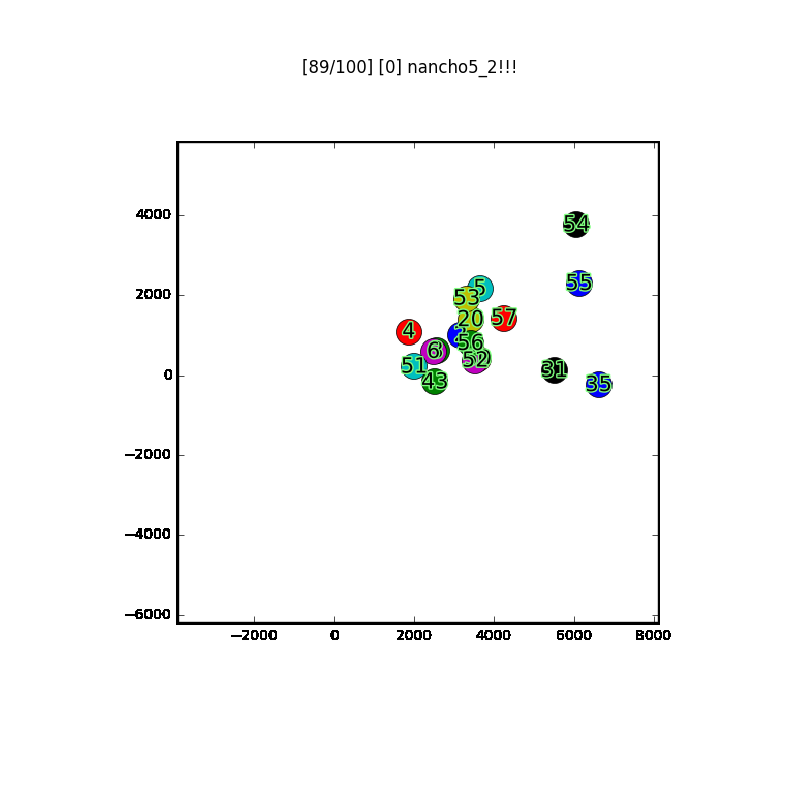
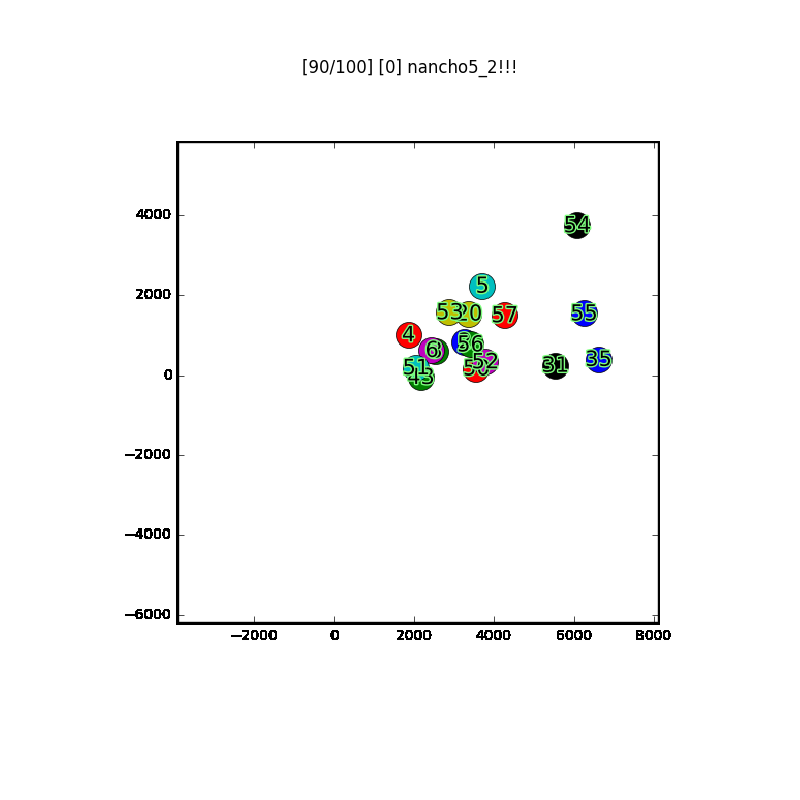
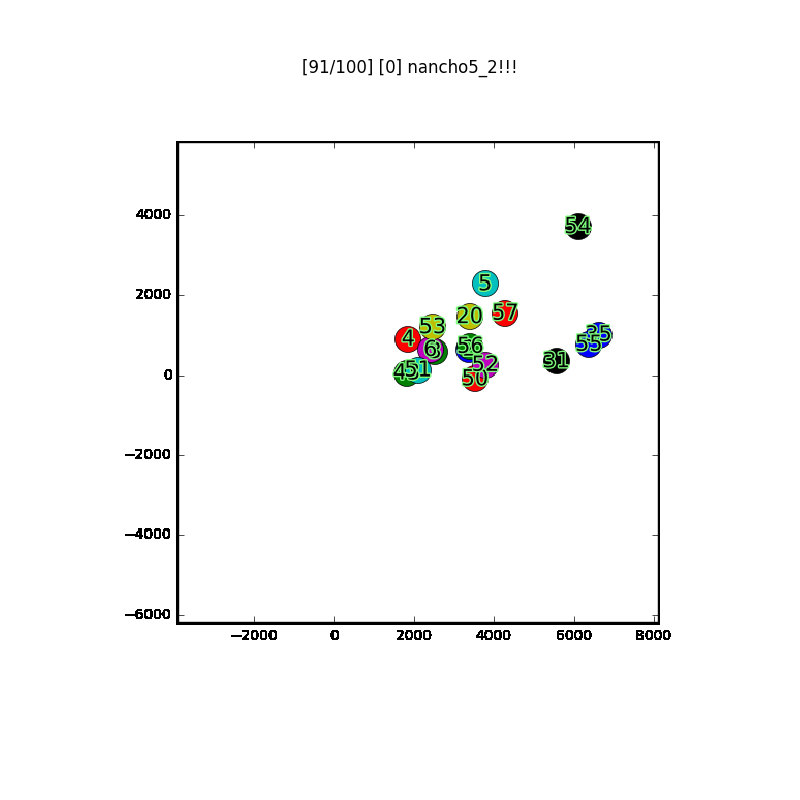
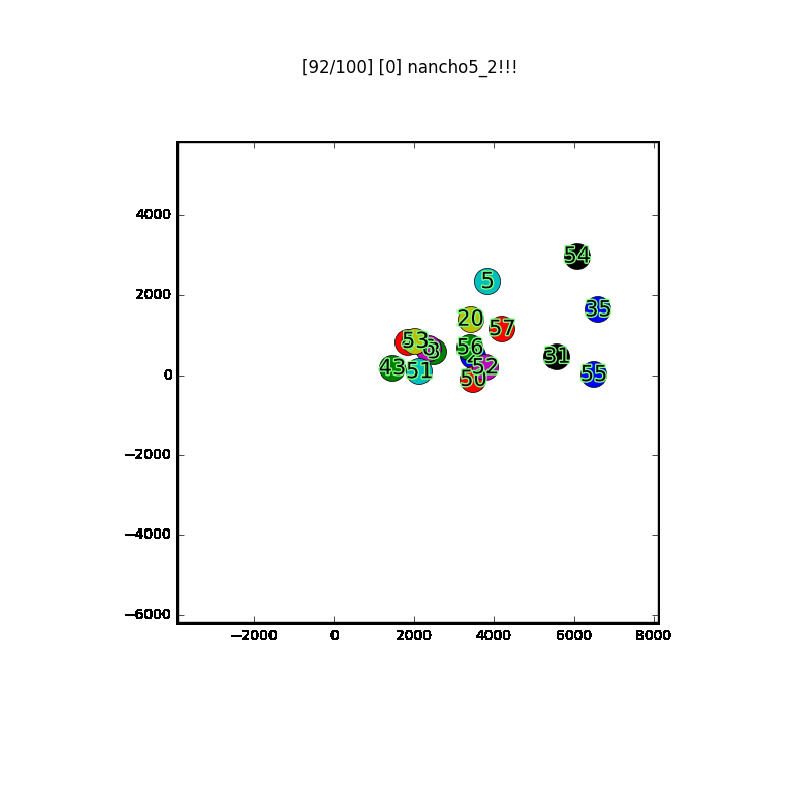
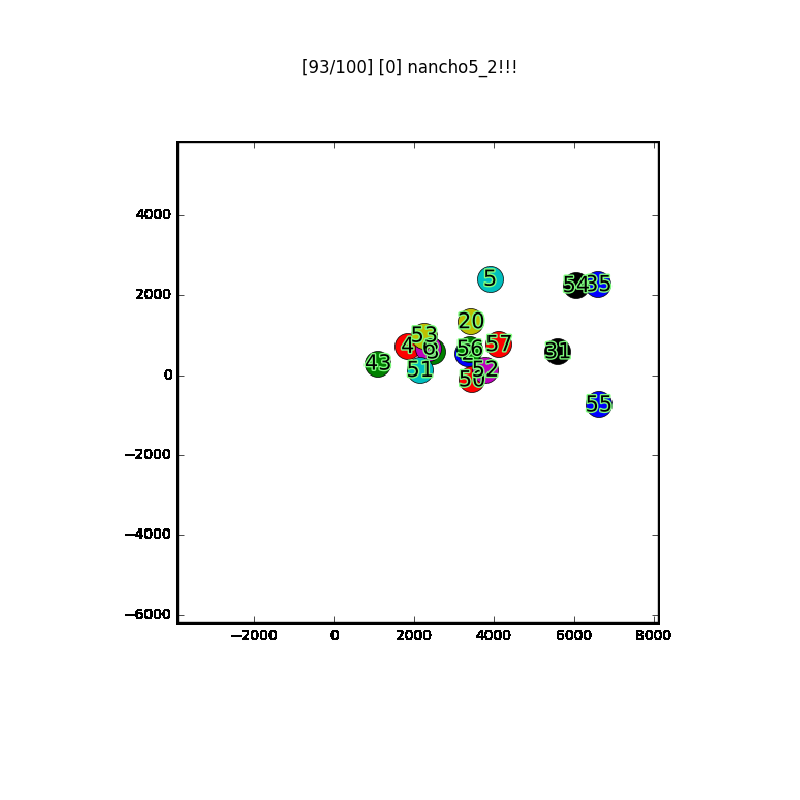
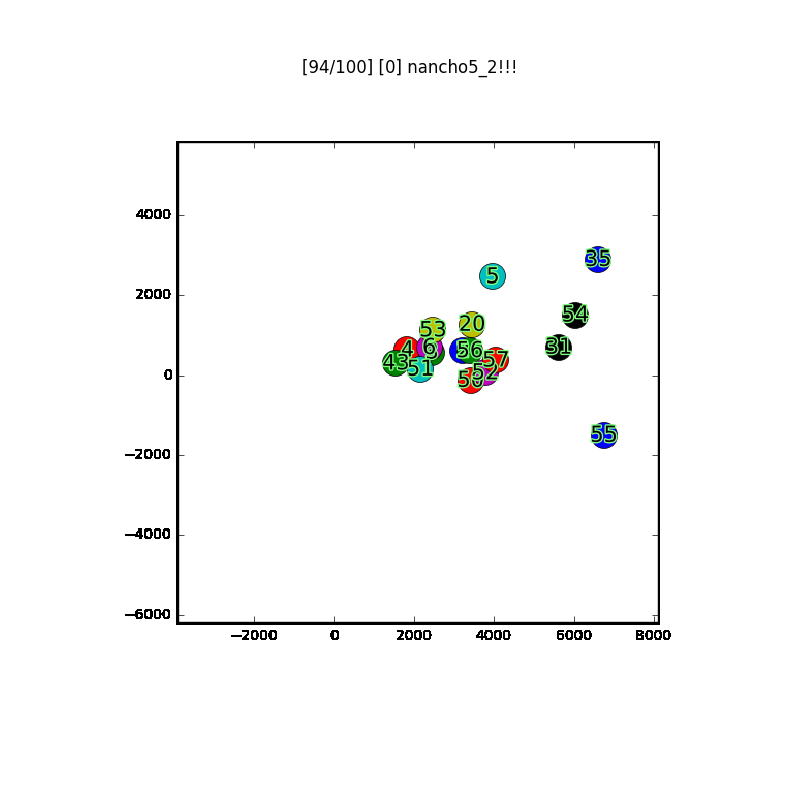
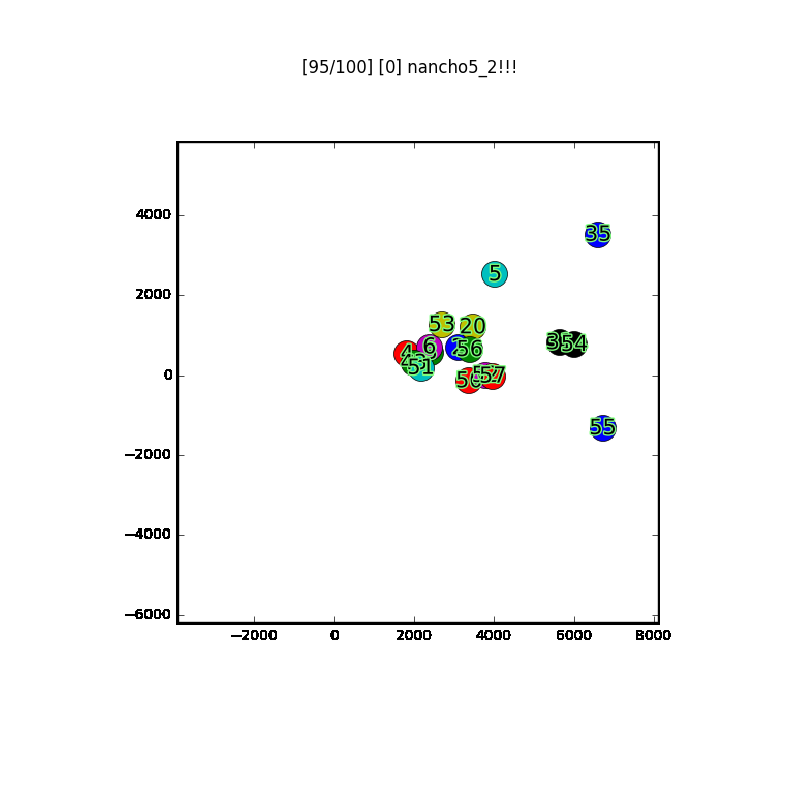
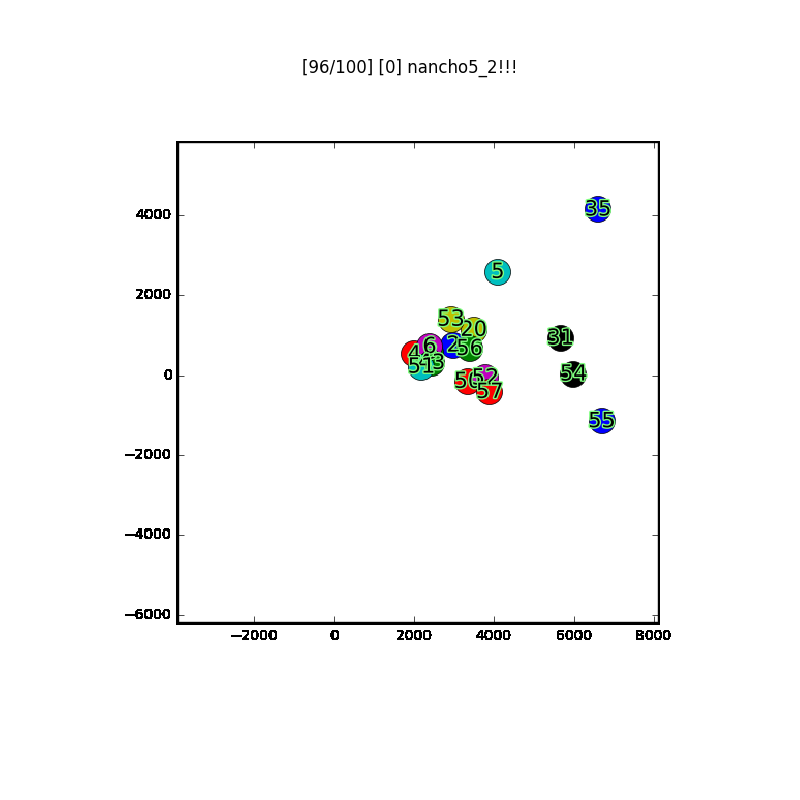
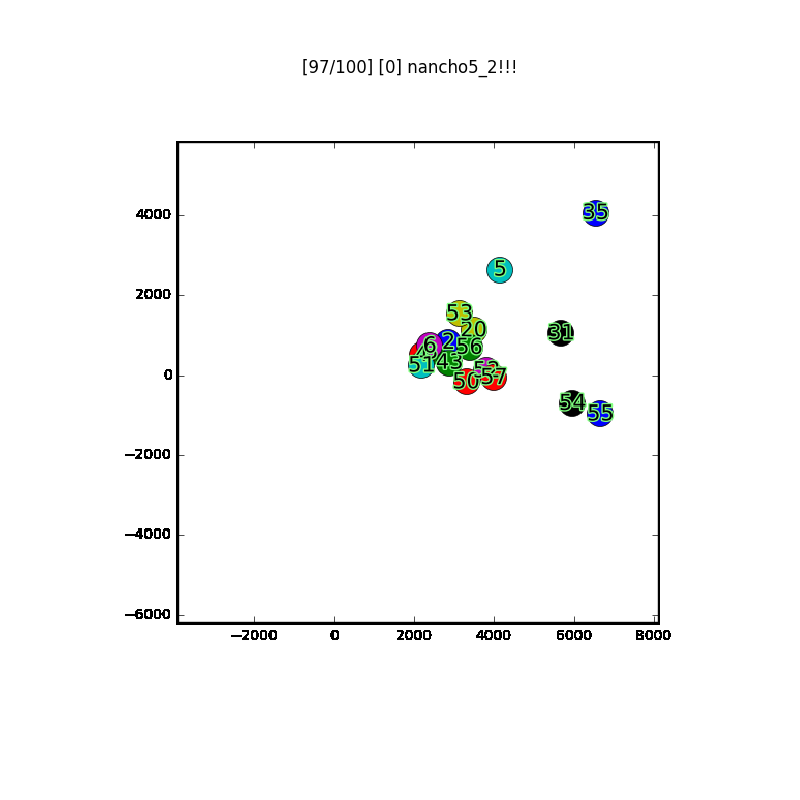
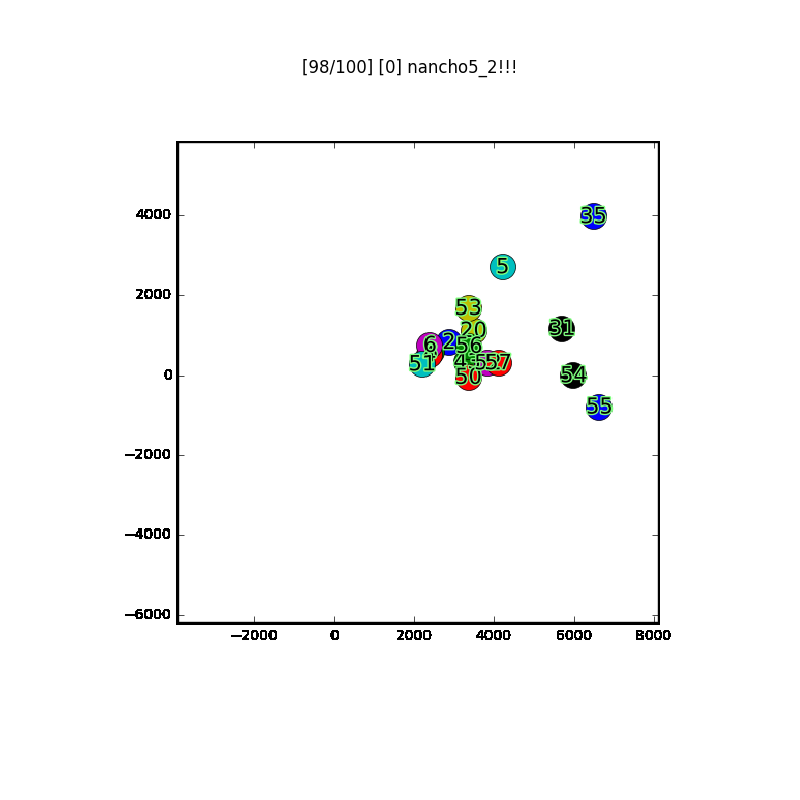
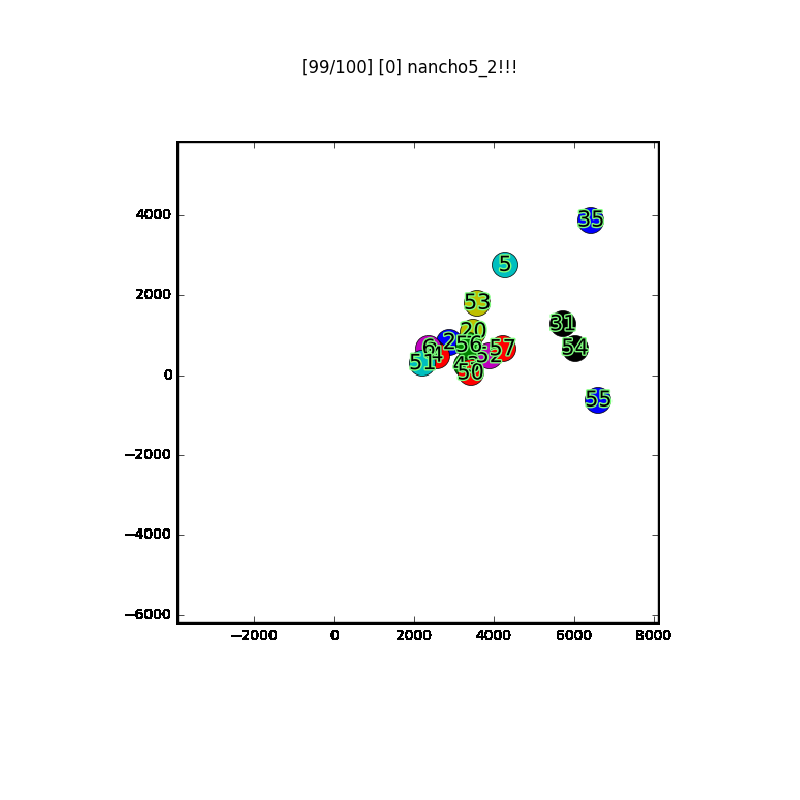
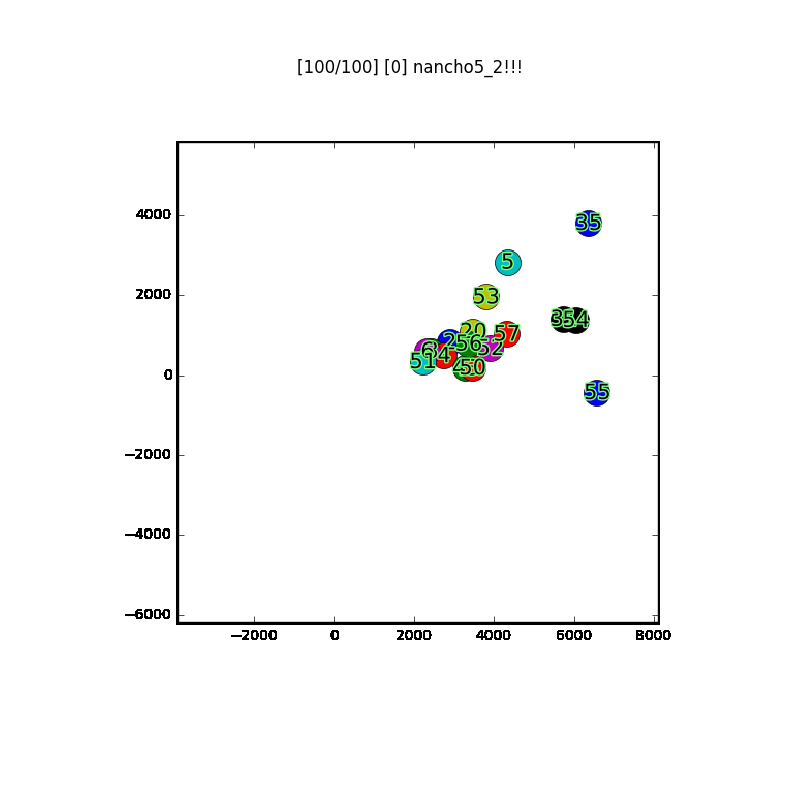

In [7]:
fIdx = 0
nTick = 100
frames = make_frames(_traj=trajList[fIdx]
                     ,_uniqueChildList=uniqueChildIdxList[fIdx],_nTick=nTick)
animate_frames(_frames=frames,_figsize=(8,8),_title=titleList[fIdx])

### Now we have 'nTotalChildren' number of 'totalFeats'

In [8]:
print "Length of 'totalFeats' is [%d]."%len(totalFeats)

Length of 'totalFeats' is [58].


### Get survey results

In [9]:
surveyRes = get_surveyRes()
print surveyRes[:,0].T.shape
print surveyRes[:,0].T

(58,)
[2. 2. 2. 0. 2. 2. 2. 1. 0. 2. 2. 2. 2. 1. 1. 2. 0. 2. 2. 2. 2. 0. 2. 1.
 1. 1. 1. 2. 1. 1. 1. 2. 2. 2. 2. 0. 2. 1. 1. 1. 0. 2. 1. 0. 2. 2. 2. 1.
 2. 0. 2. 2. 2. 2. 2. 1. 2. 1.]


### Normalize features

In [10]:
# Get normalizer 
for i in range(len(totalFeats)):
    if i == 0: _f = totalFeats[i]
    else: _f = np.concatenate((_f,totalFeats[i]),axis=0)
nzrFeat = nzr(_f)
# Normalized
nzdTotalFeats = totalFeats
for i in range(len(totalFeats)):
    nzdTotalFeats[i] = nzrFeat.get_nzdval(totalFeats[i])
print "[%d] featrues normalized"%len(totalFeats)    

[58] featrues normalized


### Split trajectories in chunks

Important parameters

In [11]:
nCluster,chunkSec,reduceDim  = 5,10,5 # 5,10,5:60% / 

In [12]:
# Splite 'nzdTotalFeats' into chunks
chunks_total = []
for i in range(len(nzdTotalFeats)):
    cFeat = nzdTotalFeats[i] # Current feature
    lenFeat,dimFeat = cFeat.shape[0],cFeat.shape[1]
    nDivide = (int)(lenFeat/chunkSec)
    cFeatChunks = np.array_split(cFeat,nDivide,axis=0)
    chunks = []
    for j in range(nDivide): # For all chunks in the splited list
        cChunk = cFeatChunks[j] # Current chunk
        cVec = np.reshape(cChunk[:10,:],newshape=[1,-1])
        chunks.append(cVec)
    chunks_total.append(chunks)
# Print out 'chunks_total'
for i in range(len(chunks_total)):
    currChunk = chunks_total[i]
    print ("[%02d/%d] %d-chunks whose shape is %s"
           %(i,len(chunks_total),len(currChunk),currChunk[0].shape))

[00/58] 887-chunks whose shape is (1, 60)
[01/58] 580-chunks whose shape is (1, 60)
[02/58] 515-chunks whose shape is (1, 60)
[03/58] 515-chunks whose shape is (1, 60)
[04/58] 515-chunks whose shape is (1, 60)
[05/58] 515-chunks whose shape is (1, 60)
[06/58] 342-chunks whose shape is (1, 60)
[07/58] 638-chunks whose shape is (1, 60)
[08/58] 887-chunks whose shape is (1, 60)
[09/58] 638-chunks whose shape is (1, 60)
[10/58] 388-chunks whose shape is (1, 60)
[11/58] 508-chunks whose shape is (1, 60)
[12/58] 887-chunks whose shape is (1, 60)
[13/58] 887-chunks whose shape is (1, 60)
[14/58] 497-chunks whose shape is (1, 60)
[15/58] 497-chunks whose shape is (1, 60)
[16/58] 887-chunks whose shape is (1, 60)
[17/58] 794-chunks whose shape is (1, 60)
[18/58] 794-chunks whose shape is (1, 60)
[19/58] 887-chunks whose shape is (1, 60)
[20/58] 515-chunks whose shape is (1, 60)
[21/58] 794-chunks whose shape is (1, 60)
[22/58] 887-chunks whose shape is (1, 60)
[23/58] 580-chunks whose shape is 

### Accumulate trajectories in Training Set and Cluster!

Children for train:[50] Total feat:[32046] dim:[60]
Shape of 'trainFeat' is (32046, 60)
Shape of 'Ured' is (60, 5)
Shape of 'proj_X' is (32046, 5)


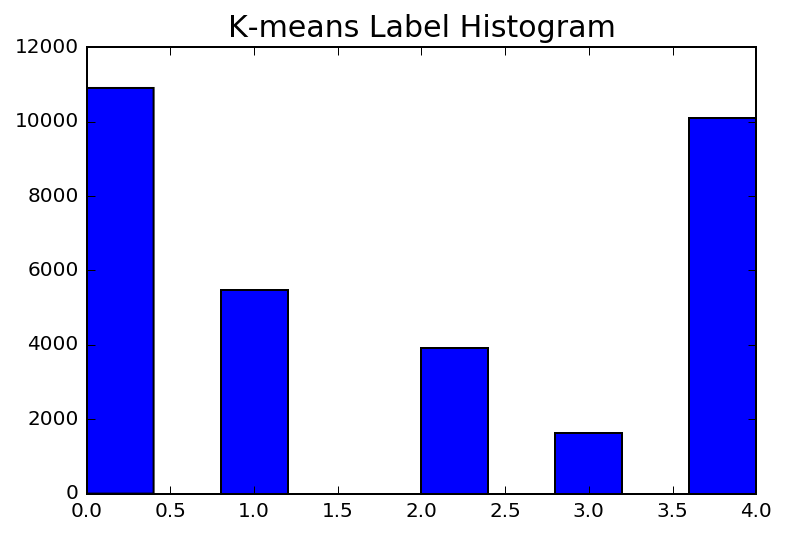

We have [5] centers, each with (5,)


In [13]:
# We will use 'chunks_total' from now on
nTrain = 50 # Use 50 children for traning 
nTest = len(chunks_total) - nTrain
nTotalTrainFeat = 0
for i in range(nTrain):
    currChunk = chunks_total[i]
    lenCurrChunk = len(currChunk)
    unitFeat = currChunk[0]
    nTotalTrainFeat += lenCurrChunk
    dimFeat = unitFeat.shape[1]
print ("Children for train:[%d] Total feat:[%d] dim:[%d]" 
       % (nTrain,nTotalTrainFeat,dimFeat))
trainFeat = np.zeros(shape=(nTotalTrainFeat,dimFeat))
tempIdx = 0
for i in range(nTrain):
    currChunk = chunks_total[i]
    for j in range(len(currChunk)):
        unitFeat = currChunk[j]
        trainFeat[tempIdx,:] = unitFeat
        tempIdx += 1
# Now, we hvae 'trainFeat' whose size is [20591,60]
print "Shape of 'trainFeat' is %s"%(trainFeat.shape,)
# Dimension reduction using PCA
X = trainFeat
U, S, V = np.linalg.svd(X.T, full_matrices=False)
Ured = U[:,:reduceDim]
proj_X  = np.dot(X, Ured)
print "Shape of 'Ured' is %s"%(Ured.shape,)
print "Shape of 'proj_X' is %s"%(proj_X.shape,)
# Run clustering
kmeans = cluster.KMeans(n_clusters=nCluster,random_state=1,tol=1e-6).fit(proj_X)
# Plot clustering results
plt.hist(kmeans.labels_)
plt.title('K-means Label Histogram',fontsize=15)
plt.show()
centers = kmeans.cluster_centers_
print ("We have [%d] centers, each with %s" %(len(centers),centers[0].shape,))

### Convert 'chunks_total' using cluster indices 'centers'

In [14]:
featHistTotal = np.zeros(shape=[len(chunks_total),nCluster])
for i in range(len(chunks_total)): # For all children
    cChunks = chunks_total[i]
    lenChunk = len(cChunks)
    clusterIdxList = np.zeros(shape=lenChunk)
    for j in range(lenChunk): # For all time ticks
        singleChunk = cChunks[j]
        singleFeat = np.matmul(singleChunk,Ured).squeeze() # Reduce dim using PCA
        # Find cluster index
        dists = np.zeros(shape=len(centers))
        for k in range(len(centers)):
            dists[k] = np.linalg.norm(singleFeat-centers[k])
        clusterIdxList[j] = np.argmin(dists)
    # Make cluster index histogram
    currHist = np.histogram(clusterIdxList,bins=np.arange(nCluster+1))[0].astype(np.float32)
    featHistTotal[i,:] = currHist/np.sum(currHist)*nCluster
    x = featHistTotal[i,:]
    print ("[%d/%d] Histogram: %s"%(i,len(chunks_total),
                    np.array2string(x,formatter={'float_kind':lambda x:"%.2f"%x})))

[0/58] Histogram: [1.70 0.76 0.76 0.06 1.72]
[1/58] Histogram: [1.37 0.97 0.56 0.27 1.84]
[2/58] Histogram: [2.11 0.56 0.10 1.60 0.63]
[3/58] Histogram: [3.02 0.67 0.07 0.07 1.17]
[4/58] Histogram: [2.47 0.96 0.11 0.28 1.18]
[5/58] Histogram: [0.91 1.81 0.09 1.21 0.98]
[6/58] Histogram: [3.29 0.31 0.00 0.09 1.32]
[7/58] Histogram: [0.82 0.31 2.57 0.09 1.21]
[8/58] Histogram: [1.69 0.33 1.31 0.12 1.55]
[9/58] Histogram: [1.47 0.26 0.82 0.08 2.37]
[10/58] Histogram: [3.34 0.32 0.03 0.08 1.24]
[11/58] Histogram: [0.47 2.38 0.05 0.11 1.99]
[12/58] Histogram: [1.31 0.69 1.37 0.07 1.57]
[13/58] Histogram: [2.14 0.48 1.34 0.10 0.94]
[14/58] Histogram: [3.43 0.46 0.09 0.08 0.94]
[15/58] Histogram: [1.50 0.55 0.03 0.78 2.13]
[16/58] Histogram: [1.40 1.42 0.59 0.50 1.10]
[17/58] Histogram: [2.35 0.30 0.08 0.03 2.25]
[18/58] Histogram: [0.82 1.76 0.85 0.22 1.34]
[19/58] Histogram: [1.69 0.27 0.72 0.03 2.29]
[20/58] Histogram: [1.72 0.75 0.02 0.17 2.35]
[21/58] Histogram: [1.23 0.96 0.21 0.36 2.24

###  Divide 'featHistTotal' into 'nTrain' and 'nTest' and use 'surveyRes'

In [15]:
surveyRes = get_surveyRes()
print "'featHistTotal' looks like %s"%(featHistTotal.shape,)
print "'surveyRes' looks like %s"%(surveyRes.shape,)
xTrain = featHistTotal[:nTrain,:]
yTrain = surveyRes[:nTrain,:]
xTest = featHistTotal[nTrain:,:]
yTest = surveyRes[nTrain:,:]
nTask = surveyRes.shape[1]
print "[%d] training [%d] test"%(xTrain.shape[0],xTest.shape[0])

'featHistTotal' looks like (58, 5)
'surveyRes' looks like (58, 7)
[50] training [8] test


### Train using XGBOOST [Installation](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/)

In [16]:
import xgboost as xgb

accuracy_list =  np.zeros(shape=nTask)
for tIDx in range(nTask):
    xg_train = xgb.DMatrix(xTrain, label=yTrain[:,tIDx])
    xg_test = xgb.DMatrix(xTest, label=yTest[:,tIDx])
    # setup parameters for xgboost
    param = {}
    # use softmax multi-class classification
    param['objective'] = 'multi:softmax'
    param['num_class'] = 3
    # scale weight of positive examples
    param['eta']       = 0.05 # Learning rate: [0~1] default: 0.3
    param['gamma']     = 5
    param['min_child_weight'] = 0 # 0~
    param['colsample_bytree'] = 0.5 # 0~1
    param['max_depth'] = 10 # Maximum depth of a tree
    param['silent']    = 1 # 1: Silent mode 
    watchlist = [(xg_train,'train'),(xg_test,'test')]
    num_round = 50
    bst = xgb.train(params=param,dtrain=xg_train,num_boost_round=num_round
                    ,evals=watchlist,verbose_eval=False)
    # get prediction
    pred = bst.predict(xg_test)
    error_rate = np.sum(pred != yTest[:,tIDx]) / (float)(yTest[:,tIDx].shape[0])
    #print ' Pred:',pred
    #print ' Real:',yTest[:,tIDx]
    print(' Task [%d] Accuracy: %.2f%%'%(tIDx,(1.0-error_rate)*100))
    accuracy_list[tIDx] = (1.0-error_rate)
print 'average accuracy:',np.mean(accuracy_list)

 Task [0] Accuracy: 75.00%
 Task [1] Accuracy: 37.50%
 Task [2] Accuracy: 25.00%
 Task [3] Accuracy: 62.50%
 Task [4] Accuracy: 87.50%
 Task [5] Accuracy: 75.00%
 Task [6] Accuracy: 62.50%
average accuracy: 0.6071428571428571
